# Proyecto Final — Análisis Stack Overflow (2023–2025)

**Autor:** Franco Maidana\
**Curso:** Python Avanzado en Data Science\
**Fecha:** 16/10/2022

## Resumen

**Objetivo:** Analizar la relación entre características demográficas y laborales de las encuestas de Stack Overflow (2023–2025) y la compensación total anual (CompTotal, USD).

**Metodología:** Limpieza y normalización de los datos (conversión de divisas, manejo de missing y outliers), análisis exploratorio (distribuciones, correlaciones, visualizaciones) y validación de cinco hipótesis relacionadas con experiencia, modalidad remota, país, edad y tecnologías.

**Resultados principales (breve):** Se observa una correlación positiva entre experiencia/edad y compensación; modalidades remotas e híbridas muestran compensaciones superiores a presencial; existen diferencias sustantivas entre países; y ciertas tecnologías están asociadas a mayores niveles de compensación.

**Implicación:** Los hallazgos permiten orientar estudios multivariados y recomendaciones para normalizar comparaciones salariales entre regiones y perfiles técnicos.

## Estructura
1. Parámetros y rutas (definir CSV locales).
2. Carga selectiva de columnas.
3. Limpieza, conteos pre/post filtros y conversión FX en memoria.
4. Análisis exploratorio, validación de 5 hipótesis y conclusiones.

> Nota: coloque los CSVs en las rutas indicadas en la celda `DATA_PATHS` antes de ejecutar.

## Constantes y funciones auxiliares

In [240]:
# Constantes y rutas de datos
DATA_PATHS = {
  '2023': 'data/developer-survey-2023/survey_results_public.csv',
  '2024': 'data/developer-survey-2024/survey_results_public.csv',
  '2025': 'data/developer-survey-2025/survey_results_public.csv',
}

ANIOS = list(DATA_PATHS.keys())

# Columnas de interés
VARIABLES_ANIDADAS = [
  "LanguageHaveWorkedWith", "LanguageWantToWorkWith",
  "WebframeHaveWorkedWith",
  "DatabaseHaveWorkedWith",
  "PlatformHaveWorkedWith",
  "OpSysProfessional use",
]

VARIABLES_NUMERICAS = [
  "CompTotal",
  "WorkExp",
  "YearsCode"
]

VARIABLES_CATEGORICAS = [
  "Age",
  "OrgSize",
  "RemoteWork",
  "Country",
  "Currency",
]

VARIABLES_DE_MUCHAS_OPCIONES = [
  "Employment",
  "DevType",
  "Industry",
]

COLUMNAS_A_ANALIZAR = VARIABLES_ANIDADAS + VARIABLES_NUMERICAS + VARIABLES_CATEGORICAS + VARIABLES_DE_MUCHAS_OPCIONES

In [241]:
# Funciones auxiliares
def separator(texto=""):
  print(f"\n{'=' * 45}\n{texto}\n{'=' * 45}")


#---
def shape_dataframe(df_a_resumir):
  print(f"- Filas: {df_a_resumir.shape[0]}")
  print(f"- Columnas: {df_a_resumir.shape[1]}")


def resumen_dataframe(df_a_resumir, nombre="DataFrame"):
  print(f"\n📊 Resumen de {nombre}:")
  shape_dataframe(df_a_resumir)
  print(f"- Tipos de datos:\n{df_a_resumir.dtypes}")
  print("- Primeras 5 filas:")
  display(df_a_resumir.head())


#---

def resumen_estadistico_con_print(df_a_describir, nombre="DataFrame"):
  print(f"\n📊 Resumen estadístico de {nombre}:")
  print(df_a_describir.describe(include='all').T)


def resumen_estadistico(df_a_describir):
  return df_a_describir.describe(include='all').T


#---

def contador_de_frecuencia_con_print(df_a_contar, nombre="DataFrame"):
  print(f"\nFrecuencia en {nombre}:")
  print(df_a_contar.nunique())


def contador_de_frecuencia(df_a_contar):
  return df_a_contar.nunique()


#---

def contador_de_nulos_con_print(df_a_contar, nombre="DataFrame"):
  print(f"\nConteo de nulos en {nombre:}")
  print(df_a_contar.isnull().sum())
  print(f"Total de nulos: {df_a_contar.isnull().sum().sum()}")


def contador_de_nulos(df_a_contar):
  return df_a_contar.isnull().sum()


#---

def valores_mas_comunes_con_print(df_a_contar, columna, n=10):
  print(f"\nLos {n} valores más comunes en '{columna}':")
  print(df_a_contar[columna].value_counts().head(n))


def valores_mas_comunes(df_a_contar, columna, n=10):
  return df_a_contar[columna].value_counts().head(n)

## Configuración e Importación de Librerías

In [242]:

try:
  import pandas as pd
  import numpy as np
  import matplotlib.pyplot as plt
  import seaborn as sns
  import warnings

  plt.style.use('seaborn-v0_8-darkgrid')
  sns.set_theme(
    style="darkgrid",
    palette="colorblind",  # Paleta accesible
    context="notebook",
    rc={"figure.figsize": (16, 8)}
  )

  %matplotlib inline

  # Configuración de pandas para mejor visualización
  pd.set_option('display.max_columns', None)
  pd.set_option('display.max_rows', 100)
  pd.set_option('display.width', 1000)

  warnings.filterwarnings('ignore')

  # Configuración de gráficos (para presentaciones)
  plt.rcParams['figure.figsize'] = (16, 8)
  plt.rcParams['font.size'] = 12
  plt.rcParams['axes.titlesize'] = 14
  plt.rcParams['axes.labelsize'] = 12
  plt.rcParams['xtick.labelsize'] = 10
  plt.rcParams['ytick.labelsize'] = 10
  plt.rcParams['legend.fontsize'] = 10

  print("✅ Librerías importadas correctamente")

except ImportError as e:
  print(f"❌ Error al importar librerías: {e}")
except Exception as e:
  print(f"❌ Error inesperado: {e}")

✅ Librerías importadas correctamente


## Carga de datos de las encuestas

In [243]:
df = {}

for year, path in DATA_PATHS.items():
  try:
    df[year] = pd.read_csv(path, usecols=COLUMNAS_A_ANALIZAR, low_memory=False)
    print("✅ Cargado", year, "con", df[year].shape[0], "filas y", df[year].shape[1], "columnas.")

  except FileNotFoundError:
    print(f"⚠️ Archivo {year} no encontrado: {path}")

  except Exception as e:
    print(f"❌ Error al cargar {year}: {e})")
    print(f"📊 Total de años cargados: {len(df)}")

✅ Cargado 2023 con 89184 filas y 17 columnas.
✅ Cargado 2024 con 65437 filas y 17 columnas.
✅ Cargado 2025 con 49123 filas y 17 columnas.


## Resumen de los datos cargados

### Composición y tipos de datos

In [244]:
for anio in ANIOS:
  separator(f"Resumen inicial de datos - {anio}")
  resumen_dataframe(df[anio], nombre=f"Encuesta {anio}")


Resumen inicial de datos - 2023

📊 Resumen de Encuesta 2023:
- Filas: 89184
- Columnas: 17
- Tipos de datos:
Age                        object
Employment                 object
RemoteWork                 object
YearsCode                  object
DevType                    object
OrgSize                    object
Country                    object
Currency                   object
CompTotal                 float64
LanguageHaveWorkedWith     object
LanguageWantToWorkWith     object
DatabaseHaveWorkedWith     object
PlatformHaveWorkedWith     object
WebframeHaveWorkedWith     object
OpSysProfessional use      object
WorkExp                   float64
Industry                   object
dtype: object
- Primeras 5 filas:


Age                                         Employment                            RemoteWork YearsCode                               DevType                   OrgSize                   Country                   Currency  CompTotal                             LanguageHaveWorkedWith                             LanguageWantToWorkWith                     DatabaseHaveWorkedWith                             PlatformHaveWorkedWith                        WebframeHaveWorkedWith                            OpSysProfessional use  WorkExp                                           Industry
0  18-24 years old                                                NaN                                   NaN       NaN                                   NaN                       NaN                       NaN                        NaN        NaN                                                NaN                                                NaN                                        NaN                                                NaN                                           NaN                                              NaN      NaN                                                NaN
1  25-34 years old                                Employed, full-time                                Remote        18  Senior Executive (C-Suite, VP, etc.)          2 to 9 employees  United States of America  USD\tUnited States dollar   285000.0                         HTML/CSS;JavaScript;Python  Bash/Shell (all shells);C#;Dart;Elixir;GDScrip...                                   Supabase           Amazon Web Services (AWS);Netlify;Vercel                    Next.js;React;Remix;Vue.js  MacOS;Windows;Windows Subsystem for Linux (WSL)     10.0  Information Services, IT, Software Development...
2  45-54 years old                                Employed, full-time  Hybrid (some remote, some in-person)        27                   Developer, back-end  5,000 to 9,999 employees  United States of America  USD\tUnited States dollar   250000.0                         Bash/Shell (all shells);Go                                 Haskell;OCaml;Rust                                        NaN  Amazon Web Services (AWS);Google Cloud;OpenSta...                                           NaN                          MacOS;Other Linux-based     23.0  Information Services, IT, Software Development...
3  25-34 years old                                Employed, full-time  Hybrid (some remote, some in-person)        12                  Developer, front-end      100 to 499 employees  United States of America  USD\tUnited States dollar   156000.0  Bash/Shell (all shells);HTML/CSS;JavaScript;PH...  Bash/Shell (all shells);HTML/CSS;JavaScript;Ru...                           PostgreSQL;Redis                                  Cloudflare;Heroku  Node.js;React;Ruby on Rails;Vue.js;WordPress                                 iOS;iPadOS;MacOS      7.0                                                NaN
4  25-34 years old  Employed, full-time;Independent contractor, fr...                                Remote         6                 Developer, full-stack        20 to 99 employees               Philippines       PHP\tPhilippine peso  1320000.0                     HTML/CSS;JavaScript;TypeScript         HTML/CSS;JavaScript;Python;Rust;TypeScript  BigQuery;Elasticsearch;MongoDB;PostgreSQL  Amazon Web Services (AWS);Firebase;Heroku;Netl...   Express;Gatsby;NestJS;Next.js;Node.js;React                          Other (Please Specify):      6.0                                              Other


Resumen inicial de datos - 2024

📊 Resumen de Encuesta 2024:
- Filas: 65437
- Columnas: 17
- Tipos de datos:
Age                        object
Employment                 object
RemoteWork                 object
YearsCode                  object
DevType                    object
OrgSize                    object
Country                    object
Currency                   object
CompTotal                 float64
LanguageHaveWorkedWith     object
LanguageWantToWorkWith     object
DatabaseHaveWorkedWith     object
PlatformHaveWorkedWith     object
WebframeHaveWorkedWith     object
OpSysProfessional use      object
WorkExp                   float64
Industry                   object
dtype: object
- Primeras 5 filas:


Age           Employment RemoteWork YearsCode                DevType OrgSize                                            Country Currency  CompTotal                             LanguageHaveWorkedWith                             LanguageWantToWorkWith           DatabaseHaveWorkedWith                    PlatformHaveWorkedWith                  WebframeHaveWorkedWith OpSysProfessional use  WorkExp Industry
0  Under 18 years old  Employed, full-time     Remote       NaN                    NaN     NaN                           United States of America      NaN        NaN                                                NaN                                                NaN                              NaN                                       NaN                                     NaN                   NaN      NaN      NaN
1     35-44 years old  Employed, full-time     Remote        20  Developer, full-stack     NaN  United Kingdom of Great Britain and Northern I...      NaN        NaN  Bash/Shell (all shells);Go;HTML/CSS;Java;JavaS...  Bash/Shell (all shells);Go;HTML/CSS;Java;JavaS...      Dynamodb;MongoDB;PostgreSQL  Amazon Web Services (AWS);Heroku;Netlify           Express;Next.js;Node.js;React                 MacOS     17.0      NaN
2     45-54 years old  Employed, full-time     Remote        37   Developer Experience     NaN  United Kingdom of Great Britain and Northern I...      NaN        NaN                                                 C#                                                 C#       Firebase Realtime Database                              Google Cloud                            ASP.NET CORE               Windows      NaN      NaN
3     18-24 years old   Student, full-time        NaN         4  Developer, full-stack     NaN                                             Canada      NaN        NaN  C;C++;HTML/CSS;Java;JavaScript;PHP;PowerShell;...  HTML/CSS;Java;JavaScript;PowerShell;Python;SQL...  MongoDB;MySQL;PostgreSQL;SQLite   Amazon Web Services (AWS);Fly.io;Heroku  jQuery;Next.js;Node.js;React;WordPress                   NaN      NaN      NaN
4     18-24 years old   Student, full-time        NaN         9  Developer, full-stack     NaN                                             Norway      NaN        NaN            C++;HTML/CSS;JavaScript;Lua;Python;Rust                 C++;HTML/CSS;JavaScript;Lua;Python                PostgreSQL;SQLite                                       NaN                                     NaN                   NaN      NaN      NaN


Resumen inicial de datos - 2025

📊 Resumen de Encuesta 2025:
- Filas: 49123
- Columnas: 17
- Tipos de datos:
Age                        object
Employment                 object
WorkExp                   float64
YearsCode                 float64
DevType                    object
OrgSize                    object
RemoteWork                 object
Industry                   object
Country                    object
Currency                   object
CompTotal                 float64
LanguageHaveWorkedWith     object
LanguageWantToWorkWith     object
DatabaseHaveWorkedWith     object
PlatformHaveWorkedWith     object
WebframeHaveWorkedWith     object
OpSysProfessional use      object
dtype: object
- Primeras 5 filas:


Age                                         Employment  WorkExp  YearsCode               DevType                   OrgSize                                         RemoteWork                      Industry      Country                  Currency  CompTotal                             LanguageHaveWorkedWith                    LanguageWantToWorkWith                             DatabaseHaveWorkedWith                             PlatformHaveWorkedWith                     WebframeHaveWorkedWith             OpSysProfessional use
0  25-34 years old                                           Employed      8.0       14.0     Developer, mobile        20 to 99 employees                                             Remote                       Fintech      Ukraine         EUR European Euro    52800.0                   Bash/Shell (all shells);Dart;SQL                                      Dart                         Cloud Firestore;PostgreSQL  Amazon Web Services (AWS);Cloudflare;Firebase;...                                        NaN  Windows;MacOS;Android;iOS;iPadOS
1  25-34 years old                                           Employed      2.0       10.0   Developer, back-end      500 to 999 employees  Hybrid (some in-person, leans heavy to flexibi...  Retail and Consumer Services  Netherlands         EUR European Euro    90000.0                                               Java                         Java;Python;Swift                                   Dynamodb;MongoDB  Amazon Web Services (AWS);Datadog;Docker;Homeb...                                Spring Boot                             MacOS
2  35-44 years old  Independent contractor, freelancer, or self-em...     10.0       12.0  Developer, front-end                       NaN                                                NaN          Software Development      Ukraine     UAH Ukrainian hryvnia  2214000.0                Dart;HTML/CSS;JavaScript;TypeScript       Dart;HTML/CSS;JavaScript;TypeScript                           MongoDB;MySQL;PostgreSQL                          Datadog;Firebase;npm;pnpm                      Next.js;Node.js;React                             MacOS
3  35-44 years old                                           Employed      4.0        5.0   Developer, back-end  10,000 or more employees                                             Remote  Retail and Consumer Services      Ukraine         EUR European Euro    31200.0                                    Java;Kotlin;SQL                               Java;Kotlin                                                NaN             Amazon Web Services (AWS);Google Cloud                                Spring Boot                    Windows;Ubuntu
4  35-44 years old  Independent contractor, freelancer, or self-em...     21.0       22.0   Engineering manager                       NaN                                                NaN          Software Development      Ukraine  USD United States dollar    60000.0  C;C#;C++;Delphi;HTML/CSS;Java;JavaScript;Lua;P...  C#;Java;JavaScript;Python;SQL;TypeScript  Elasticsearch;Microsoft SQL Server;MySQL;Oracl...  Amazon Web Services (AWS);APT;Docker;Make;Mave...  Angular;ASP.NET;ASP.NET Core;Flask;jQuery             Windows;Ubuntu;Debian

### Conteo de valores únicos

#### Variable y funciones utiles para conteo de valores únicos por categoría

In [245]:
categorias_para_contar_valores = {
  "variables categóricas": VARIABLES_CATEGORICAS,
  "variables de muchas opciones": VARIABLES_DE_MUCHAS_OPCIONES,
  "variables numéricas": VARIABLES_NUMERICAS,
}

In [246]:
def mostrar_valores_unicos_por_categoria(categorias_dict):
  for nombre_categoria, columnas in categorias_dict.items():
    separator(f"=== Conteo de valores únicos - {nombre_categoria} ===")
    df_resultado = pd.DataFrame()

    for anio in ANIOS:
      conteo = contador_de_frecuencia(df[anio][columnas])
      df_resultado[anio] = conteo

    # Agrega la fila 'Total' al final con la suma de valores únicos por año
    df_resultado.loc['Total'] = df_resultado.sum()

    display(df_resultado)

#### Resultados

In [247]:
mostrar_valores_unicos_por_categoria(categorias_para_contar_valores)


=== Conteo de valores únicos - variables categóricas ===


2023  2024  2025
Age            8     8     7
OrgSize       10    10     9
RemoteWork     3     3     5
Country      185   185   177
Currency     144   142   142
Total        350   348   340


=== Conteo de valores únicos - variables de muchas opciones ===


2023  2024  2025
Employment   106   110     6
DevType       33    34    32
Industry      12    15    15
Total        151   159    53


=== Conteo de valores únicos - variables numéricas ===


2023  2024  2025
CompTotal  3828  3337  2676
WorkExp      51    51    72
YearsCode    52    52    78
Total      3931  3440  2826

### Conteo de nulos

#### Variable y funciones utiles para conteo de nulos por categoría

In [248]:
def mostrar_conteo_nulos_por_categoria(categorias_dict, data_frame_utilizado=df):
  for nombre_categoria, columnas in categorias_dict.items():
    separator(f"=== Conteo de nulos - {nombre_categoria} ===")
    df_resultado = pd.DataFrame()

    for anio in ANIOS:
      conteo = contador_de_nulos(data_frame_utilizado[anio][columnas])
      df_resultado[anio] = conteo

    # Agrega la fila 'Total' al final con la suma por año
    df_resultado.loc['Total'] = df_resultado.sum()

    display(df_resultado)

In [249]:
# Diccionario de categorías y sus columnas
categorias_para_contar_nulos = {
  "variables categóricas": VARIABLES_CATEGORICAS,
  "variables de muchas opciones": VARIABLES_DE_MUCHAS_OPCIONES,
  "variables numéricas": VARIABLES_NUMERICAS,
  "variables anidadas": VARIABLES_ANIDADAS,
}

#### Resultado

In [250]:
mostrar_conteo_nulos_por_categoria(categorias_para_contar_nulos)


=== Conteo de nulos - variables categóricas ===


2023   2024   2025
Age             0      0      0
OrgSize     24141  17957  14979
RemoteWork  15374  10631  15376
Country      1211   6507  13721
Currency    23850  18753  13721
Total       64576  53848  57797


=== Conteo de nulos - variables de muchas opciones ===


2023   2024   2025
Employment   1286      0    846
DevType     12312   5992   5487
Industry    52410  36579  15516
Total       66008  42571  21849


=== Conteo de nulos - variables numéricas ===


2023   2024   2025
CompTotal  40959  31697  24284
WorkExp    45605  35779   6279
YearsCode   1749   5568   6123
Total      88313  73044  36686


=== Conteo de nulos - variables anidadas ===


2023   2024    2025
LanguageHaveWorkedWith   2044   5692   17480
LanguageWantToWorkWith   8475   9685   22069
WebframeHaveWorkedWith  22246  20276   26153
DatabaseHaveWorkedWith  15749  15183   23595
PlatformHaveWorkedWith  25556  23071   24889
OpSysProfessional use   10597  12464   20265
Total                   84667  86371  134451

## Limpieza y preparación de datos

### Valores principales o más repetidos

In [251]:
for anio in ANIOS:
  separator(f"Valores más comunes - {anio}")
  for columna in VARIABLES_CATEGORICAS:
    valores_mas_comunes_con_print(df[anio], columna, n=5)



Valores más comunes - 2023

Los 5 valores más comunes en 'Age':
Age
25-34 years old       33247
35-44 years old       20532
18-24 years old       17931
45-54 years old        8334
Under 18 years old     4128
Name: count, dtype: int64

Los 5 valores más comunes en 'OrgSize':
OrgSize
20 to 99 employees          13380
100 to 499 employees        12218
10,000 or more employees     7929
1,000 to 4,999 employees     7235
2 to 9 employees             6439
Name: count, dtype: int64

Los 5 valores más comunes en 'RemoteWork':
RemoteWork
Hybrid (some remote, some in-person)    31131
Remote                                  30566
In-person                               12113
Name: count, dtype: int64

Los 5 valores más comunes en 'Country':
Country
United States of America                                18647
Germany                                                  7328
India                                                    5625
United Kingdom of Great Britain and Northern Ireland     5552
Cana

In [252]:
for columna in VARIABLES_CATEGORICAS:
  print(f"\n=== {columna} ===")
  df_valores_mas_repetidos = pd.DataFrame()

  for anio in ANIOS:
    top_valores = valores_mas_comunes(df[anio], columna, n=5)
    df_valores_mas_repetidos[anio] = top_valores

  display(df_valores_mas_repetidos)



=== Age ===


2023     2024     2025
Age                                        
25-34 years old     33247  23911.0  16485.0
35-44 years old     20532  14942.0  13232.0
18-24 years old     17931  14098.0   9195.0
45-54 years old      8334   6249.0   6265.0
Under 18 years old   4128      NaN      NaN


=== OrgSize ===


2023  2024    2025
OrgSize                                      
20 to 99 employees        13380  9754  6680.0
100 to 499 employees      12218  8694  6104.0
10,000 or more employees   7929  5558  4959.0
1,000 to 4,999 employees   7235  5353  4152.0
2 to 9 employees           6439  4833     NaN


=== RemoteWork ===


2023   2024     2025
RemoteWork                                                 
Hybrid (some remote, some in-person)  31131  23015      NaN
Remote                                30566  20831  10924.0
In-person                             12113  10960   6034.0


=== Country ===


2023     2024    2025
Country                                                                   
United States of America                            18647  11095.0  7226.0
Germany                                              7328   4947.0  3022.0
India                                                5625   4231.0  2542.0
United Kingdom of Great Britain and Northern Ir...   5552   3224.0  2038.0
Canada                                               3507      NaN     NaN


=== Currency ===


2023   2024    2025
Currency                                       
EUR European Euro          17651  12730  9614.0
USD\tUnited States dollar  16729  10939     NaN
GBP\tPound sterling         4473   2614     NaN
INR\tIndian rupee           3615   2905     NaN
CAD\tCanadian dollar        2647   1639     NaN

### Filtrado y limpieza
Para este análisis, nos enfocaremos en desarrolladores (DevType) que trabajan en países con monedas específicas, y con experiencia laboral relevante (WorkExp). Además, eliminaremos registros con edades no especificadas o fuera del rango típico de desarrolladores.

#### Variables y constantes para limpieza

In [253]:
df_filtrado = df.copy()

In [254]:
# Constantes
# Eliminaremos a los menores de edad para disminuir la cantidad de nulos en los data frames
EDAD_QUE_NO_VAMOS_A_CONSIDERAR = [
  "Under 18 years old", "55-64 years old", "65 years or older"
]

# Reemplazaremos los valores de nulos por "No especificado"
COLUMNAS_A_RELLENAR = ["OrgSize", "RemoteWork", "Industry", "Country", "Employment"]

# Dejaremos los datos que tengan monedas en los valores a considerar
# MONEDAS_A_CONSIDERAR = "USD|EUR"
MONEDAS_A_CONSIDERAR = "USD|EUR|GBP|INR|CAD|PLN|BRL|AUD|SEK|CHF|CZK|ILS|NOK|DKK|RUB|UAH|ZAR"
MONEDAS = MONEDAS_A_CONSIDERAR.split("|")

# Dejaremos únicamente los datos de los desarrolladores
TIPO_DE_DESARROLLADOR = "Developer"

#### Filtrado y limpieza de los data frames

In [255]:
for year in ANIOS:
  data_frame = df[year].copy()

  # Eliminaremos a las edades que no vamos a considerar
  data_frame = data_frame[~data_frame["Age"].isin(EDAD_QUE_NO_VAMOS_A_CONSIDERAR)]

  # Eliminaremos a los que no sean desarrolladores
  data_frame = data_frame[data_frame["DevType"].str.contains(TIPO_DE_DESARROLLADOR, na=False)]

  # Dejaremos solo a los que cobran con las monedas a considerar
  data_frame = data_frame[data_frame["Currency"].str.contains(MONEDAS_A_CONSIDERAR, na=False)]

  # Eliminaremos todos los desarrolladores que tengan
  #   - Menos de 1 año programando
  #   - Más de 50 años programando
  if year == "2025":
    data_frame.loc[data_frame["YearsCode"] < 1, "YearsCode"] = np.nan
    data_frame.loc[data_frame["YearsCode"] > 50, "YearsCode"] = np.nan
  else:
    # Si hay strings no numéricos, los convertiremos a float, poniendo NaN donde falle
    data_frame["YearsCode"] = pd.to_numeric(data_frame["YearsCode"], errors='coerce')
  # Ahora elimina los NaN que quedaron tras conversión
  data_frame.dropna(subset=["YearsCode"], inplace=True)

  # Dejaremos únicamente a los tengan experiencia de trabajo
  data_frame.dropna(subset=["WorkExp"], inplace=True)
  data_frame.dropna(subset=["CompTotal"], inplace=True)
  data_frame.dropna(subset=["LanguageHaveWorkedWith"], inplace=True)

  # Remplazaremos los nulos en categorías de strings por "No especificado"
  for columna in COLUMNAS_A_RELLENAR:
    data_frame[columna] = data_frame[columna].fillna("No especificado")

  for columna in VARIABLES_ANIDADAS:
    data_frame[columna] = data_frame[columna].fillna("Ninguno")
  # Asignamos el data frame limpio al diccionario
  df_filtrado[year] = data_frame

In [256]:
for anio in ANIOS:
  separator(f"Resumen post-limpieza - {anio}")
  shape_dataframe(df_filtrado[anio])
mostrar_conteo_nulos_por_categoria(categorias_para_contar_nulos, df_filtrado)


Resumen post-limpieza - 2023
- Filas: 21158
- Columnas: 17

Resumen post-limpieza - 2024
- Filas: 14624
- Columnas: 17

Resumen post-limpieza - 2025
- Filas: 11862
- Columnas: 17

=== Conteo de nulos - variables categóricas ===


2023  2024  2025
Age            0     0     0
OrgSize        0     0     0
RemoteWork     0     0     0
Country        0     0     0
Currency       0     0     0
Total          0     0     0


=== Conteo de nulos - variables de muchas opciones ===


2023  2024  2025
Employment     0     0     0
DevType        0     0     0
Industry       0     0     0
Total          0     0     0


=== Conteo de nulos - variables numéricas ===


2023  2024  2025
CompTotal     0     0     0
WorkExp       0     0     0
YearsCode     0     0     0
Total         0     0     0


=== Conteo de nulos - variables anidadas ===


2023  2024  2025
LanguageHaveWorkedWith     0     0     0
LanguageWantToWorkWith     0     0     0
WebframeHaveWorkedWith     0     0     0
DatabaseHaveWorkedWith     0     0     0
PlatformHaveWorkedWith     0     0     0
OpSysProfessional use      0     0     0
Total                      0     0     0

#### Conversión de divisas
Dado que los datos de compensación (CompTotal) están en diferentes monedas, es crucial

In [257]:
# Tasas de cambio históricas: cuántos USD equivalen a 1 unidad de moneda “X” en ese año
tasas_cambio = {
  '2023': {
    'EUR': 1.0999,
    'GBP': 1.2637,  # promedio de junio 2023: ~1.2637 USD por GBP :contentReference[oaicite:0]{index=0}
    # agregar más monedas...
    'INR': 0.0121,  # ~1 INR = 0.0121 USD (esto es solo un ejemplo)
    'CAD': 0.74,  # ~1 CAD = 0.74 USD (ejemplo)
    'PLN': 0.25,  # ~1 PLN = 0.25 USD (ejemplo)
    'BRL': 0.19,  # ~1 BRL = 0.19 USD (ejemplo)
    'AUD': 0.65,  # ~1 AUD = 0.65 USD (ejemplo)
    'SEK': 0.095,  # ~1 SEK = 0.095 USD (ejemplo)
    'CHF': 1.10,  # ~1 CHF = 1.10 USD (ejemplo)
    'CZK': 0.043,  # etc.
    'ILS': 0.27,
    'NOK': 0.10,
    'DKK': 0.15,
    'RUB': 0.013,
    'UAH': 0.027,
    'ZAR': 0.053,
    # etc.
  },
  '2024': {
    'EUR': 1.0830,
    'GBP': 1.25,  # ejemplo
    'INR': 0.0120,
    'CAD': 0.75,
    'PLN': 0.24,
    'BRL': 0.20,
    'AUD': 0.67,
    'SEK': 0.093,
    'CHF': 1.08,
    'CZK': 0.042,
    'ILS': 0.28,
    'NOK': 0.11,
    'DKK': 0.16,
    'RUB': 0.014,
    'UAH': 0.026,
    'ZAR': 0.054,
  },
  '2025': {
    'EUR': 1.1700,
    'GBP': 1.30,  # ejemplo
    'INR': 0.0118,
    'CAD': 0.78,
    'PLN': 0.26,
    'BRL': 0.21,
    'AUD': 0.70,
    'SEK': 0.098,
    'CHF': 1.12,
    'CZK': 0.045,
    'ILS': 0.29,
    'NOK': 0.12,
    'DKK': 0.17,
    'RUB': 0.015,
    'UAH': 0.028,
    'ZAR': 0.056,
  }
}

In [258]:
for year, df_year in df_filtrado.items():
  tasa_dict = tasas_cambio.get(str(year), {})
  separator(year)
  print(f"\nAntes de conversión, monedas en {year}:")
  print(df_year['Currency'].value_counts())

  # Recorre cada fila (o grupo por moneda)
  for moneda, tasa in tasa_dict.items():
    # construir la etiqueta tal que coincida con tus datos de "Currency"
    # por ejemplo, los valores que viste incluyen cosas como "GBP\tPound sterling"
    # podrías identificar solo por el prefijo antes de '\t'
    mask = df_year['Currency'].str.startswith(moneda)
    if mask.any():
      # Convertir
      df_year.loc[mask, 'CompTotal'] = df_year.loc[mask, 'CompTotal'] * tasa
      # Cambiar la etiqueta Currency para indicar conversión + moneda origen
      df_year.loc[mask, 'Currency'] = f"USD (desde {moneda})"
      print(f"Año {year}: convertidos {mask.sum()} registros de {moneda} a USD")

  print(f"Después de conversión, monedas en {year}:")
  print(df_year['Currency'].value_counts())


2023

Antes de conversión, monedas en 2023:
Currency
EUR European Euro            6562
USD\tUnited States dollar    6504
GBP\tPound sterling          1717
INR\tIndian rupee            1245
CAD\tCanadian dollar         1043
PLN\tPolish zloty             677
BRL\tBrazilian real           668
AUD\tAustralian dollar        535
SEK\tSwedish krona            481
CHF\tSwiss franc              313
CZK\tCzech koruna             261
ILS\tIsraeli new shekel       235
NOK\tNorwegian krone          222
DKK\tDanish krone             219
RUB\tRussian ruble            215
ZAR\tSouth African rand       158
UAH\tUkrainian hryvnia        103
Name: count, dtype: int64
Año 2023: convertidos 6562 registros de EUR a USD
Año 2023: convertidos 1717 registros de GBP a USD
Año 2023: convertidos 1245 registros de INR a USD
Año 2023: convertidos 1043 registros de CAD a USD
Año 2023: convertidos 677 registros de PLN a USD
Año 2023: convertidos 668 registros de BRL a USD
Año 2023: convertidos 535 registros de AUD a

### Detección de valores atípicos (“outliers”) en CompTotal

#### Función para detectar outliers usando el método del rango intercuartílico (IQR)

In [259]:
def detectar_outliers_iqr(serie):
  Q1 = serie.quantile(0.25)
  Q3 = serie.quantile(0.75)
  IQR = Q3 - Q1
  lim_inf = Q1 - 1.5 * IQR
  lim_sup = Q3 + 1.5 * IQR
  return (serie < lim_inf) | (serie > lim_sup)

#### Detectar y marcar los outliers

In [260]:
for anio, df_anio in df_filtrado.items():
  separator(f"🔍 Detectando outliers en CompTotal para {anio}...")

  serie = df_anio['CompTotal']

  # Detectar outliers usando IQR
  outliers = detectar_outliers_iqr(serie)

  # Marcar en el DataFrame original (mismo índice que 'serie')
  df_anio['Outlier_CompTotal'] = False
  df_anio.loc[serie.index[outliers], 'Outlier_CompTotal'] = True

  print(f"{outliers.sum()} outliers detectados en {anio}")


🔍 Detectando outliers en CompTotal para 2023...
877 outliers detectados en 2023

🔍 Detectando outliers en CompTotal para 2024...
633 outliers detectados en 2024

🔍 Detectando outliers en CompTotal para 2025...
547 outliers detectados en 2025


#### Analizar los outliers detectados

##### Exploración

In [261]:
for anio, df_anio in df_filtrado.items():
  total = len(df_anio)
  outliers = df_anio['Outlier_CompTotal'].sum()
  porcentaje = (outliers / total) * 100
  print(f"Año {anio}: {outliers} outliers de {total} registros ({porcentaje:.2f}%)")

Año 2023: 877 outliers de 21158 registros (4.15%)
Año 2024: 633 outliers de 14624 registros (4.33%)
Año 2025: 547 outliers de 11862 registros (4.61%)


In [262]:
for anio, df_anio in df_filtrado.items():
  outliers_df = df_anio[df_anio['Outlier_CompTotal']]
  if not outliers_df.empty:
    print(f"\nEjemplos de outliers en {anio}:")
    display(outliers_df.sort_values('CompTotal', ascending=False).head(5))


Ejemplos de outliers en 2023:


Age                                         Employment                            RemoteWork  YearsCode                DevType                   OrgSize                                            Country         Currency    CompTotal                             LanguageHaveWorkedWith                             LanguageWantToWorkWith                             DatabaseHaveWorkedWith                             PlatformHaveWorkedWith                          WebframeHaveWorkedWith                              OpSysProfessional use  WorkExp                                           Industry  Outlier_CompTotal
53268  18-24 years old  Independent contractor, freelancer, or self-em...  Hybrid (some remote, some in-person)        3.0  Developer, full-stack          2 to 9 employees                                             Canada  USD (desde CAD)  74000000.00  Bash/Shell (all shells);HTML/CSS;JavaScript;Py...  Assembly;C;HTML/CSS;JavaScript;PHP;PowerShell;...                                            Ninguno                                            Ninguno                                       WordPress  Android;iOS;iPadOS;MacOS;Other Linux-based;Win...      7.0  Information Services, IT, Software Development...               True
64972  25-34 years old  Employed, full-time;Independent contractor, fr...                                Remote       12.0   Developer, front-end      500 to 999 employees                                           Portugal  USD (desde EUR)   9316153.00                                HTML/CSS;TypeScript                     HTML/CSS;JavaScript;TypeScript                                            Ninguno                          Amazon Web Services (AWS)  AngularJS;Next.js;Node.js;Nuxt.js;React;Vue.js                                              MacOS     17.0                                              Other               True
34996  18-24 years old                                Employed, full-time                                Remote        7.0  Developer, full-stack        20 to 99 employees                                             Canada  USD (desde CAD)   7399999.26                    Bash/Shell (all shells);Haskell                          Bash/Shell (all shells);C                                         PostgreSQL             Amazon Web Services (AWS);Google Cloud                                             Elm                                  Other Linux-based      1.0                                         Healthcare               True
79949  45-54 years old                                Employed, full-time  Hybrid (some remote, some in-person)       24.0  Developer, full-stack      500 to 999 employees                                             Brazil  USD (desde BRL)   4169044.22  C#;Delphi;HTML/CSS;Java;JavaScript;PHP;Python;...  C#;Delphi;HTML/CSS;Java;JavaScript;Kotlin;PHP;...  Firebase Realtime Database;Microsoft SQL Serve...  Amazon Web Services (AWS);Firebase;Google Clou...               ASP.NET;ASP.NET CORE;jQuery;React                         Android;iOS;Ubuntu;Windows     25.0                                              Other               True
32596  25-34 years old                                Employed, full-time  Hybrid (some remote, some in-person)        8.0    Developer, back-end  1,000 to 4,999 employees  United Kingdom of Great Britain and Northern I...  USD (desde GBP)   2148290.00  Bash/Shell (all shells);Groovy;Java;JavaScript...                   Java;Kotlin;Scala;SQL;TypeScript  Cassandra;IBM DB2;Microsoft SQL Server;PostgreSQL                                            Ninguno                             Angular;Spring Boot  Red Hat;Windows;Windows Subsystem for Linux (WSL)      5.0                                 Financial Services               True


Ejemplos de outliers en 2024:


Age                                         Employment                            RemoteWork  YearsCode                DevType                   OrgSize                   Country                   Currency     CompTotal                             LanguageHaveWorkedWith                          LanguageWantToWorkWith                             DatabaseHaveWorkedWith                             PlatformHaveWorkedWith                             WebframeHaveWorkedWith                              OpSysProfessional use  WorkExp              Industry  Outlier_CompTotal
24677  18-24 years old                                Employed, full-time                                Remote        9.0  Developer, QA or test        20 to 99 employees                  Slovakia            USD (desde EUR)  1.083000e+20                             Dart;JavaScript;Python                                     Dart;Python                                            Ninguno                                            Ninguno                                              Flask                                  Android;iOS;MacOS      4.0  Software Development               True
17593  35-44 years old                                Employed, full-time                                Remote       16.0    Developer, back-end        20 to 99 employees                    Brazil            USD (desde BRL)  6.800000e+06                                        Elixir;Ruby                           Elixir;Go;Kotlin;Ruby                                   MySQL;PostgreSQL                   Amazon Web Services (AWS);Heroku                              Phoenix;Ruby on Rails                                              MacOS     13.0  Software Development               True
17672  25-34 years old                                Employed, full-time                                Remote       16.0      Developer, mobile  1,000 to 4,999 employees                   Ukraine            USD (desde UAH)  5.200000e+06                                  Objective-C;Swift                               Objective-C;Swift                                            Ninguno                                            Ninguno                                            Ninguno                                          iOS;MacOS     11.0  Software Development               True
41313  45-54 years old  Independent contractor, freelancer, or self-em...  Hybrid (some remote, some in-person)        1.0      Developer, mobile  10,000 or more employees  United States of America  USD\tUnited States dollar  5.000000e+06  Ada;Apex;Assembly;Bash/Shell (all shells);C;C#...                            Crystal;Elixir;F#;Go  BigQuery;Cassandra;Clickhouse;Cloud Firestore;...  Alibaba Cloud;Amazon Web Services (AWS);Cloudf...  Angular;AngularJS;ASP.NET;ASP.NET CORE;Astro;B...  AIX;Android;ChromeOS;iOS;iPadOS;MacOS;Other Li...     21.0                Other:               True
19267  25-34 years old                                Employed, full-time                             In-person       13.0   Developer, front-end  1,000 to 4,999 employees                     India            USD (desde INR)  3.378000e+06                            HTML/CSS;JavaScript;SQL  HTML/CSS;JavaScript;Python;Rust;TypeScript;Zig  BigQuery;Elasticsearch;MongoDB;MySQL;Redis;Sup...  Amazon Web Services (AWS);Firebase;Google Clou...                      Express;Next.js;Node.js;React                                              MacOS      7.0                Other:               True


Ejemplos de outliers en 2025:


Age                                         Employment  WorkExp  YearsCode                DevType                   OrgSize                                      RemoteWork                         Industry  Country         Currency     CompTotal                           LanguageHaveWorkedWith                        LanguageWantToWorkWith                             DatabaseHaveWorkedWith                             PlatformHaveWorkedWith                WebframeHaveWorkedWith                      OpSysProfessional use  Outlier_CompTotal
28700  35-44 years old                                           Employed     20.0       27.0  Developer, full-stack      100 to 499 employees                                          Remote             Software Development  Ukraine  USD (desde UAH)  3.920000e+07            C#;HTML/CSS;JavaScript;SQL;TypeScript                    C#;HTML/CSS;SQL;TypeScript  Cosmos DB;Dynamodb;Microsoft SQL Server;Postgr...  Amazon Web Services (AWS);Docker;Microsoft Azu...  ASP.NET Core;Next.js;React;WordPress  Windows;Windows Subsystem for Linux (WSL)               True
24900  18-24 years old                                           Employed      1.0        4.0  Developer, full-stack      100 to 499 employees  Hybrid (some remote, leans heavy to in-person)             Software Development    India  USD (desde INR)  9.676000e+06          HTML/CSS;Java;JavaScript;SQL;TypeScript  C++;Elixir;Erlang;Go;Java;Python;R;Scala;SQL  Cloud Firestore;Elasticsearch;MySQL;PostgreSQL...         APT;Docker;Google Cloud;Maven (build tool)                   Angular;Spring Boot                                    Windows               True
37352  35-44 years old  Independent contractor, freelancer, or self-em...     15.0       15.0  Developer, full-stack           No especificado                                 No especificado       Banking/Financial Services  Ukraine  USD (desde UAH)  8.050011e+06          HTML/CSS;JavaScript;Ruby;SQL;TypeScript                                       Ninguno                     Elasticsearch;PostgreSQL;Redis  Amazon Web Services (AWS);Cloudflare;Docker;Te...                         Ruby on Rails                                     Ubuntu               True
30728  35-44 years old                                           Employed     17.0       21.0    Developer, back-end  10,000 or more employees                                          Remote                          Fintech   Brazil  USD (desde BRL)  7.350000e+06  Bash/Shell (all shells);Elixir;Go;Kotlin;Python                                          Rust  BigQuery;Databricks SQL;DuckDB;Dynamodb;MongoD...  Amazon Web Services (AWS);Datadog;Docker;Googl...                Django;FastAPI;Phoenix                                    Ninguno               True
40518  35-44 years old                                           Employed     20.0       25.0  Developer, full-stack        20 to 99 employees                                          Remote  Transportation, or Supply Chain   Brazil  USD (desde BRL)  2.100000e+06          HTML/CSS;JavaScript;Ruby;SQL;TypeScript                            Go;Lua;Python;Rust  DuckDB;Dynamodb;Elasticsearch;MariaDB;MongoDB;...  Amazon Web Services (AWS);Bun;Cloudflare;Datad...           Node.js;React;Ruby on Rails                                  MacOS;iOS               True

In [263]:
# Combinar los outliers de todos los años
outliers_todos = []

for anio, df_anio in df_filtrado.items():
  outliers = df_anio[df_anio['Outlier_CompTotal']].copy()
  outliers['Año'] = anio
  outliers_todos.append(outliers)

df_outliers = pd.concat(outliers_todos)

print(f"Total de outliers detectados: {len(df_outliers)}")

# Países más frecuentes
print("\n🌍 Países más comunes entre los outliers:")
print(df_outliers['Country'].value_counts().head(5))

# Experiencia laboral y años programando
print("\n💼 Experiencia laboral y años programando (promedios):")
print("WorkExp:", round(df_outliers['WorkExp'].mean(), 1))
print("YearsCode:", round(pd.to_numeric(df_outliers['YearsCode'], errors='coerce').mean(), 1))

# Tamaño de la empresa
print("\n🏢 Tamaño de empresa más común:")
print(df_outliers['OrgSize'].value_counts().head(3))

# Tipo de desarrollador
print("\n👨‍💻 Tipo de desarrollador más común:")
print(df_outliers['DevType'].value_counts().head(3))

# Modalidad de trabajo
print("\n🏠 Modalidad de trabajo:")
print(df_outliers['RemoteWork'].value_counts())


Total de outliers detectados: 2057

🌍 Países más comunes entre los outliers:
Country
United States of America                                1638
United Kingdom of Great Britain and Northern Ireland      93
Canada                                                    69
Germany                                                   28
Australia                                                 27
Name: count, dtype: int64

💼 Experiencia laboral y años programando (promedios):
WorkExp: 15.0
YearsCode: 19.9

🏢 Tamaño de empresa más común:
OrgSize
10,000 or more employees    765
1,000 to 4,999 employees    342
100 to 499 employees        263
Name: count, dtype: int64

👨‍💻 Tipo de desarrollador más común:
DevType
Developer, back-end      774
Developer, full-stack    752
Developer, mobile        119
Name: count, dtype: int64

🏠 Modalidad de trabajo:
RemoteWork
Remote                                                                          1083
Hybrid (some remote, some in-person)                     

##### Conclusión

Los 1.135 outliers detectados en la variable CompTotal corresponden mayoritariamente a desarrolladores con un perfil laboral avanzado. En promedio, tienen más de 15 años de experiencia laboral y 21 años programando, lo cual ya los posiciona por encima del resto de la muestra.

Además, provienen en su mayoría de países con altos niveles salariales como Reino Unido, Canadá, Alemania, Suiza y Australia. Trabajan principalmente en empresas grandes (más de 10.000 empleados) y en roles técnicos bien remunerados como desarrollador back-end y full-stack.

También predominan las modalidades de trabajo remoto o híbrido, lo que sugiere acceso a oportunidades globales con mejores salarios.

📌 Por estas razones, estos valores son extremos pero legítimos, y aunque representan una minoría, se decidió excluirlos de algunos análisis generales para evitar que distorsionen los resultados agregados.

#### Nuevo dict sin outliers

In [264]:
df_filtrado_sin_outliers = {
  anio: df_anio[~df_anio['Outlier_CompTotal']].copy()
  for anio, df_anio in df_filtrado.items()
}

### Backup: Guardar data frames limpios

In [265]:
# Guardaremos los datos filtrados sin outliers para análisis futuros
for anio, df_anio in df_filtrado_sin_outliers.items():
  df_anio.to_csv(f'data/cleaned_survey_{anio}_no_outliers.csv', index=False)

In [266]:
# También guardaremos los datos con outliers para referencia
for anio, df_anio in df_filtrado.items():
  df_anio.to_csv(f'data/cleaned_survey_{anio}_with_outliers.csv', index=False)

In [267]:
#  # Backup para no ejecutar todo lo anterior
# df_filtrado_sin_outliers = {
#   '2023': pd.read_csv('data/cleaned_survey_2023_no_outliers.csv'),
#   '2024': pd.read_csv('data/cleaned_survey_2024_no_outliers.csv'),
#   '2025': pd.read_csv('data/cleaned_survey_2025_no_outliers.csv'),
# }
#
# df_filtrado = {
#   '2023': pd.read_csv('data/cleaned_survey_2023_with_outliers.csv'),
#   '2024': pd.read_csv('data/cleaned_survey_2024_with_outliers.csv'),
#   '2025': pd.read_csv('data/cleaned_survey_2025_with_outliers.csv'),
# }

## Análisis exploratorio

### Resumen estadístico
  1. Funciones utilizadas
  2. Distribución general con y sin outliers
  3. Visualización de outliers en CompTotal
      - Medidas de tendencia central y dispersión
      - Diferencia con y sin valores atípicos
      - Gráficos: hist, box y violin plot

#### 1. Funciones utilizadas

In [268]:
def resumen_estadistico_por_anio(df_a_resumir):
  for anio in ANIOS:
    print(f"\nResumen estadístico de variables numéricas - {anio}\n")

    # Para cada variable numérica, generamos la descripción y la guardamos
    resumen_anio = []
    for columna in VARIABLES_NUMERICAS:
      desc = resumen_estadistico(df_a_resumir[anio][columna])
      resumen_anio.append(desc)

    # Unimos las descripciones estadísticas de todas las columnas de este año en un solo DataFrame
    resumen_anio_df = pd.concat(resumen_anio, axis=1)
    resumen_anio_df.columns = [f"{columna} ({anio})" for columna in VARIABLES_NUMERICAS]

    # Imprimimos el resumen para este año
    display(resumen_anio_df)


#  ---
def calcular_estadisticas(series):
  return {
    'min': series.min(),
    'Q1': series.quantile(0.25),
    'median': series.median(),
    'mean': series.mean(),
    'Q3': series.quantile(0.75),
    'max': series.max()
  }


# ---

limitacion_q = 0.995  # Limitar visualización al percentil 95 para evitar distorsión por outliers


def plot_histograma(ax, data, titulo, color='skyblue', log=False):
  stats = calcular_estadisticas(data)

  sns.histplot(data, bins=50, kde=True, ax=ax, color=color, log_scale=log)

  # Líneas verticales con etiquetas
  ax.axvline(stats['mean'], color='red', linestyle='--', label=f"Media: {stats['mean']:.0f}")
  ax.axvline(stats['median'], color='green', linestyle='-.', label=f"Mediana: {stats['median']:.0f}")
  ax.axvline(stats['Q1'], color='orange', linestyle=':', label=f"Q1: {stats['Q1']:.0f}")
  ax.axvline(stats['Q3'], color='purple', linestyle=':', label=f"Q3: {stats['Q3']:.0f}")
  ax.axvline(stats['min'], color='gray', linestyle='-', alpha=0.5, label=f"Mínimo: {stats['min']:.0f}")
  ax.axvline(stats['max'], color='black', linestyle='-', alpha=0.5, label=f"Máximo: {stats['max']:.0f}")

  ax.set_title(titulo)
  ax.set_xlabel("CompTotal (USD)")
  ax.set_ylabel("Frecuencia")
  ax.legend()
  ax.set_xlim(0, data.quantile(limitacion_q))  # Limitar visualización


def plot_box_violin_comparado(df_con_outliers, df_sin_outliers, anios):
  # Convertir ambos datasets en formato largo
  data_con = []
  data_sin = []
  for anio in anios:
    for valor in df_con_outliers[anio]['CompTotal']:
      data_con.append({'Año': anio, 'CompTotal': valor, 'Tipo': 'Con Outliers'})
    for valor in df_sin_outliers[anio]['CompTotal']:
      data_sin.append({'Año': anio, 'CompTotal': valor, 'Tipo': 'Sin Outliers'})

  df_comb = pd.DataFrame(data_con + data_sin)

  # Limitar visualización para que se vean los outliers
  max_val = df_comb['CompTotal'].quantile(limitacion_q)

  # Crear figura con dos columnas: boxplot y violin plot
  fig, axes = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)
  fig.suptitle('Distribución Comparativa de CompTotal - Con y Sin Outliers', fontsize=18)

  # 🎁 Boxplot
  sns.boxplot(
    data=df_comb,
    x='Año',
    y='CompTotal',
    hue='Tipo',
    ax=axes[0],
    showfliers=True,
    dodge=True,
    palette={'Con Outliers': '#3498db', 'Sin Outliers': '#2ecc71'}
  )
  axes[0].set_title('Boxplot')
  axes[0].set_ylabel('CompTotal (USD)')
  axes[0].set_xlabel('Año')
  axes[0].set_ylim(0, max_val)
  axes[0].legend(title='')

  # 🎻 Violin plot
  sns.violinplot(
    data=df_comb,
    x='Año',
    y='CompTotal',
    hue='Tipo',
    split=True,
    inner='quartile',
    ax=axes[1],
    bw=0.2,
    palette={'Con Outliers': '#3498db', 'Sin Outliers': '#2ecc71'}
  )
  axes[1].set_title('Violin Plot')
  axes[1].set_ylabel('')
  axes[1].set_xlabel('Año')
  axes[1].set_ylim(0, max_val)
  axes[1].legend(title='')

  plt.tight_layout()
  plt.show()


def graficar_distribucion_completa(df_con_outliers, df_sin_outliers, anios):
  # Histogramas por año
  filas = len(anios)
  fig, axes = plt.subplots(nrows=filas, ncols=2, figsize=(16, 5 * filas))
  fig.suptitle('Distribución de CompTotal - Con y Sin Outliers', fontsize=18, y=1.02)

  for idx, anio in enumerate(anios):
    data_sin = df_sin_outliers[anio]['CompTotal']
    data_con = df_con_outliers[anio]['CompTotal']

    # Histograma sin outliers
    plot_histograma(
      ax=axes[idx, 0],
      data=data_sin,
      titulo=f"{anio} - Sin Outliers",
      color='skyblue',
      log=False
    )

    # Histograma con outliers (escala logarítmica para mejor visibilidad)
    plot_histograma(
      ax=axes[idx, 1],
      data=data_con,
      titulo=f"{anio} - Con Outliers (log)",
      color='salmon',
      log=True
    )

  plt.tight_layout()
  plt.show()

  plot_box_violin_comparado(df_con_outliers, df_sin_outliers, anios)

#### 2. Distribución general con y sin outliers

In [269]:
separator(f"{" " * 15}SIN OUTLIERS")
resumen_estadistico_por_anio(df_filtrado_sin_outliers)
separator(f"{" " * 15}CON OUTLIERS")
resumen_estadistico_por_anio(df_filtrado)


               SIN OUTLIERS

Resumen estadístico de variables numéricas - 2023



CompTotal (2023)  WorkExp (2023)  YearsCode (2023)
count      20281.000000    20281.000000      20281.000000
mean       83321.557798       10.405749         14.375721
std        50046.809053        7.452963          8.303623
min            0.000000        0.000000          1.000000
25%        47295.700000        5.000000          8.000000
50%        75000.000000        9.000000         12.000000
75%       112000.000000       15.000000         20.000000
max       226000.000000       50.000000         48.000000


Resumen estadístico de variables numéricas - 2024



CompTotal (2024)  WorkExp (2024)  YearsCode (2024)
count      13991.000000    13991.000000      13991.000000
mean       76100.878840       10.335144         14.325566
std        49088.440325        7.533625          8.377495
min            0.000000        0.000000          1.000000
25%        40071.000000        5.000000          8.000000
50%        68770.500000        8.000000         12.000000
75%       105000.000000       15.000000         19.000000
max       217000.000000       50.000000         50.000000


Resumen estadístico de variables numéricas - 2025



CompTotal (2025)  WorkExp (2025)  YearsCode (2025)
count      11315.000000    11315.000000      11315.000000
mean       82024.767060       11.492355         16.268316
std        51658.326292        7.708117          8.998760
min            0.000000        1.000000          1.000000
25%        45652.500000        5.000000         10.000000
50%        76050.000000       10.000000         15.000000
75%       113900.000000       16.000000         22.000000
max       228000.000000       40.000000         48.000000


               CON OUTLIERS

Resumen estadístico de variables numéricas - 2023



CompTotal (2023)  WorkExp (2023)  YearsCode (2023)
count      2.115800e+04    21158.000000      21158.000000
mean       9.840714e+04       10.578363         14.574676
std        5.213695e+05        7.507579          8.367700
min        0.000000e+00        0.000000          1.000000
25%        4.840000e+04        5.000000          8.000000
50%        7.699300e+04        9.000000         13.000000
75%        1.200000e+05       15.000000         20.000000
max        7.400000e+07       50.000000         48.000000


Resumen estadístico de variables numéricas - 2024



CompTotal (2024)  WorkExp (2024)  YearsCode (2024)
count      1.462400e+04    14624.000000      14624.000000
mean       7.405635e+15       10.549303         14.565987
std        8.955614e+17        7.605469          8.457796
min        0.000000e+00        0.000000          1.000000
25%        4.200000e+04        5.000000          8.000000
50%        7.133375e+04        9.000000         13.000000
75%        1.120226e+05       15.000000         20.000000
max        1.083000e+20       50.000000         50.000000


Resumen estadístico de variables numéricas - 2025



CompTotal (2025)  WorkExp (2025)  YearsCode (2025)
count      1.186200e+04    11862.000000      11862.000000
mean       1.003084e+05       11.670545         16.489125
std        3.932220e+05        7.729702          9.045036
min        0.000000e+00        1.000000          1.000000
25%        4.680000e+04        5.000000         10.000000
50%        7.800000e+04       10.000000         15.000000
75%        1.200000e+05       16.000000         22.000000
max        3.920000e+07       40.000000         48.000000

#### 3. Visualización de outliers en CompTotal

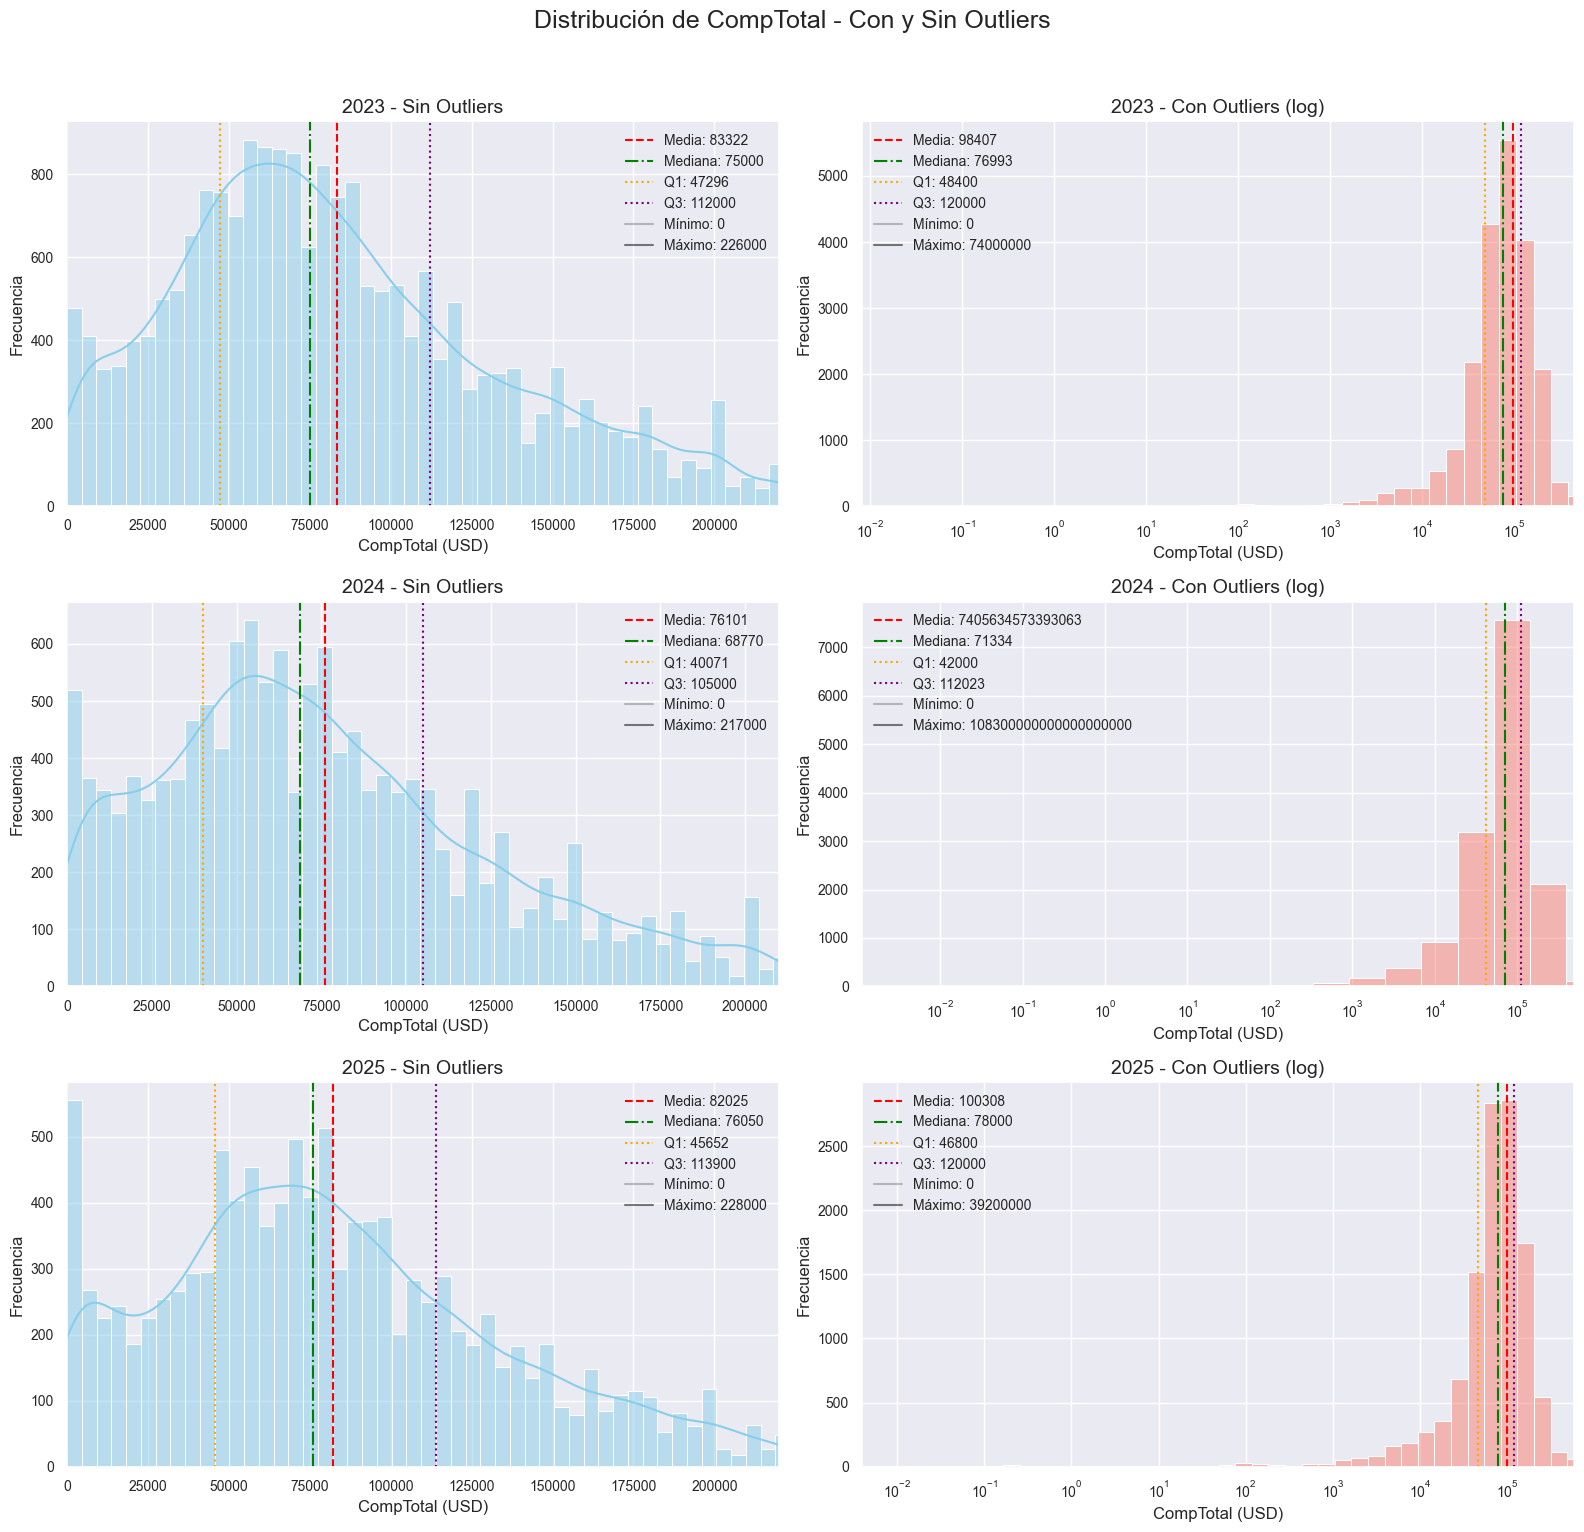

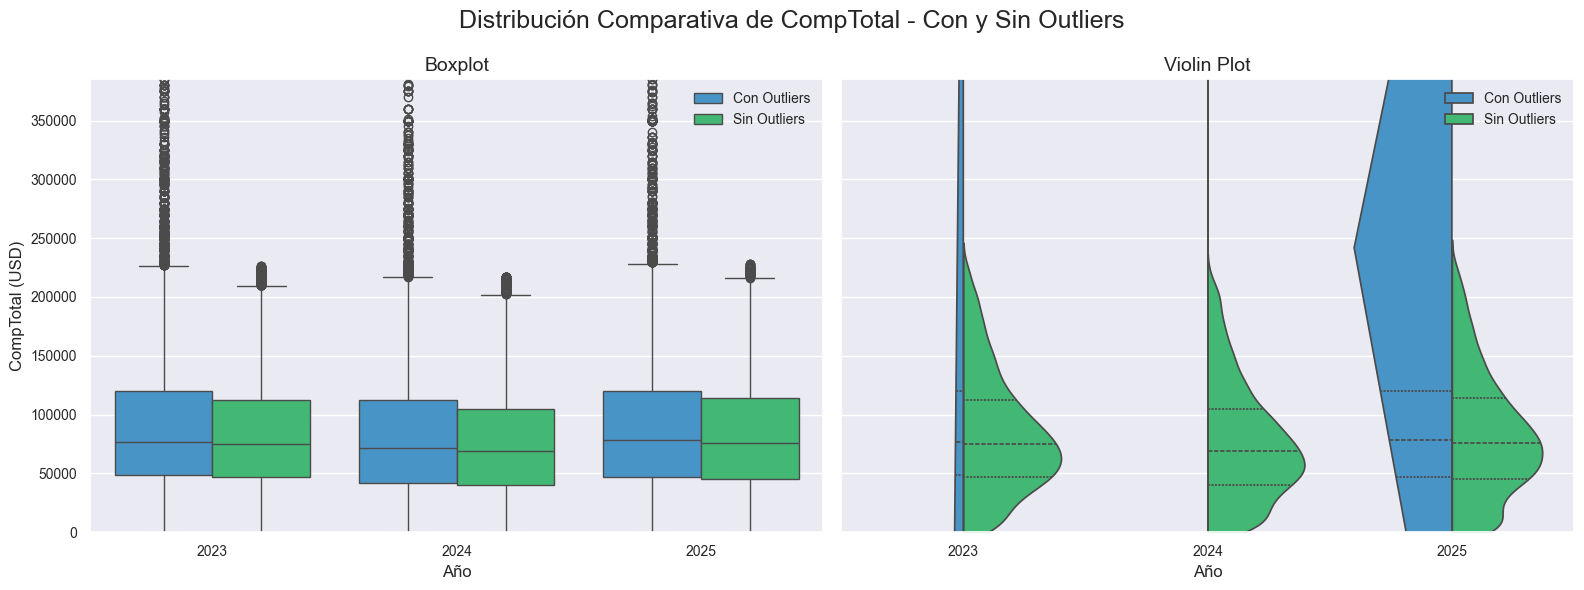

In [270]:
graficar_distribucion_completa(df_con_outliers=df_filtrado, df_sin_outliers=df_filtrado_sin_outliers, anios=ANIOS)

### Categorias Vs Compensación Total

Exploraremos las relaciones entre CompTotal y otras variables clave del dataset.

#### Funciones

In [271]:
import textwrap
import random
import math

VARIABLES_CATEGORICAS_UTILIZADAS = [
  "Age",
  "OrgSize",
  "RemoteWork",
  "DevType",
  "Country",
  "Industry"
]


def wrap_labels(labels, max_length=20):
  """
  Envuelve etiquetas largas en múltiples líneas.

  Args:
      labels: Lista de etiquetas
      max_length: Longitud máxima antes de dividir

  Returns:
      Lista de etiquetas envueltas
  """
  return ['\n'.join(textwrap.wrap(str(label), max_length)) for label in labels]


def crear_boxplots_categoricos(df_filtrado_sin_outliers,
                               top_n=10,
                               min_observaciones=50,
                               figsize=(26, 20),
                               wrap_length=20):
  """
  Crea boxplots comparativos de CompTotal vs variables categóricas para 2023-2025.

  Args:
      df_filtrado_sin_outliers: Diccionario con DataFrames por año
      top_n: Número de categorías a mostrar por variable
      min_observaciones: Mínimo de observaciones requeridas
      figsize: Tamaño de la figura (se ajusta automáticamente si hay más variables)
      wrap_length: Longitud máxima de etiquetas antes de wrap
  """
  # Combinar todos los años en un solo DataFrame
  df_combined = pd.concat([df.assign(Year=year) for year, df in df_filtrado_sin_outliers.items()],
                          ignore_index=True)

  # Paletas de colores para cada gráfico
  paletas = ['Set2', 'Set3', 'Pastel1', 'Pastel2', 'Dark2', 'Paired']
  random.shuffle(paletas)

  # Calcular grid dinámico basado en número de variables
  n_variables = len(VARIABLES_CATEGORICAS_UTILIZADAS)
  n_cols = 2
  n_rows = math.ceil(n_variables / n_cols)

  # Ajustar figsize dinámicamente
  altura_por_fila = figsize[1] / 2
  figsize_dinamico = (figsize[0], altura_por_fila * n_rows)

  # Crear figura con grid dinámico
  fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize_dinamico)
  fig.suptitle('Distribución de Compensación Total por Variable Categórica (2023-2025)',
               fontsize=20, fontweight='bold', y=0.998)

  # Aplanar axes solo si hay más de un subplot
  if n_variables > 1:
    axes = axes.flatten() if n_rows > 1 or n_cols > 1 else [axes]
  else:
    axes = [axes]

  for idx, variable in enumerate(VARIABLES_CATEGORICAS_UTILIZADAS):
    ax = axes[idx]

    # Obtener top N categorías con al menos min_observaciones respuestas
    top_cats = df_combined[variable].value_counts()
    top_cats = top_cats[top_cats >= min_observaciones].head(top_n).index
    df_plot = df_combined[df_combined[variable].isin(top_cats)].copy()

    # Ordenar por mediana de CompTotal
    order = df_plot.groupby(variable)['CompTotal'].median().sort_values(ascending=False).index

    # Aplicar wrap a las etiquetas
    wrapped_labels = wrap_labels(order, wrap_length)
    df_plot['VariableWrapped'] = df_plot[variable].map(dict(zip(order, wrapped_labels)))
    order_wrapped = [dict(zip(order, wrapped_labels))[cat] for cat in order]

    # Crear boxplot con hue='Year' y paleta aleatoria
    sns.boxplot(data=df_plot, y='VariableWrapped', x='CompTotal', hue='Year',
                order=order_wrapped, ax=ax, palette=paletas[idx % len(paletas)])

    ax.set_title(f'{variable} - Top {top_n} Categorías con Mayor Compensación',
                 fontsize=15, fontweight='bold', pad=12)
    ax.set_xlabel('Compensación Total Anual (USD)', fontsize=13, fontweight='bold')
    ax.set_ylabel(variable, fontsize=13, fontweight='bold')
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x / 1000:.0f}K'))
    ax.grid(True, alpha=0.3, axis='x', linestyle='--')

    # Añadir línea de mediana general
    mediana_general = df_combined['CompTotal'].median()
    ax.axvline(mediana_general, color='red', linestyle='--', linewidth=2.5,
               alpha=0.8, label=f'Mediana Global: ${mediana_general:,.0f}')

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels, loc='lower right', fontsize=10,
              title='Año', title_fontsize=11, framealpha=0.95)

  # Ocultar subplots vacíos si el número de variables no es múltiplo de n_cols
  total_subplots = n_rows * n_cols
  for idx in range(n_variables, total_subplots):
    axes[idx].axis('off')

  plt.tight_layout()
  plt.show()
  plt.close()


def crear_grafico_evolucion_por_variable(df_combined,
                                         variable,
                                         top_n=5,
                                         min_observaciones=50):
  """
  Crea un gráfico de evolución temporal para una variable específica.

  Args:
      df_combined: DataFrame combinado con todos los años
      variable: Variable categórica a analizar
      top_n: Número de categorías top a mostrar
      min_observaciones: Mínimo de observaciones requeridas

  Returns:
      DataFrame con datos de evolución
  """
  evol_data = []

  for year in sorted(df_combined['Year'].unique()):
    df_year = df_combined[df_combined['Year'] == year]

    # Top N categorías por mediana
    top_cats = df_year.groupby(variable)['CompTotal'].agg(['median', 'count'])
    top_cats = top_cats[top_cats['count'] >= min_observaciones].nlargest(top_n, 'median')

    for cat, row in top_cats.iterrows():
      evol_data.append({
        'Variable': variable,
        'Categoría': str(cat),
        'Year': year,
        'Mediana': row['median'],
        'Count': row['count']
      })

  return pd.DataFrame(evol_data)


def crear_graficos_evolucion_temporal(df_filtrado_sin_outliers,
                                      top_n=5,
                                      min_observaciones=50,
                                      figsize_por_variable=(26, 9),
                                      wrap_length=35):
  """
  Crea gráficos de evolución temporal separados para cada variable categórica.

  Args:
      df_filtrado_sin_outliers: Diccionario con DataFrames por año
      top_n: Número de categorías top a mostrar por variable
      min_observaciones: Mínimo de observaciones requeridas
      figsize_por_variable: Tamaño de figura para cada variable
      wrap_length: Longitud máxima para labels en leyenda
  """
  # Combinar todos los años
  df_combined = pd.concat([df.assign(Year=year) for year, df in df_filtrado_sin_outliers.items()],
                          ignore_index=True)

  # Paletas de colores diferentes para cada variable
  paletas_disponibles = ['tab10', 'tab20', 'Set1', 'Set2', 'Dark2', 'Paired', 'husl', 'deep']

  for idx, variable in enumerate(VARIABLES_CATEGORICAS_UTILIZADAS):
    # Obtener datos de evolución
    df_evol = crear_grafico_evolucion_por_variable(
      df_combined,
      variable,
      top_n=top_n,
      min_observaciones=min_observaciones
    )

    if df_evol.empty:
      continue

    # Aplicar wrap a categorías largas
    df_evol['CategoríaWrapped'] = df_evol['Categoría'].apply(
      lambda x: '\n'.join(textwrap.wrap(str(x), wrap_length))
    )

    # Crear figura individual
    fig, ax = plt.subplots(figsize=figsize_por_variable)

    # Seleccionar paleta
    paleta = paletas_disponibles[idx % len(paletas_disponibles)]

    # Crear lineplot
    sns.lineplot(data=df_evol, x='Year', y='Mediana', hue='CategoríaWrapped',
                 marker='o', linewidth=3, markersize=12, ax=ax, palette=paleta)

    ax.set_title(f'Evolución Temporal de Compensación Mediana - {variable} (Top {top_n} Categorías)',
                 fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel('Año', fontsize=15, fontweight='bold')
    ax.set_ylabel('Compensación Mediana Anual (USD)', fontsize=15, fontweight='bold')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x / 1000:.0f}K'))
    ax.grid(True, alpha=0.4, linestyle='--', linewidth=0.8)

    # Mejorar leyenda
    ax.legend(title=f'{variable} - Categoría', bbox_to_anchor=(1.02, 1), loc='upper left',
              fontsize=11, title_fontsize=12, framealpha=0.95)

    # Ajustar ticks del eje x
    ax.tick_params(axis='both', labelsize=12)

    plt.tight_layout()
    plt.show()
    plt.close()

In [272]:
def preparar_datos_categoricos(df_filtrado_sin_outliers, variable,
                               top_n=10, min_observaciones=50,
                               explotar_separador=None):
  """
  Prepara y filtra datos para análisis categórico.

  Args:
      df_filtrado_sin_outliers: Diccionario con DataFrames por año
      variable: Variable categórica a analizar
      top_n: Número de categorías a mostrar
      min_observaciones: Mínimo de observaciones requeridas
      explotar_separador: Separador para dividir valores múltiples (';' por defecto para Employment)

  Returns:
      DataFrame filtrado y procesado, orden de categorías
  """
  # Combinar todos los años
  df_combined = pd.concat([df.assign(Year=year) for year, df in df_filtrado_sin_outliers.items()],
                          ignore_index=True)

  # Filtrar valores válidos
  df_plot = df_combined[df_combined[variable].notna()].copy()

  # Explotar valores múltiples si es necesario
  if explotar_separador:
    df_plot[variable] = df_plot[variable].str.split(explotar_separador)
    df_plot = df_plot.explode(variable)
    df_plot[variable] = df_plot[variable].str.strip()
    df_plot = df_plot[df_plot[variable] != '']

  # Obtener top N categorías por frecuencia
  top_cats = df_plot[variable].value_counts()
  top_cats = top_cats[top_cats >= min_observaciones].head(top_n).index
  df_plot = df_plot[df_plot[variable].isin(top_cats)].copy()

  # Ordenar por mediana de CompTotal
  orden = df_plot.groupby(variable)['CompTotal'].median().sort_values(ascending=False).index

  return df_plot, orden


def configurar_ejes_compensacion(ax, variable, titulo_tipo=''):
  """
  Configura ejes y formato estándar para gráficos de compensación.

  Args:
      ax: Axes de matplotlib
      variable: Nombre de la variable
      titulo_tipo: Tipo de gráfico para el título
  """
  ax.set_title(f'{titulo_tipo}Compensación por {variable} (2023-2025)',
               fontsize=20, fontweight='bold', pad=20)
  ax.set_xlabel('Compensación Total Anual (USD)', fontsize=15, fontweight='bold')
  ax.set_ylabel(variable, fontsize=15, fontweight='bold')
  ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x / 1000:.0f}K'))
  ax.tick_params(axis='both', labelsize=12)


def crear_grafico_categorico_comparativo(df_filtrado_sin_outliers, variable,
                                         top_n=10, min_observaciones=50,
                                         figsize=(24, 12), explotar=False):
  """
  Crea barplot comparativo de compensación mediana por variable categórica.

  Args:
      df_filtrado_sin_outliers: Diccionario con DataFrames por año
      variable: Variable categórica a analizar
      top_n: Número de categorías a mostrar
      min_observaciones: Mínimo de observaciones requeridas
      figsize: Tamaño de la figura
      explotar: Si True, separa valores múltiples con ';'
  """
  # Preparar datos
  separador = ';' if explotar else None
  df_plot, orden = preparar_datos_categoricos(df_filtrado_sin_outliers, variable,
                                              top_n, min_observaciones, separador)

  # Calcular medianas por categoría y año
  medianas = (df_plot.groupby([variable, 'Year'], observed=True)['CompTotal']
              .median()
              .reset_index(name='Mediana'))

  # Crear figura
  fig, ax = plt.subplots(figsize=figsize)

  # Barplot con seaborn
  sns.barplot(data=medianas, y=variable, x='Mediana', hue='Year',
              order=orden, ax=ax, palette='viridis',
              edgecolor='black', linewidth=0.5)

  configurar_ejes_compensacion(ax, variable, 'Mediana de ')
  ax.grid(True, alpha=0.4, axis='x', linestyle='--')

  # Añadir valores en las barras
  for container in ax.containers:
    ax.bar_label(container, fmt='$%.0fK', label_type='edge',
                 fontsize=9, padding=3)

  ax.legend(title='Año', fontsize=12, title_fontsize=13,
            loc='lower right', framealpha=0.95)

  plt.tight_layout()
  plt.show()
  plt.close()


def crear_violin_categorico(df_filtrado_sin_outliers, variable,
                            top_n=8, min_observaciones=50,
                            figsize=(24, 14), explotar=False):
  """
  Crea violin plots de distribución de compensación por variable categórica.

  Args:
      df_filtrado_sin_outliers: Diccionario con DataFrames por año
      variable: Variable categórica a analizar
      top_n: Número de categorías a mostrar
      min_observaciones: Mínimo de observaciones requeridas
      figsize: Tamaño de la figura
      explotar: Si True, separa valores múltiples con ';'
  """
  # Preparar datos
  separador = ';' if explotar else None
  df_plot, orden = preparar_datos_categoricos(df_filtrado_sin_outliers, variable,
                                              top_n, min_observaciones, separador)

  # Crear figura
  fig, ax = plt.subplots(figsize=figsize)

  # Violin plot con seaborn
  sns.violinplot(data=df_plot, y=variable, x='CompTotal', hue='Year',
                 order=orden, ax=ax, palette='Set2',
                 split=False, inner='quartile', density_norm='width')

  configurar_ejes_compensacion(ax, variable, 'Distribución de ')
  ax.grid(True, alpha=0.3, axis='x', linestyle='--')

  ax.legend(title='Año', fontsize=12, title_fontsize=13,
            loc='lower right', framealpha=0.95)

  plt.tight_layout()
  plt.show()
  plt.close()


def crear_heatmap_categorico(df_filtrado_sin_outliers, variable,
                             top_n=12, min_observaciones=50,
                             figsize=(18, 10), explotar=False):
  """
  Crea heatmap de compensación mediana por variable categórica y año.

  Args:
      df_filtrado_sin_outliers: Diccionario con DataFrames por año
      variable: Variable categórica a analizar
      top_n: Número de categorías a mostrar
      min_observaciones: Mínimo de observaciones requeridas
      figsize: Tamaño de la figura
      explotar: Si True, separa valores múltiples con ';'
  """
  # Preparar datos
  separador = ';' if explotar else None
  df_plot, _ = preparar_datos_categoricos(df_filtrado_sin_outliers, variable,
                                          top_n, min_observaciones, separador)

  # Crear tabla pivote con seaborn
  pivot = df_plot.pivot_table(values='CompTotal',
                              index=variable,
                              columns='Year',
                              aggfunc='median')

  # Ordenar por mediana promedio
  pivot = pivot.loc[pivot.mean(axis=1).sort_values(ascending=False).index]

  # Crear heatmap
  fig, ax = plt.subplots(figsize=figsize)

  sns.heatmap(pivot, annot=True, fmt='.0f', cmap='YlGnBu',
              linewidths=1, linecolor='white', ax=ax,
              cbar_kws={'label': 'Compensación Mediana (USD)', 'shrink': 0.8})

  ax.set_title(f'Mapa de Calor: Compensación Mediana por {variable} (2023-2025)',
               fontsize=18, fontweight='bold', pad=20)
  ax.set_xlabel('Año', fontsize=14, fontweight='bold')
  ax.set_ylabel(variable, fontsize=14, fontweight='bold')
  ax.tick_params(axis='both', labelsize=11)

  plt.tight_layout()
  plt.show()
  plt.close()

#### BoxPlots
Analizamos cómo varía CompTotal en categorias claves y sus valores atípicos.

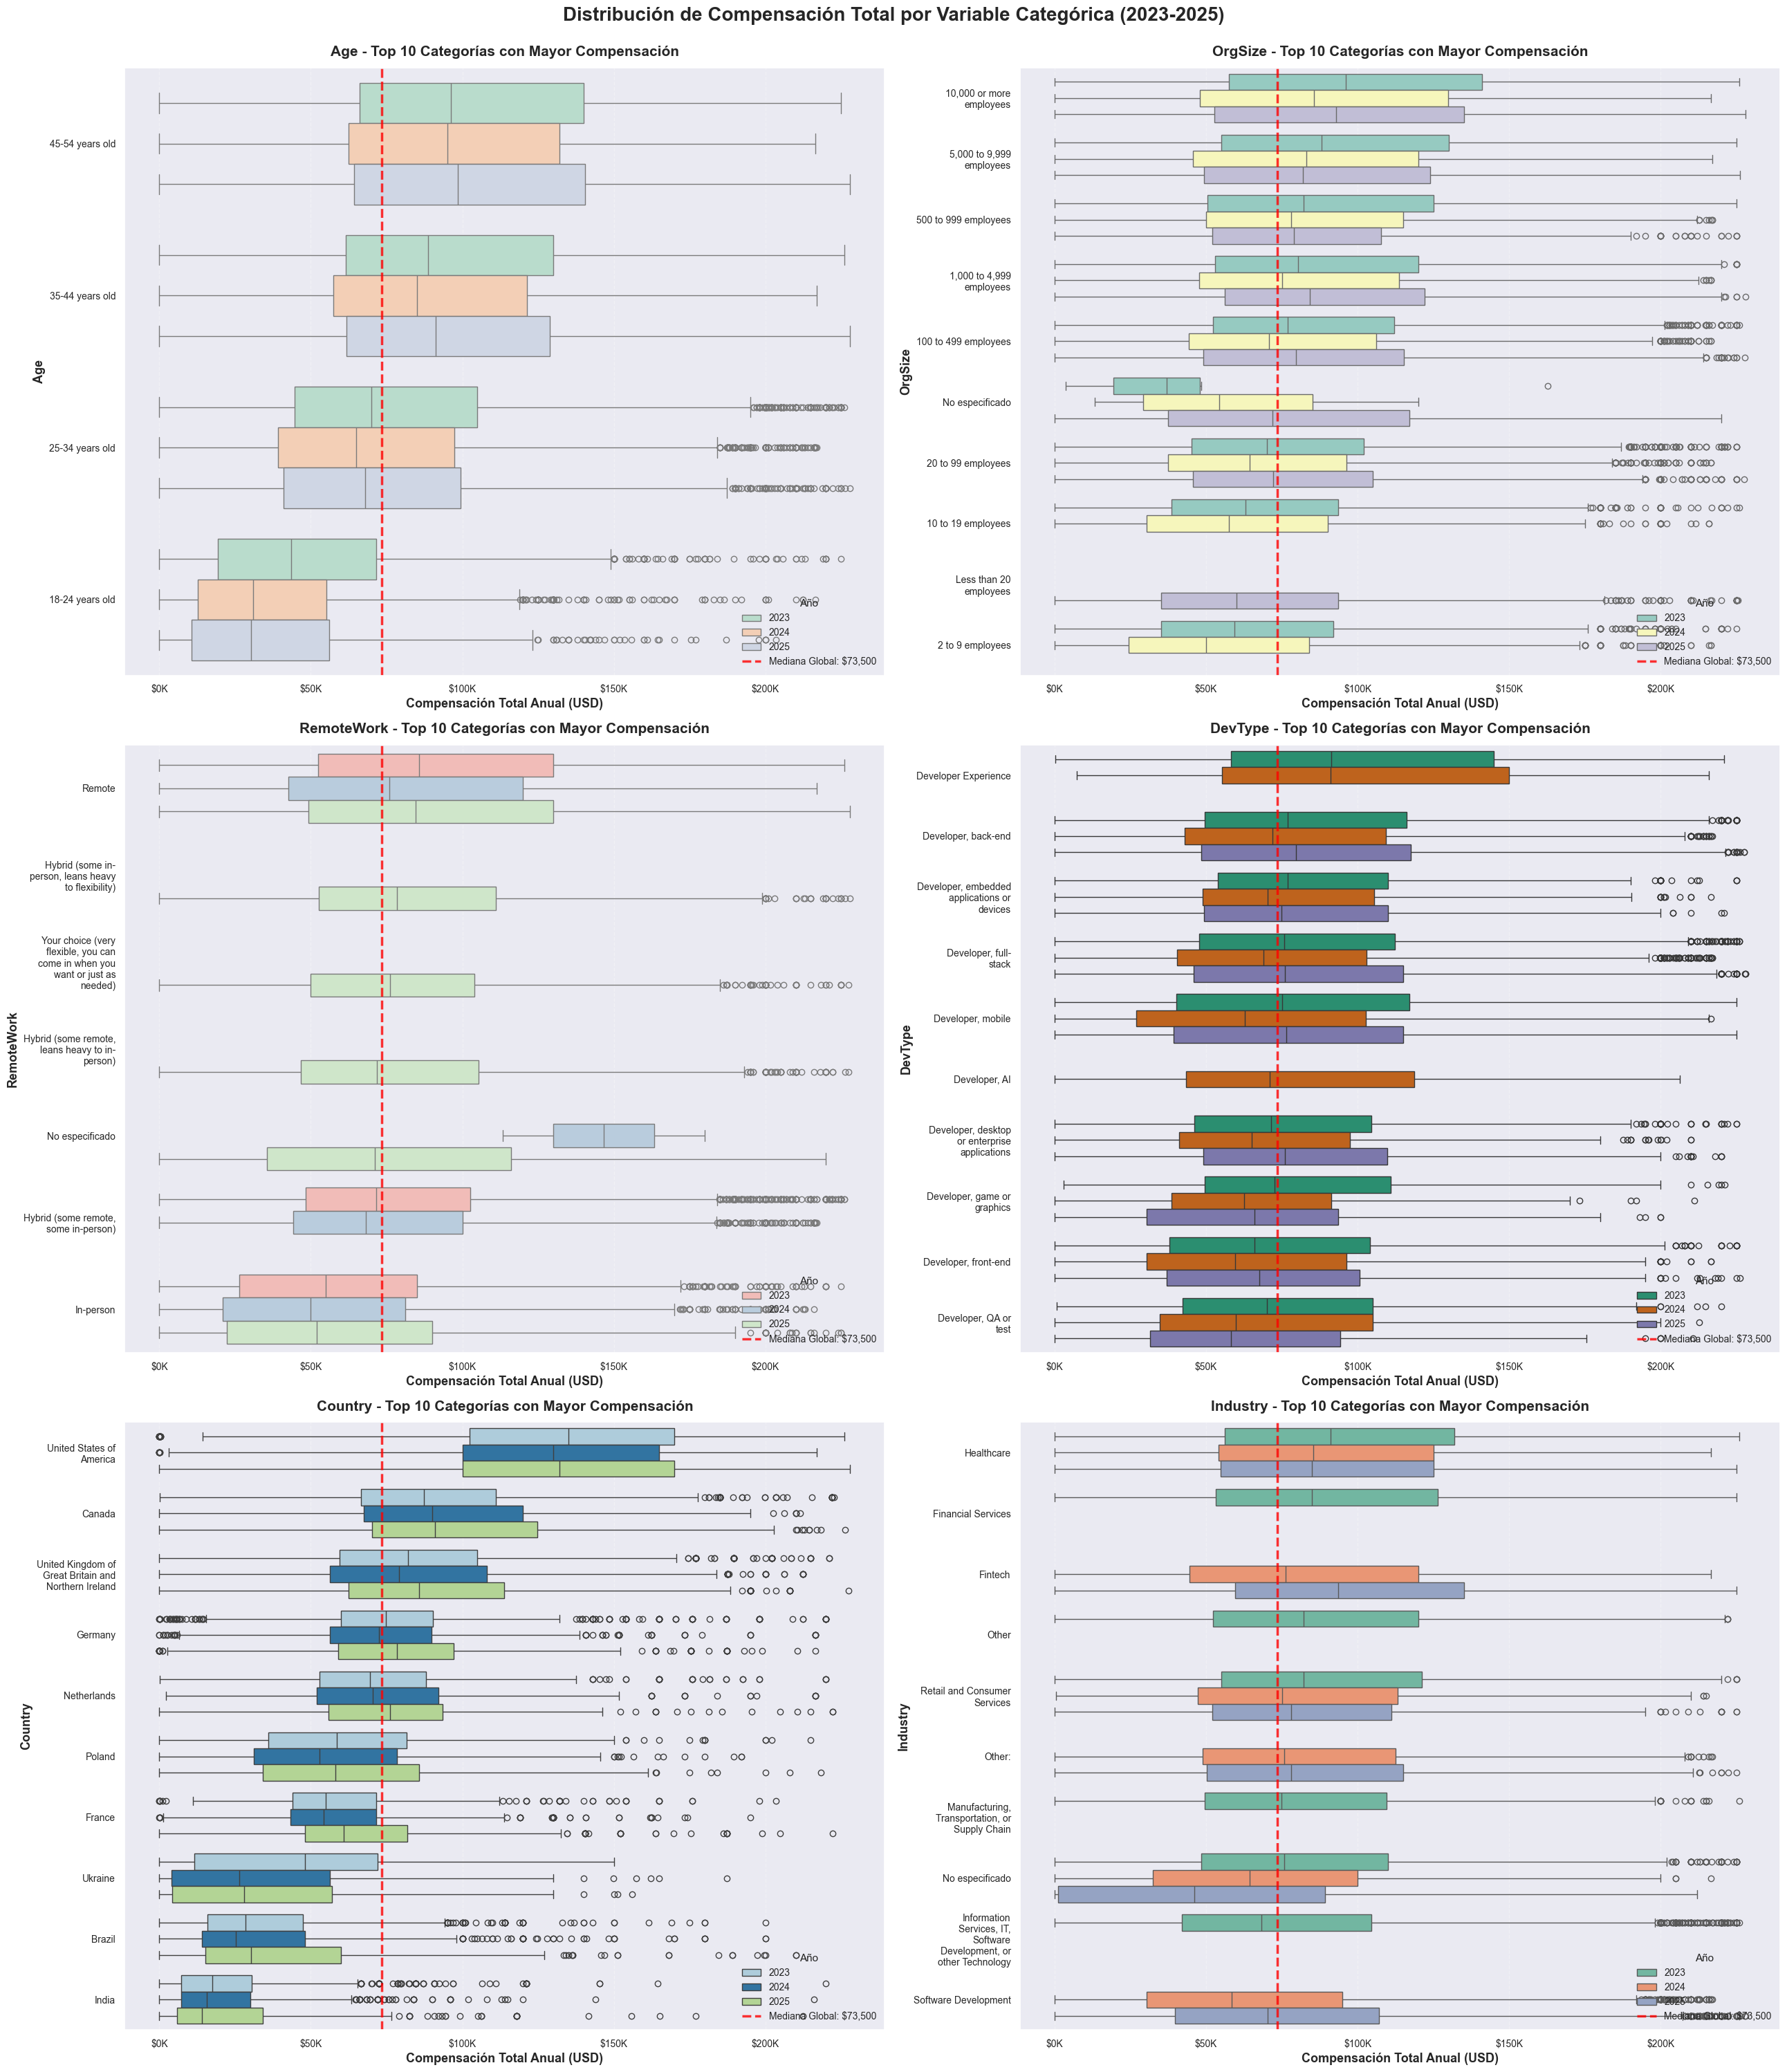

In [273]:
crear_boxplots_categoricos(df_filtrado_sin_outliers)

#### LinePlots

Analizamos como varía la mediana de compensación total a lo largo de los años en categorías claves

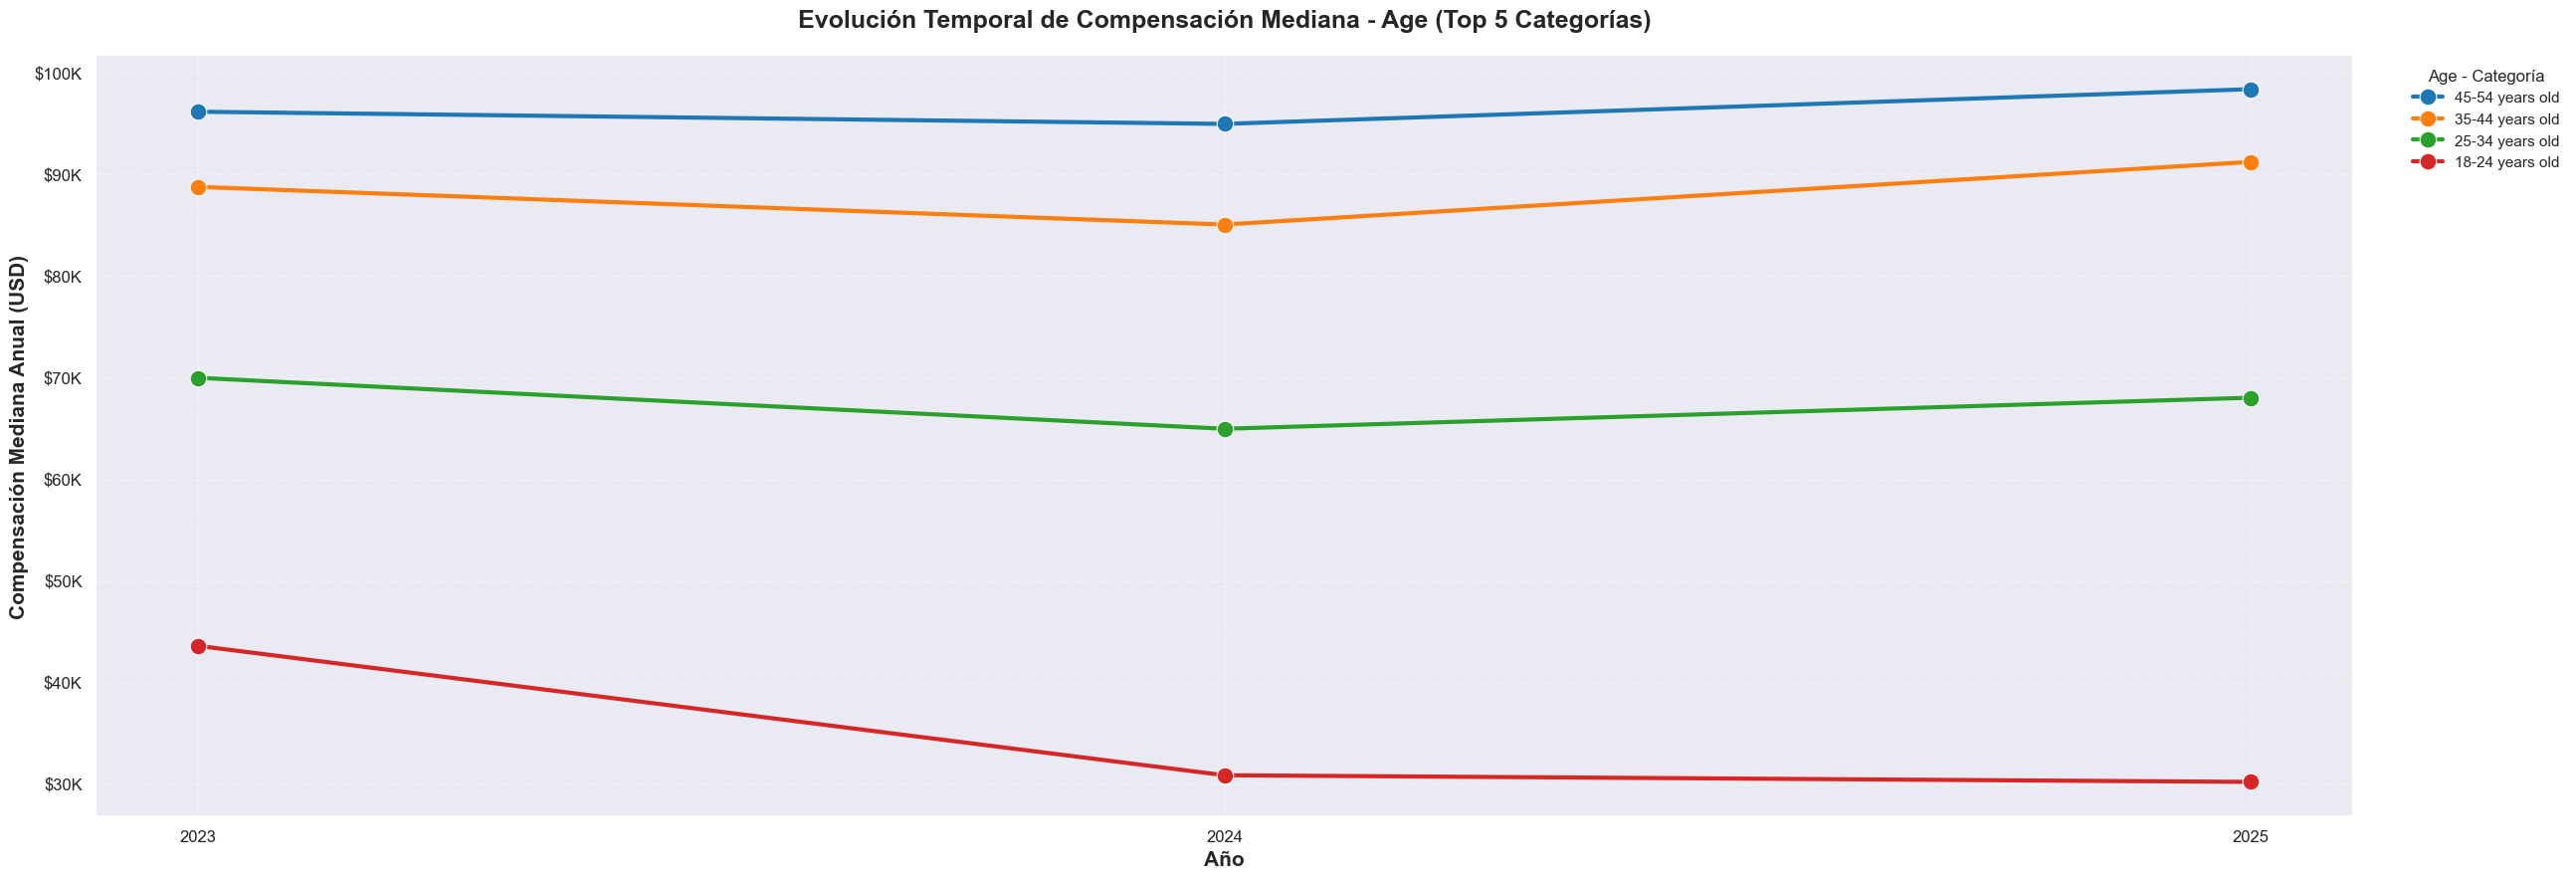

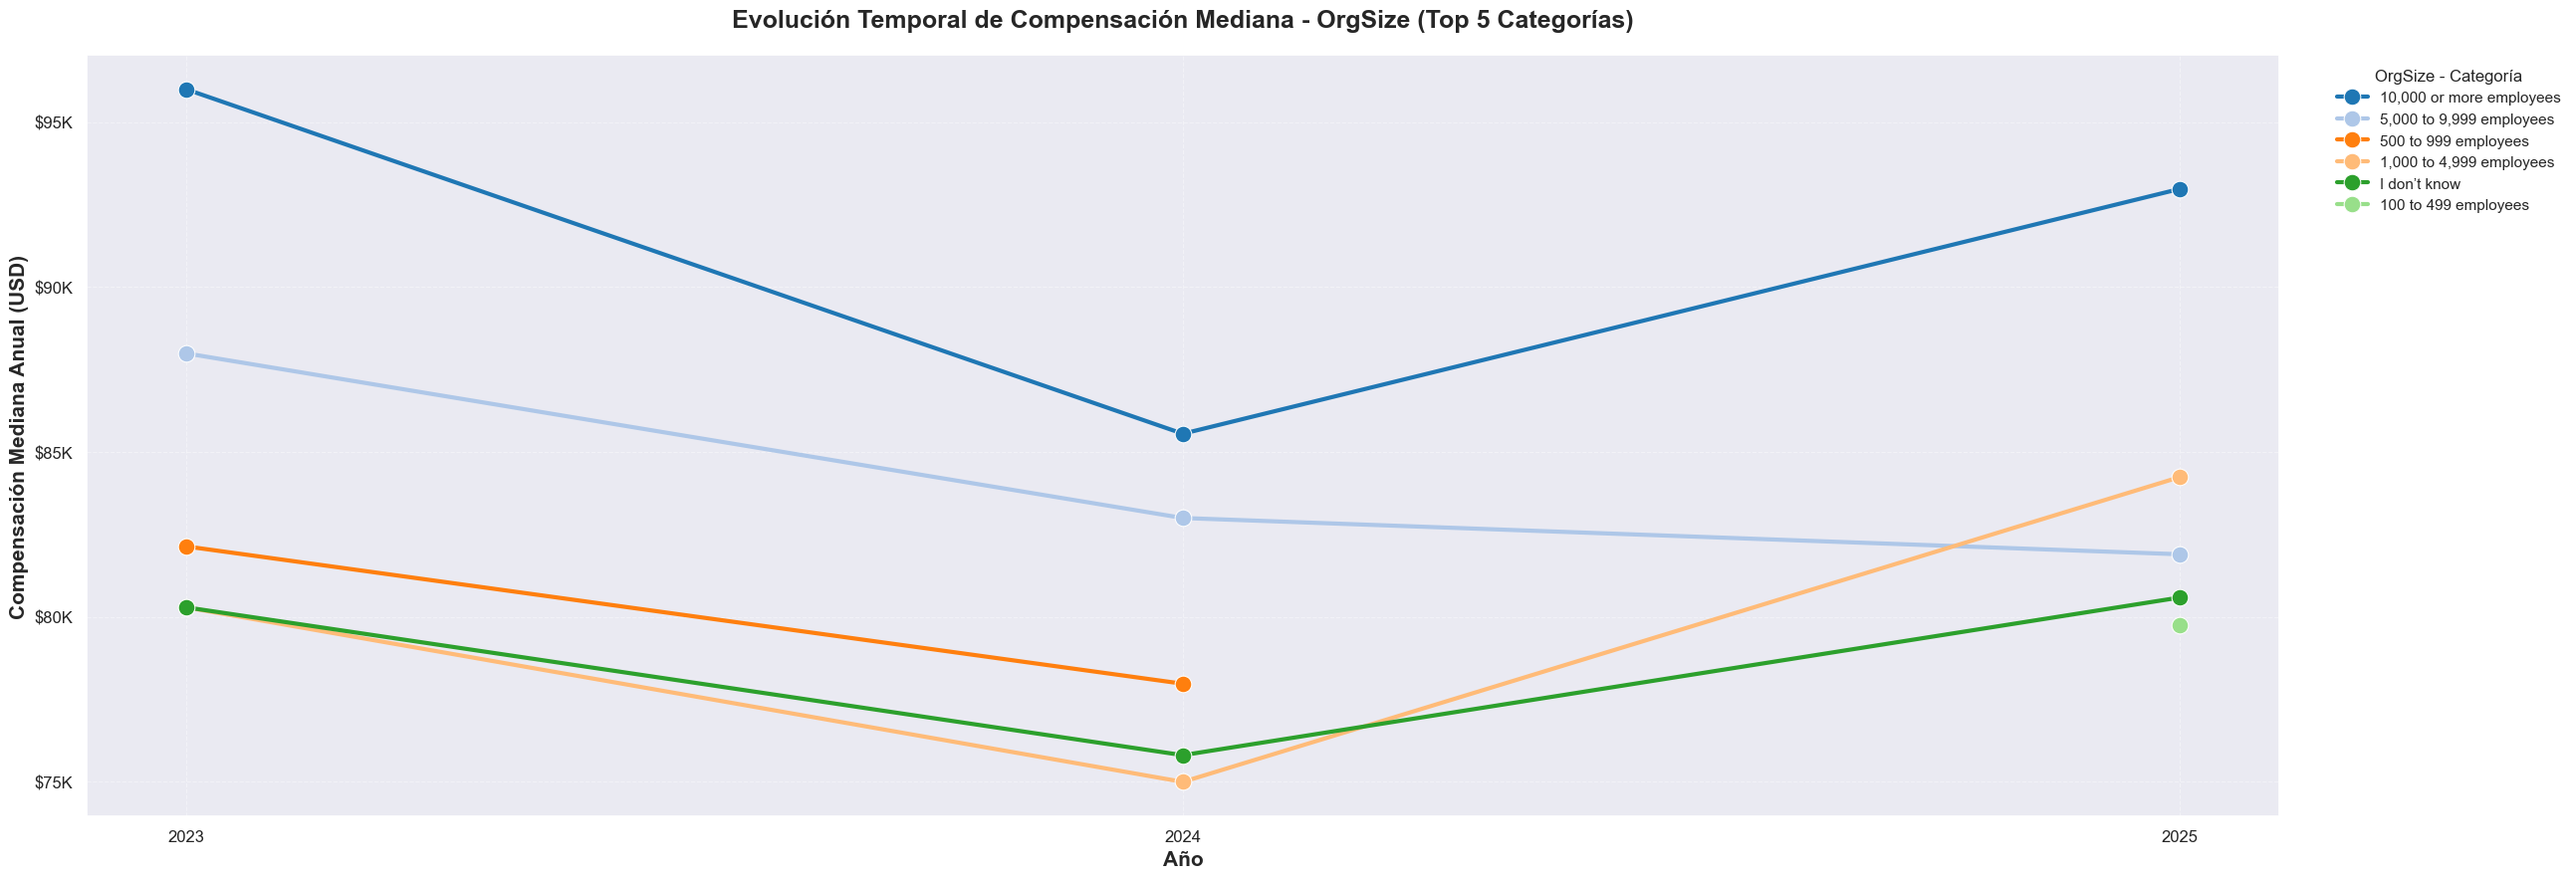

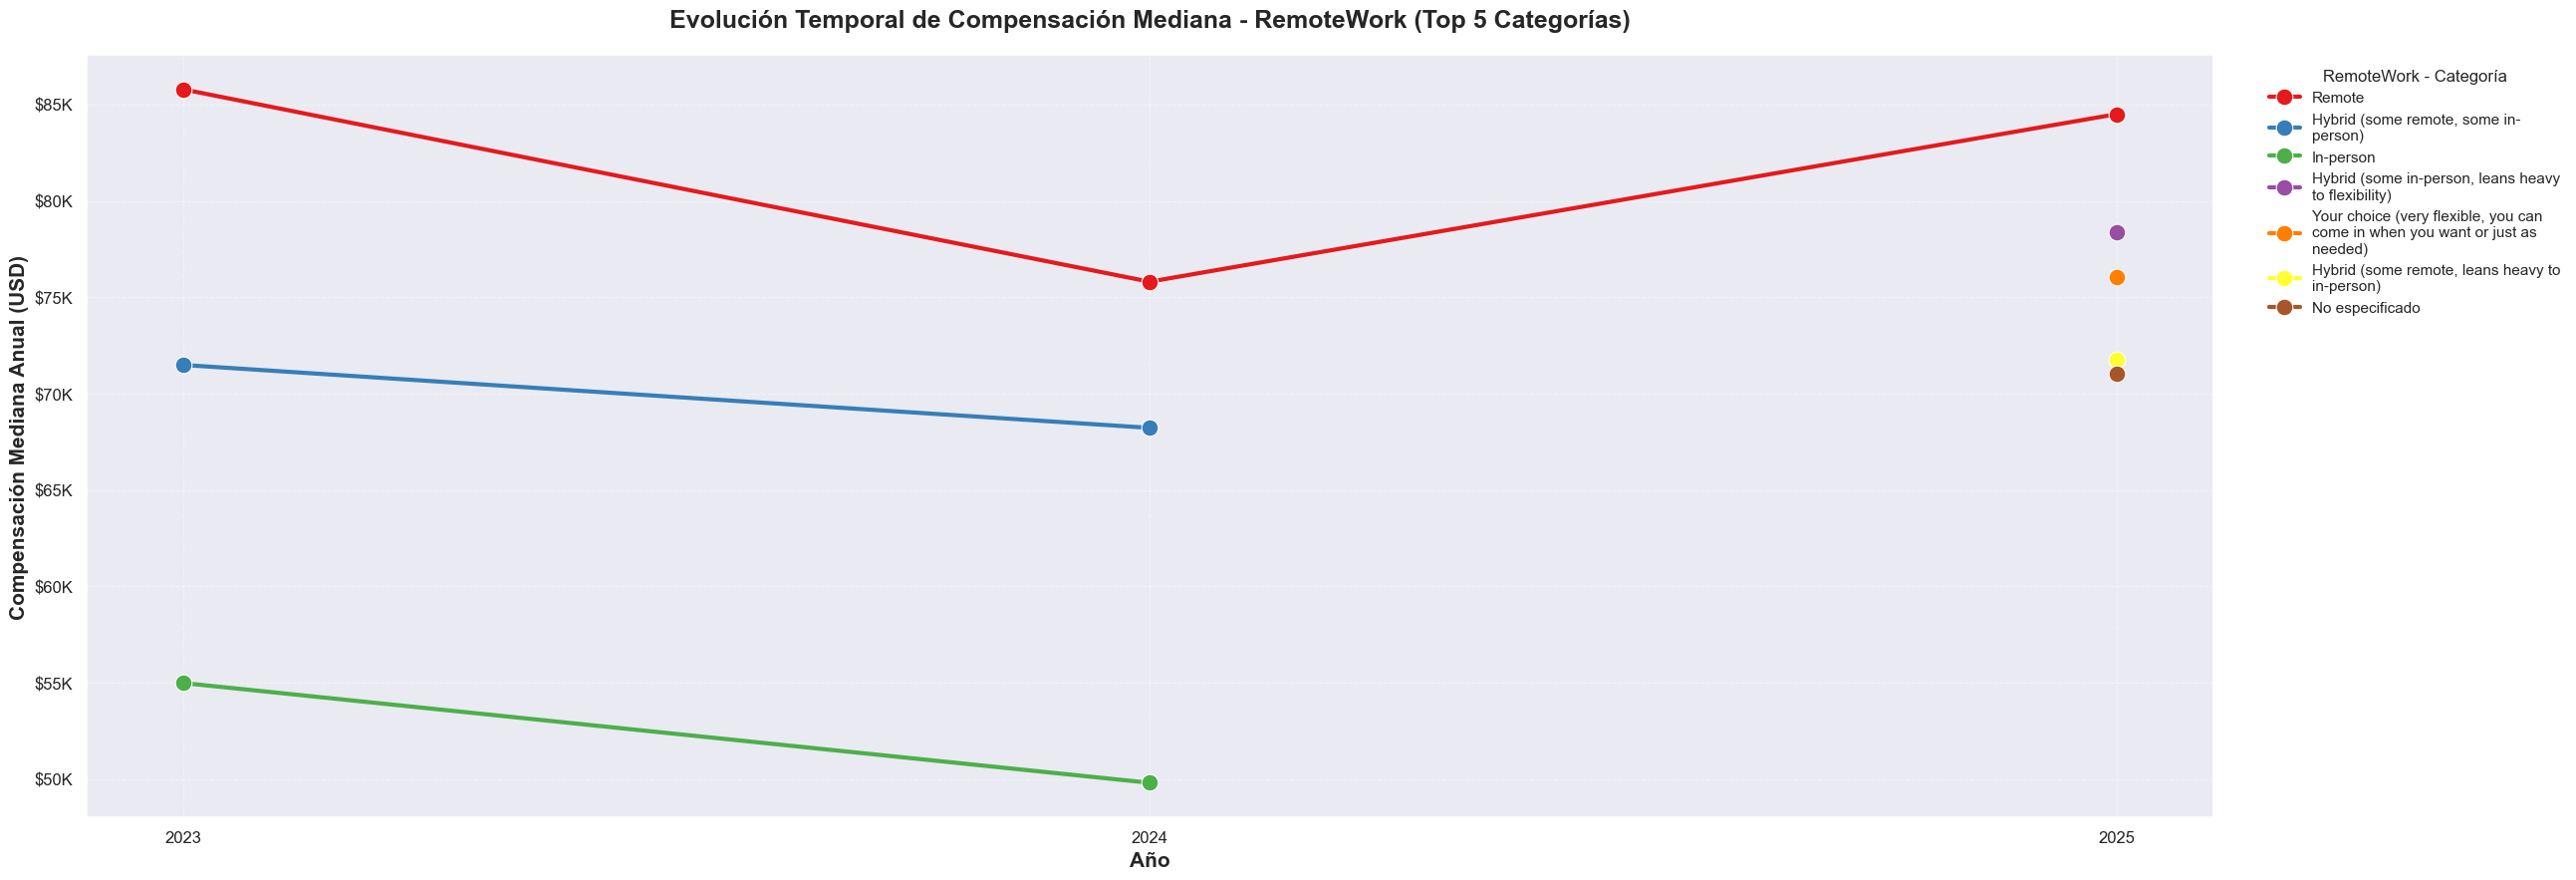

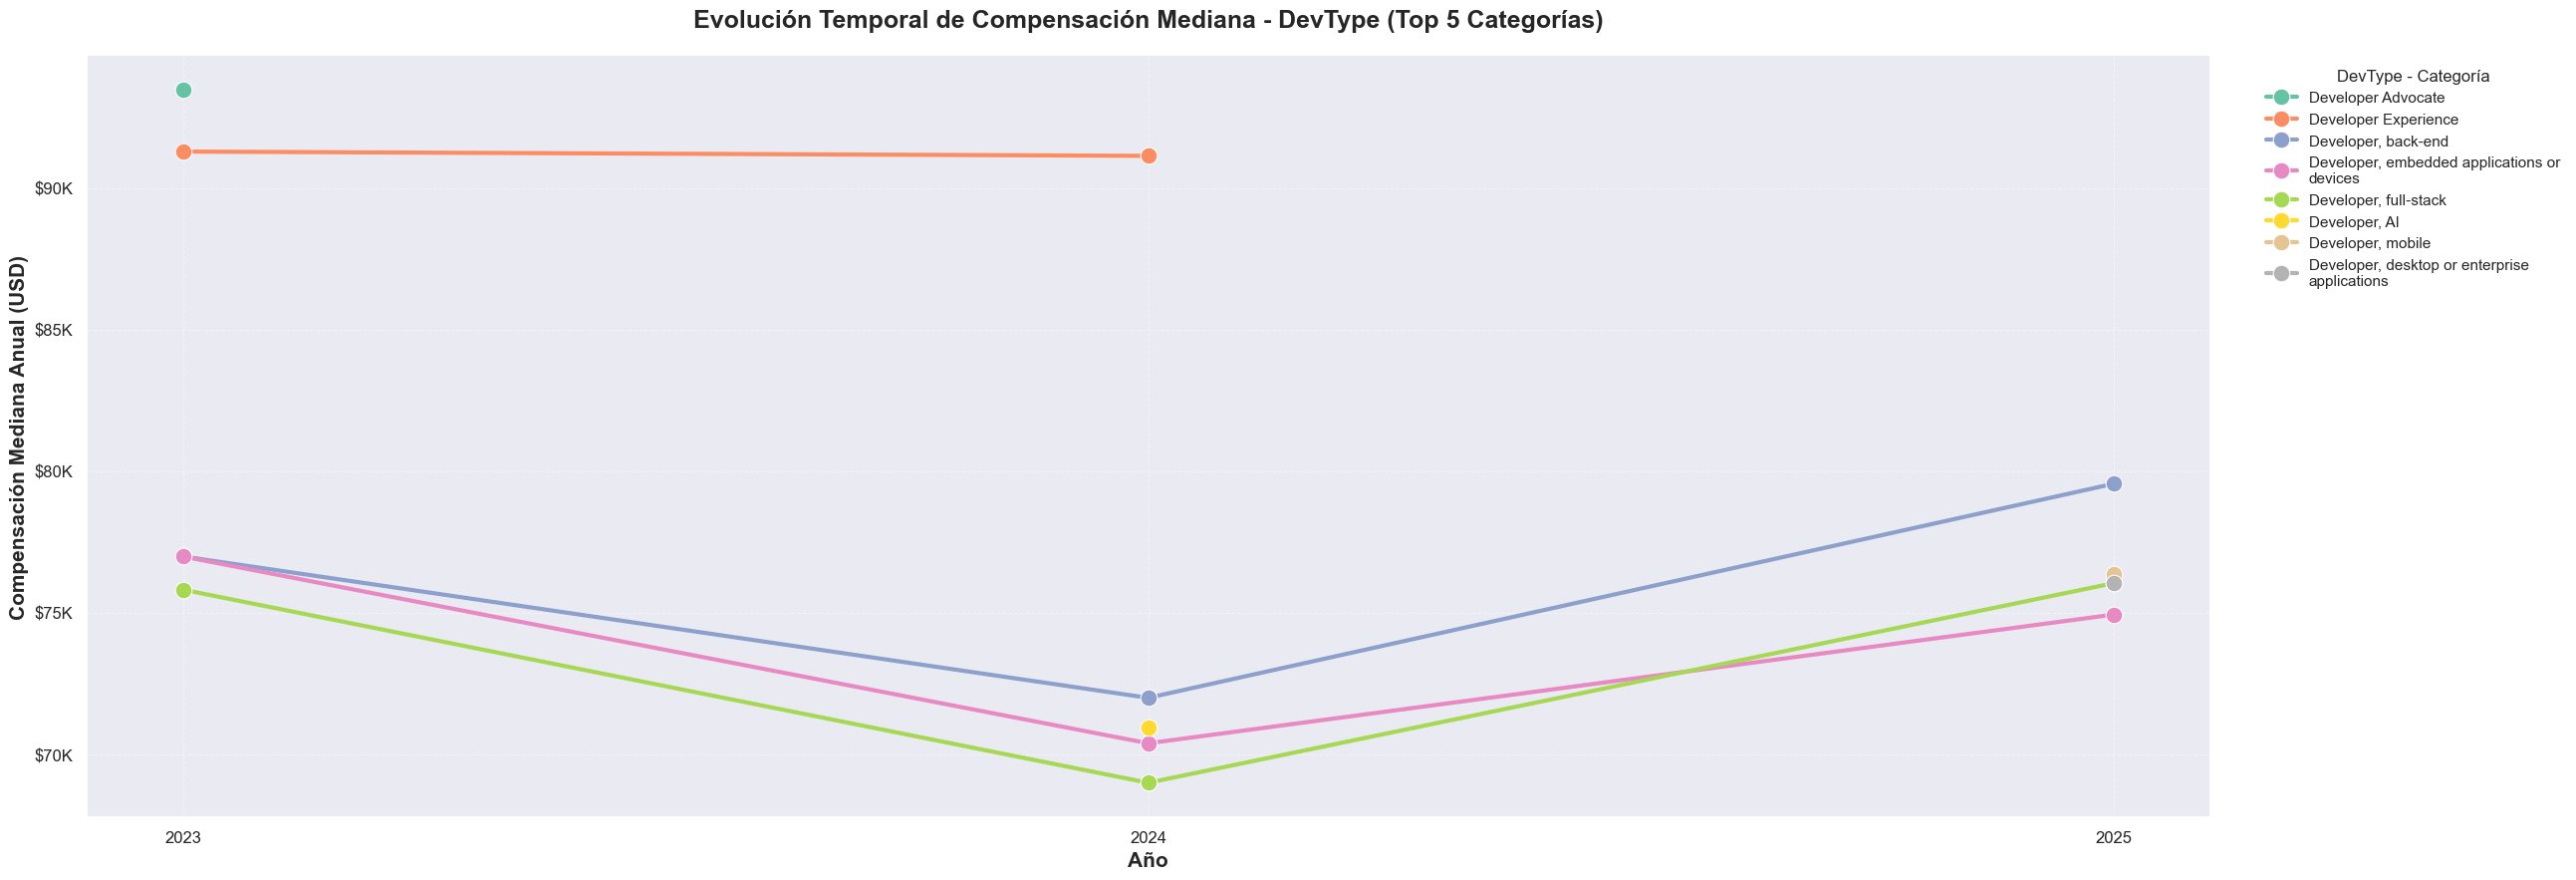

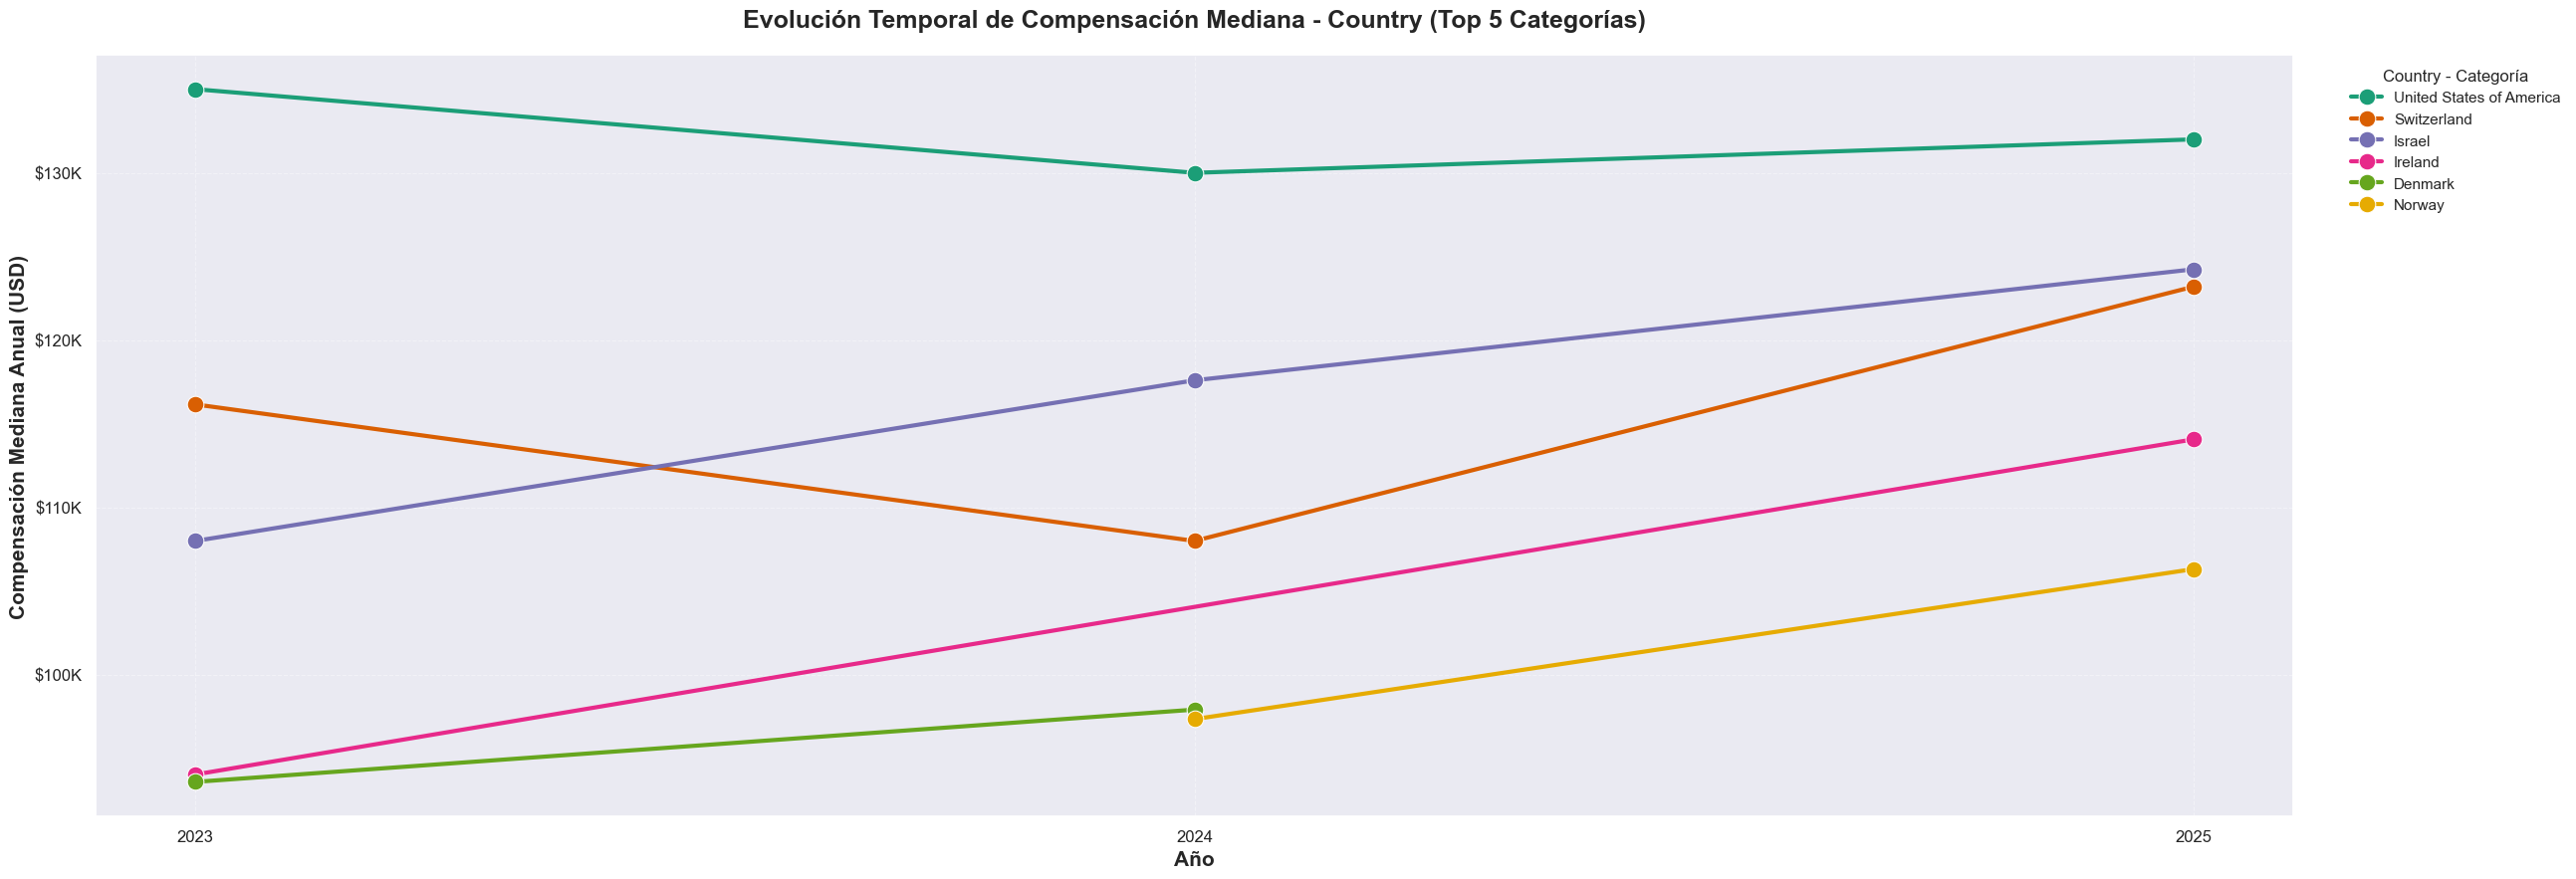

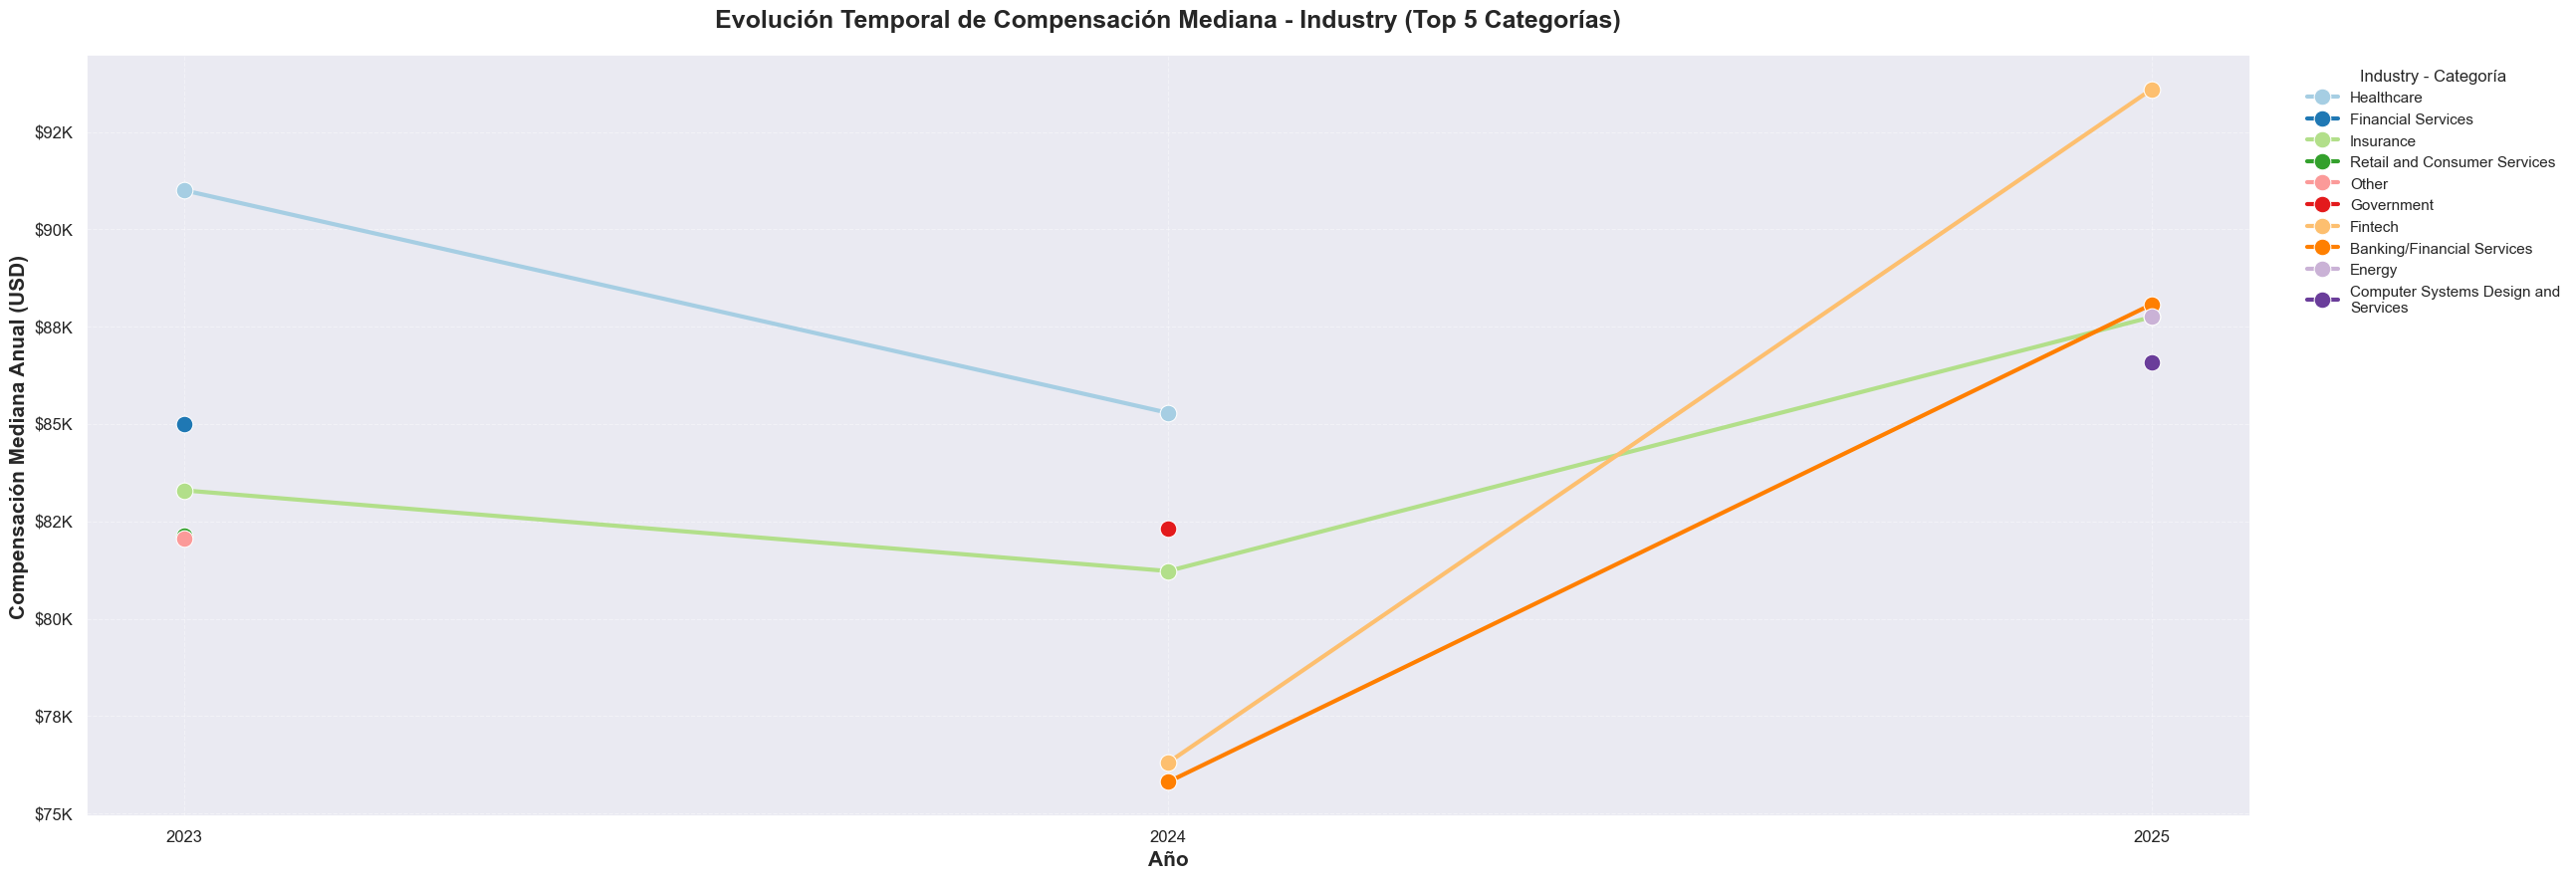

In [274]:
crear_graficos_evolucion_temporal(df_filtrado_sin_outliers)

#### BarPlot

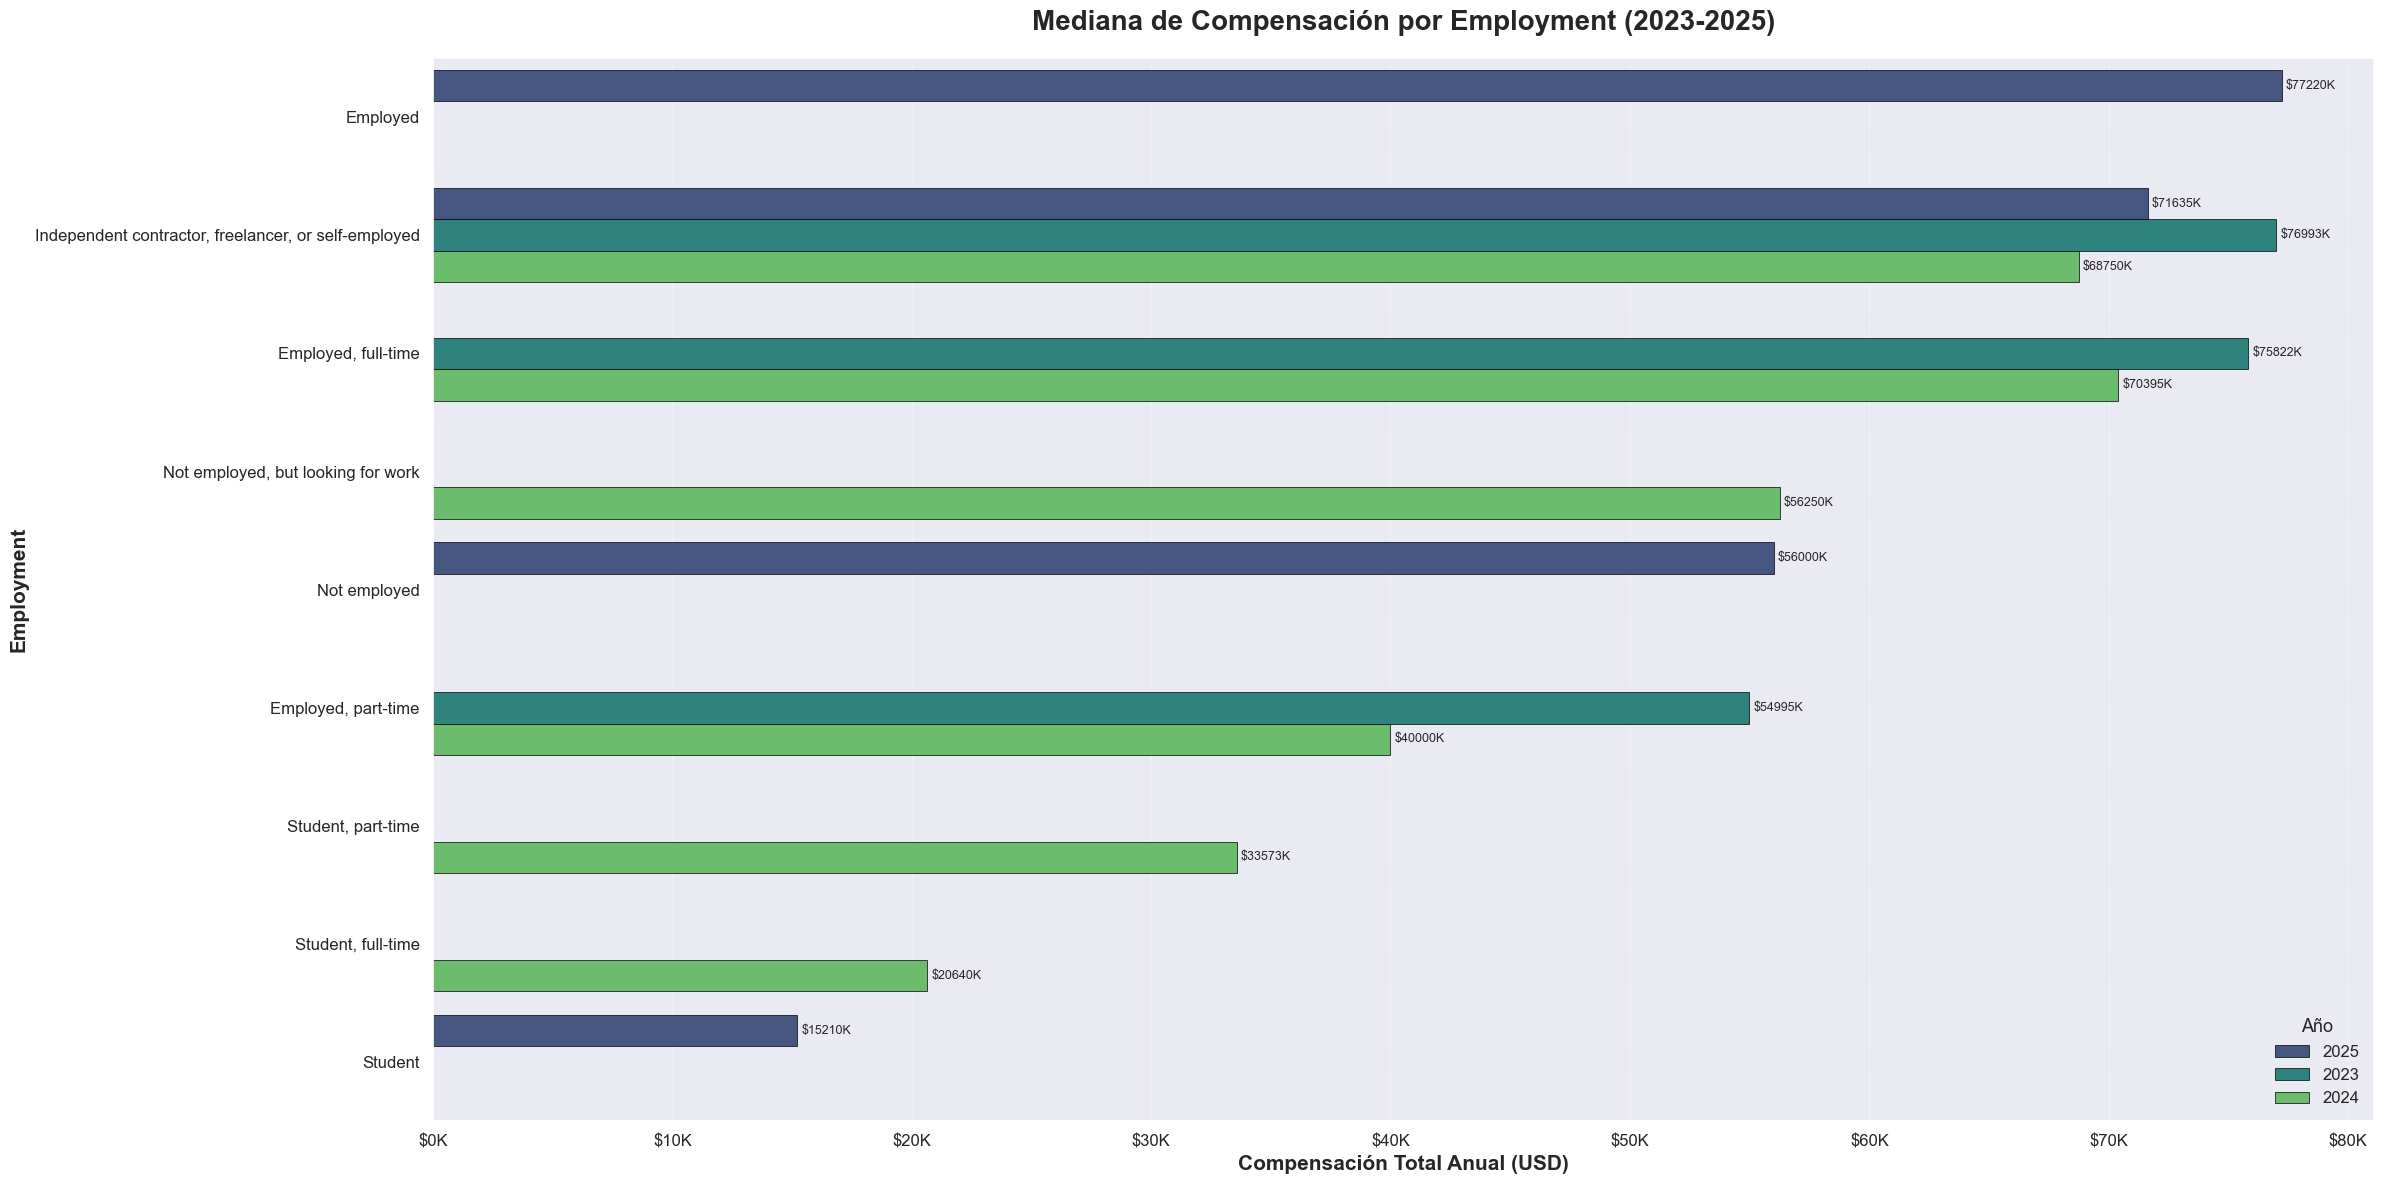

In [275]:
# Para Employment
crear_grafico_categorico_comparativo(df_filtrado_sin_outliers, 'Employment', explotar=True)

#### ViolinPlot

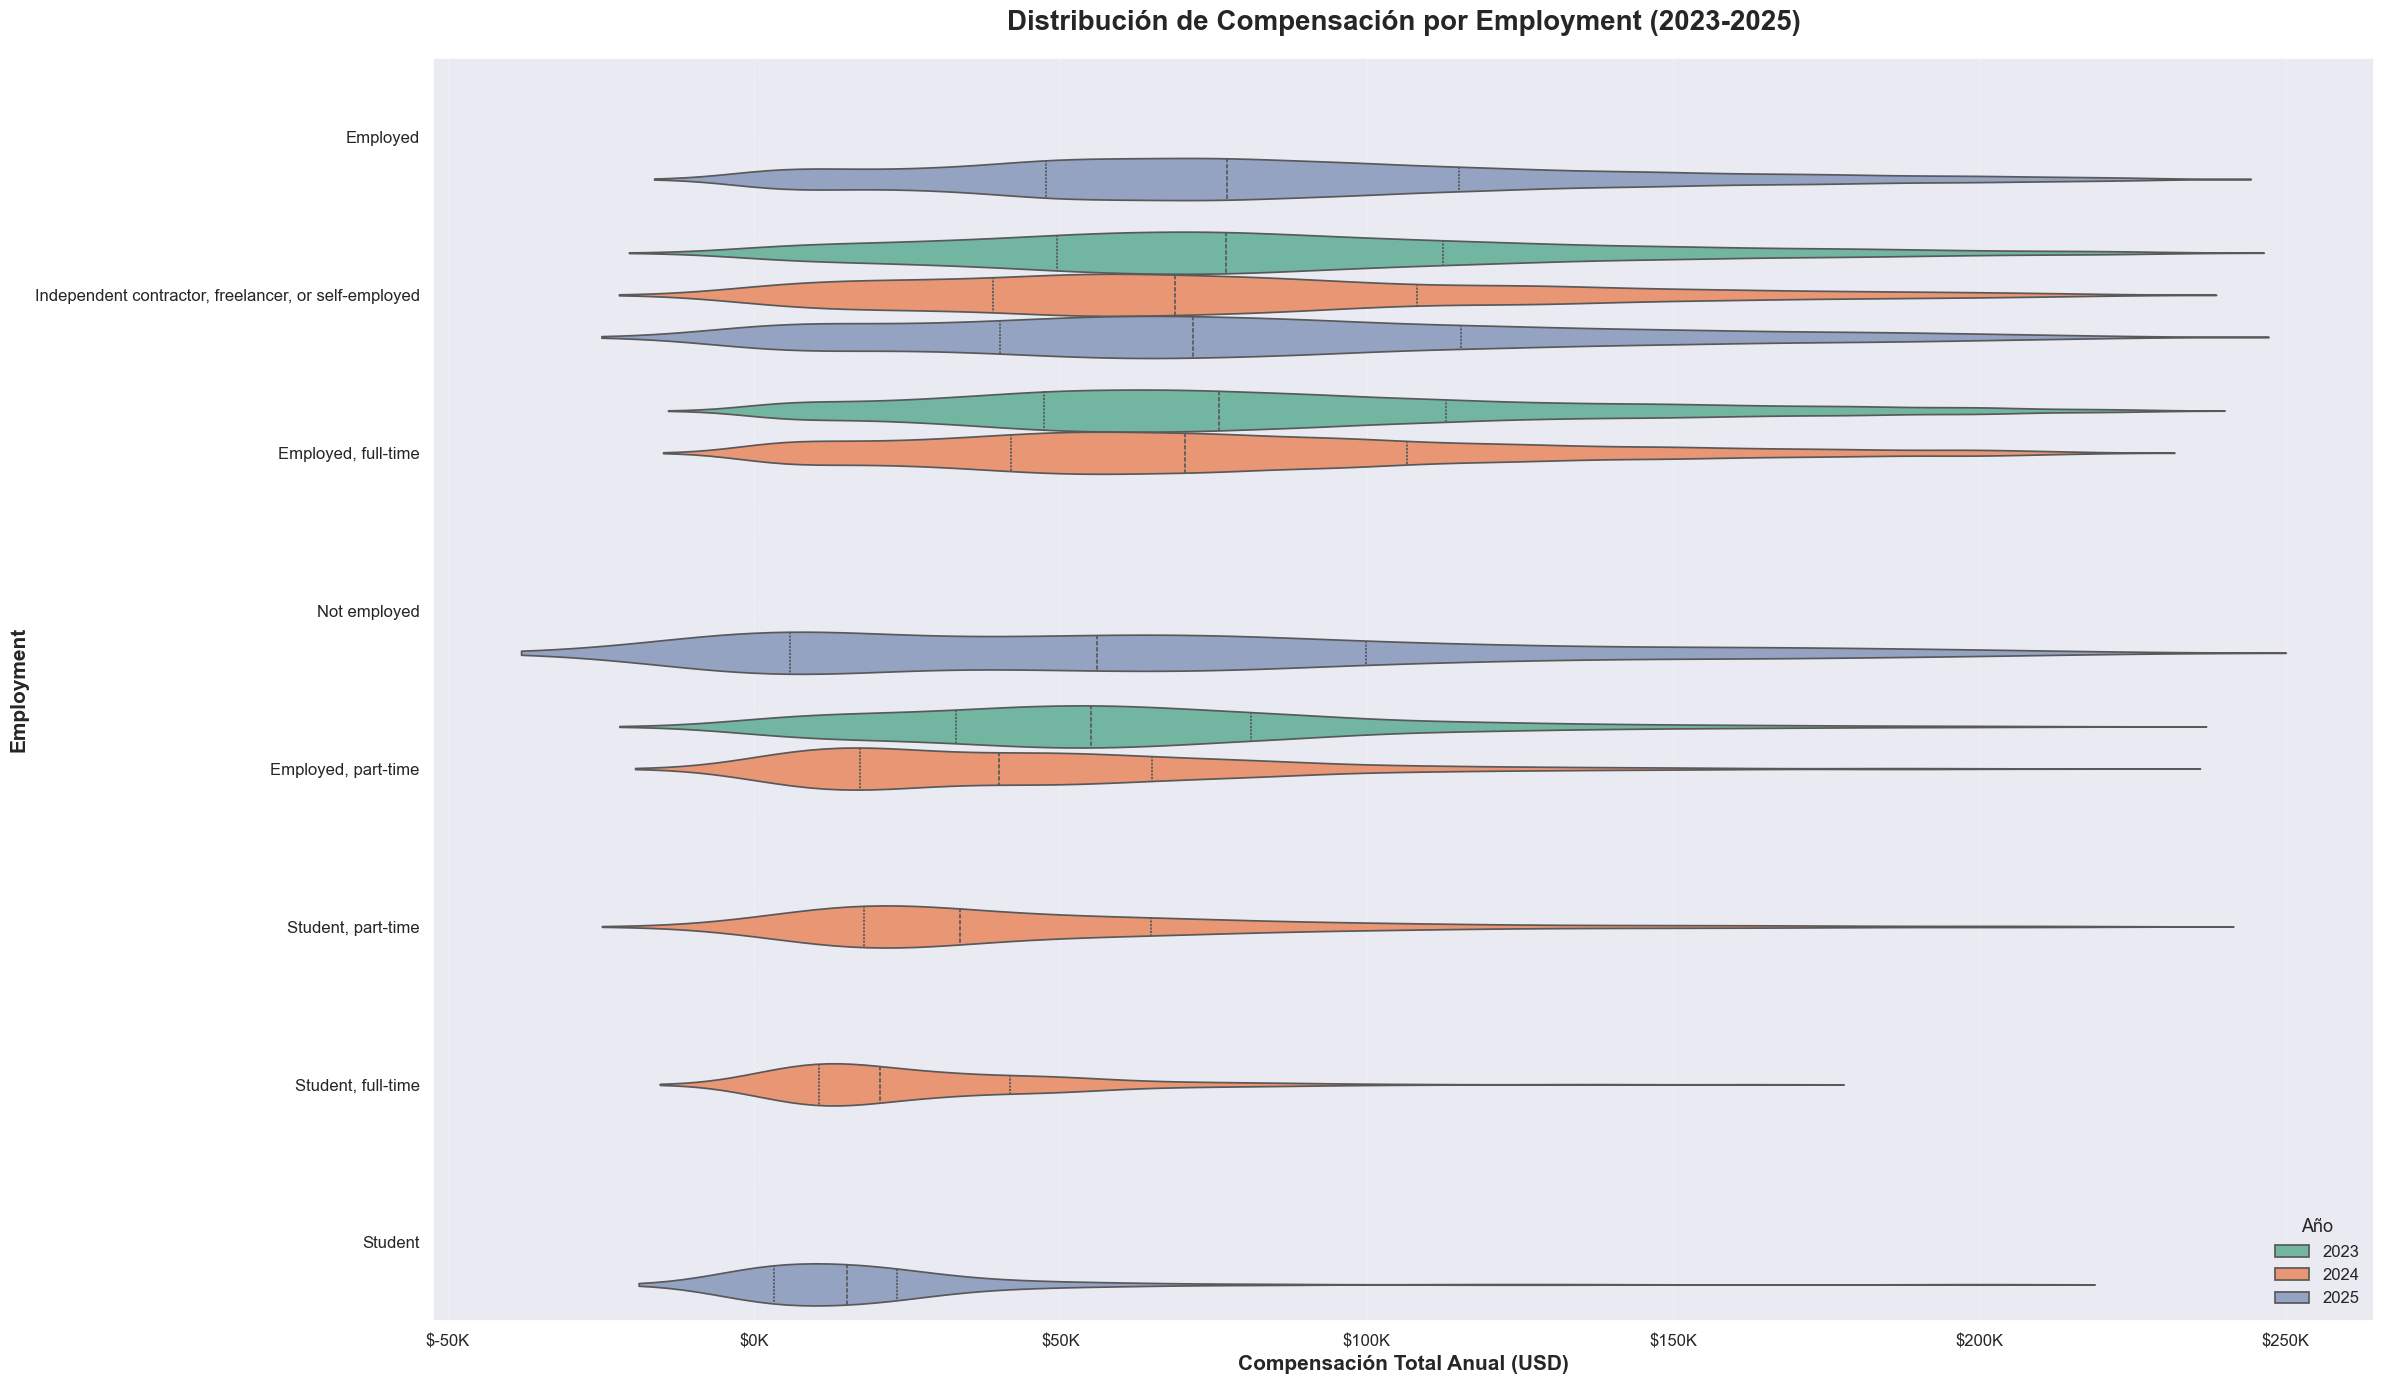

In [276]:
# Para Employment
crear_violin_categorico(df_filtrado_sin_outliers, 'Employment', explotar=True)

#### HeatMap

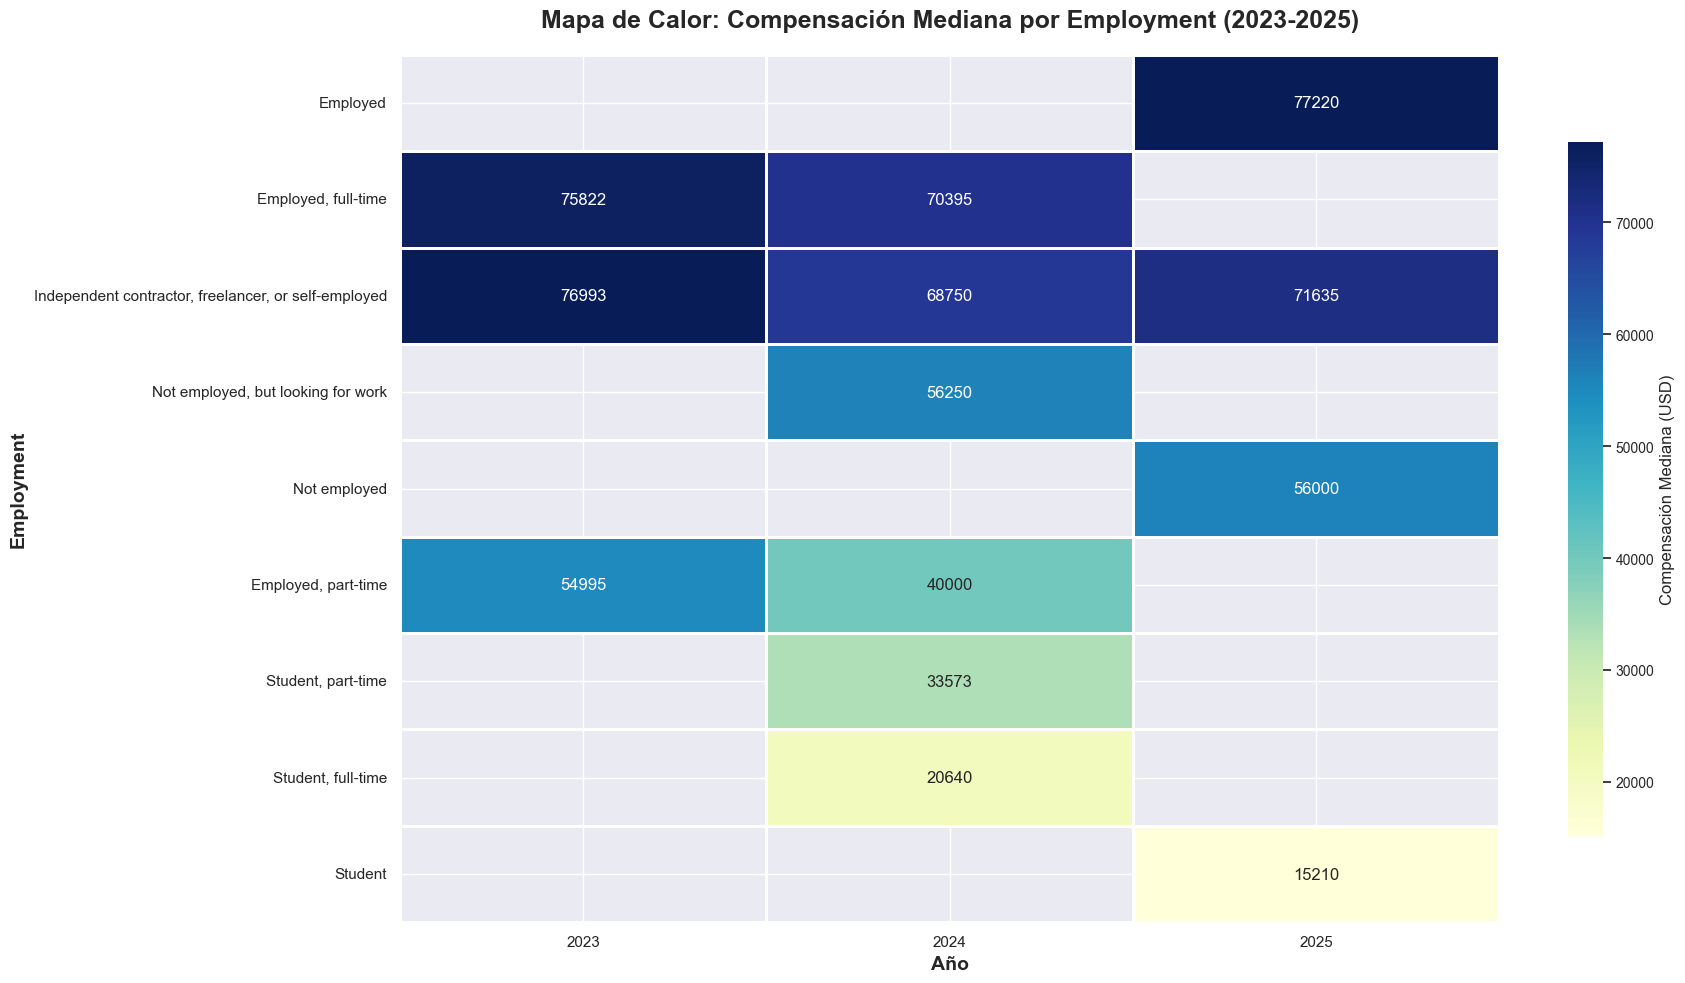

In [277]:
# Para Employment
crear_heatmap_categorico(df_filtrado_sin_outliers, 'Employment', explotar=True)

## Validación de hipótesis

**Hipótesis:**
1. Los desarrolladores con más experiencia (WorkExp - YearsCode) tienden a tener una compensación (CompTotal) más alta.
2. Los desarrolladores que trabajan de forma remota (RemoteWork) tienen una compensación (CompTotal) diferente en comparación con aquellos que no lo hacen.
3. La compensación (CompTotal) varía significativamente entre diferentes países (Country).
4. La compensación (CompTotal) está correlacionada con la edad (Age) de los desarrolladores.
---
5. Los desarrolladores que **trabajan con ciertas tecnologías** tienen una compensación (CompTotal) más alta.\
        a- Lenguajes de programación (LanguageHaveWorkedWith)\
        b- Frameworks web (WebframeHaveWorkedWith)\
        c- Bases de datos (DatabaseHaveWorkedWith)\
        d- Plataformas (PlatformHaveWorkedWith)\
        e- Sistemas operativos (OpSysProfessional use)

### Funciones utilizadas

In [278]:
filtar_variables_con_menos_de_n_observaciones = 5


# Inicializa una lista para guardar los DataFrames de cada año
def generar_dataframe_comparador(dict_de_df, variable):
  df_comparison_list = []
  for anio in dict_de_df.keys():
    n = len(dict_de_df[anio])
    # Agrupar por la variable y calcular la media de 'CompTotal' y la cantidad
    grouped_data = dict_de_df[anio].groupby(variable)['CompTotal'].agg(['mean', 'count']).round(2).reset_index()
    grouped_data.rename(columns={'mean': 'CompTotal'}, inplace=True)
    # Añadimos la columna 'Year' para identificar el año
    grouped_data['Year'] = f"{anio} (n= {n})"
    df_comparison_list.append(grouped_data)

  # Retornar el dataframe con todas las keys del dict
  return pd.concat(df_comparison_list)


def graficar_comparacion(dict_de_df, variable, palette="colorblind", excluir_columna=None, rotation=None, min_n=False,
                         wrap_x=True):
  # Generar el DataFrame combinado
  df_comparison = generar_dataframe_comparador(dict_de_df, variable)

  # Excluir valores específicos ANTES de filtrar por count
  if excluir_columna is not None:
    if isinstance(excluir_columna, list):
      df_comparison = df_comparison[~df_comparison[variable].isin(excluir_columna)]
    else:
      df_comparison = df_comparison[df_comparison[variable] != excluir_columna]

  # Filtrar visualmente los grupos con al menos 5 observaciones
  df_comparison = df_comparison[
    df_comparison['count'] >= (min_n if min_n else filtar_variables_con_menos_de_n_observaciones)]

  # Crear el gráfico
  plt.figure(figsize=(15, 8))
  sns.barplot(x=variable, y='CompTotal', hue='Year', data=df_comparison, palette=palette)

  # Añadir etiquetas y título
  plt.title(f'Comparación de la Media de Compensación Total por {variable} en {len(dict_de_df)} Años')
  plt.xlabel(variable)
  plt.ylabel('Compensación Total Media')

  # Ajustar las etiquetas del eje x para que se "envuelvan" (wrap)
  ax = plt.gca()
  labels = [tick.get_text() for tick in ax.get_xticklabels()]
  max_len = max([len(label) for label in labels])

  # Si alguna etiqueta tiene más de cierto número de caracteres, hacer un ajuste
  if max_len > 30 and wrap_x:
    # Divide las etiquetas en múltiples líneas
    wrapped_labels = [label.replace(' ', '\n') if len(label) > 30 else label for label in labels]
    ax.set_xticks(ax.get_xticks())  # Asegura que los ticks estén definidos
    ax.set_xticklabels(wrapped_labels)

  if rotation is not None:
    # Rota las etiquetas del eje x para mejorar la legibilidad
    plt.xticks(rotation=rotation, ha='right')

  # Ajusta el layout para evitar superposición
  plt.tight_layout()

  # Muestra el gráfico
  plt.show()
  plt.close()


# ---


def graficar_comparacion_lineal(dict_de_df, variable, palette="Accent"):
  # Generar el DataFrame combinado
  df_comparison = generar_dataframe_comparador(dict_de_df, variable)

  # Filtrar visualmente los grupos con al menos 5 observaciones
  df_comparison = df_comparison[df_comparison['count'] >= filtar_variables_con_menos_de_n_observaciones]

  # Crear el gráfico de líneas con puntos
  plt.figure(figsize=(15, 8))

  # Usamos lineplot para las líneas y scatterplot para los puntos
  sns.lineplot(x=variable, y='CompTotal', hue='Year', data=df_comparison, marker='o', linewidth=2, markersize=8,
               palette=palette)

  # Ajustar las etiquetas y el título
  plt.title(f'Comparación de la Media de Compensación Total por {variable} (Con Puntos) a lo largo de los Años',
            fontsize=16)
  plt.xlabel(variable, fontsize=14)
  plt.ylabel('Compensación Total Media', fontsize=14)

  # Ajustar el layout para evitar superposiciones
  plt.tight_layout()

  # Mostrar el gráfico
  plt.show()
  plt.close()


# ---


# Específicas
def generar_dataframe_con_mediana_y_n(dict_de_df, variable):
  df_list = []
  for anio, df in dict_de_df.items():
    grouped = df.groupby(variable)['CompTotal'].agg(['median', 'count']).reset_index()
    grouped['Year'] = anio
    df_list.append(grouped)
  return pd.concat(df_list)


def graficar_mediana_y_n(dict_de_df, variable, palette="Accent"):
  df = generar_dataframe_con_mediana_y_n(dict_de_df, variable)

  # Filtrar visualmente los grupos con al menos 5 observaciones
  df = df[df['count'] >= filtar_variables_con_menos_de_n_observaciones]

  plt.figure(figsize=(15, 8))
  sns.lineplot(x=variable, y='median', hue='Year', data=df, marker='o', palette=palette)

  # Añadir etiquetas con el número de observaciones
  for _, row in df.iterrows():
    plt.text(row[variable], row['median'], f"n={int(row['count'])}",
             fontsize=9, color='black', ha='center', va='bottom')

  plt.title(f'Mediana de Compensación Total por {variable} y Número de Observaciones')
  plt.xlabel(variable)
  plt.ylabel('Mediana de Compensación Total')
  plt.tight_layout()
  plt.show()
  plt.close()


### 1. WorkExp - YearsCode vs CompTotal

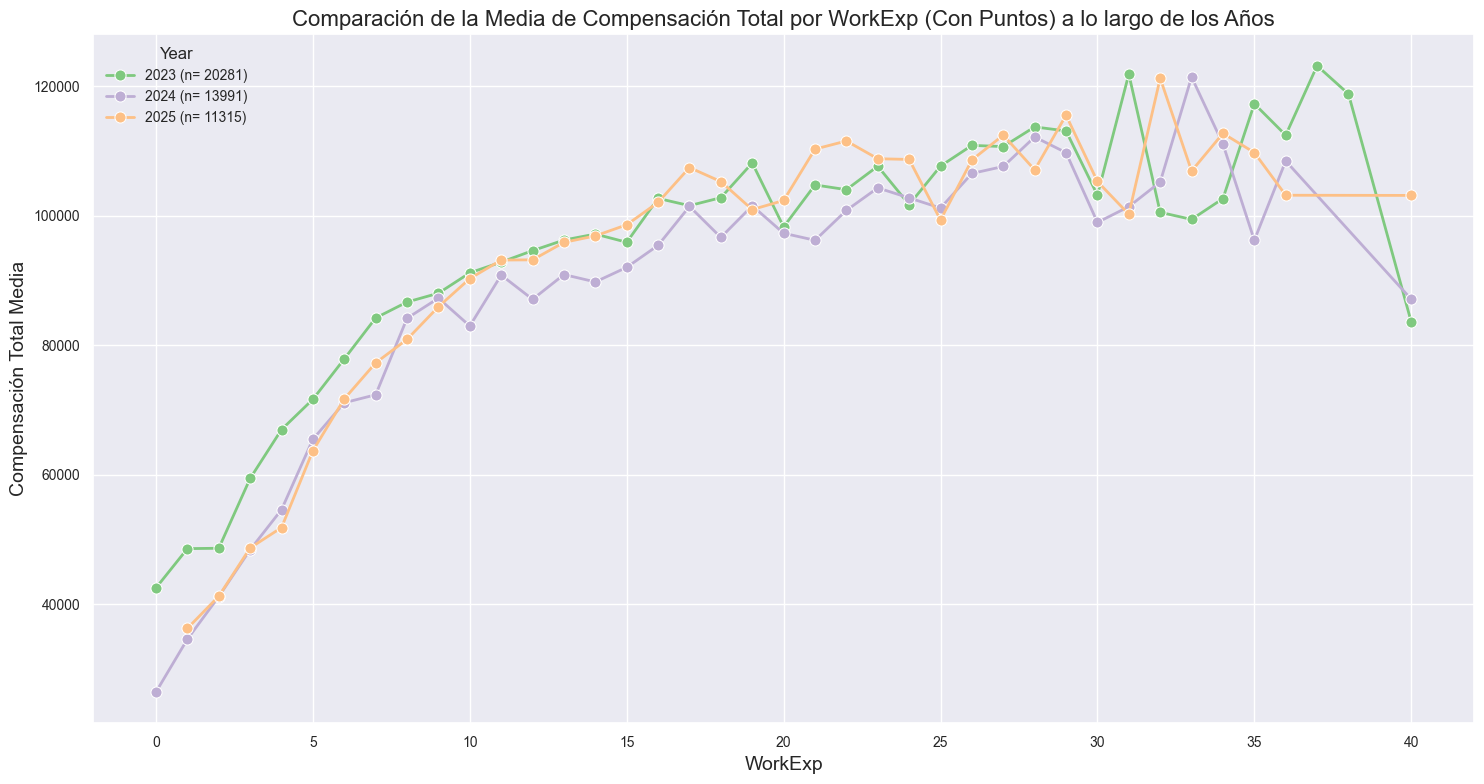

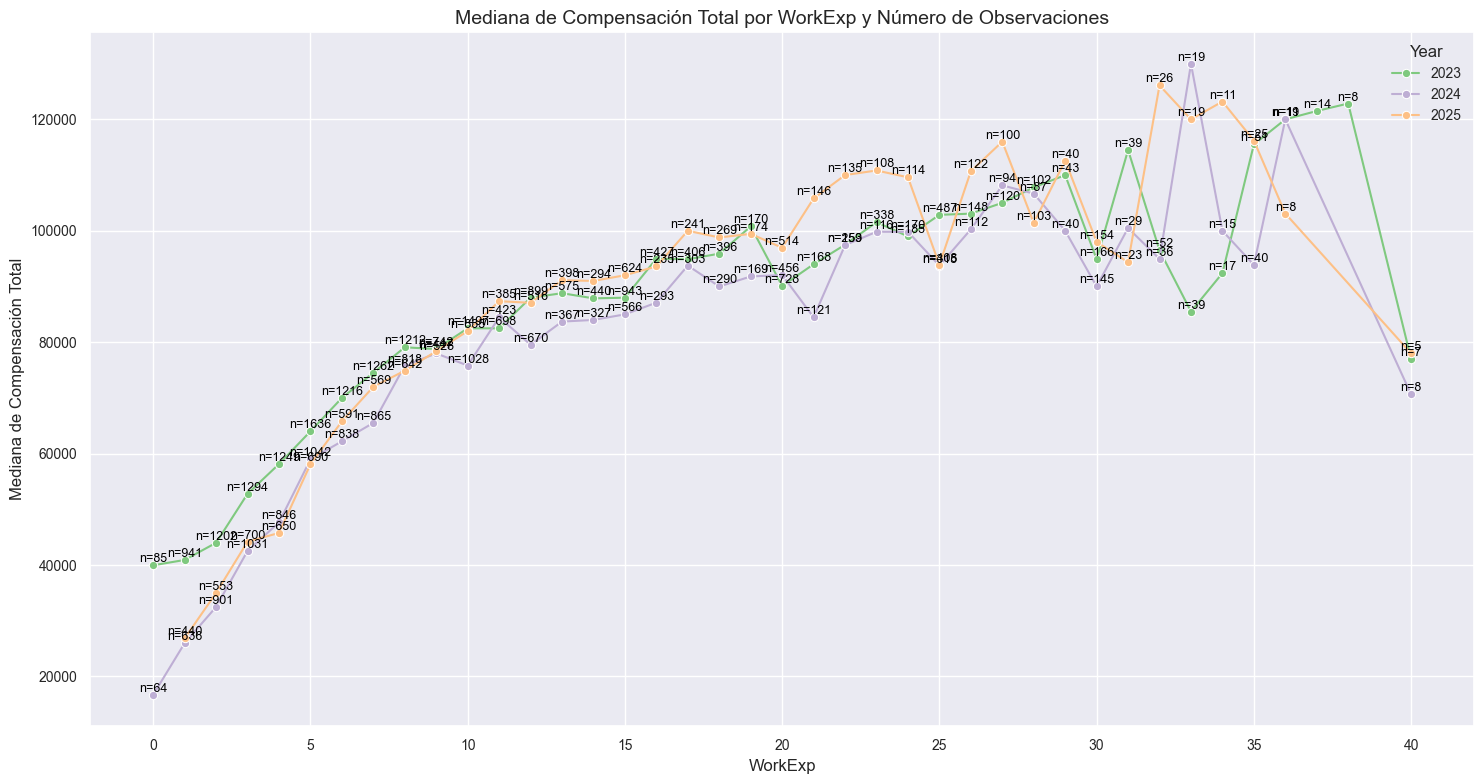

In [279]:
graficar_comparacion_lineal(df_filtrado_sin_outliers, 'WorkExp')
graficar_mediana_y_n(df_filtrado_sin_outliers, 'WorkExp')

**📊 Análisis de la relación entre experiencia laboral (WorkExp) y compensación total (CompTotal)**

* Los gráficos muestran que, en general, a mayor experiencia laboral, mayor es la compensación total. Esta relación es especialmente clara durante los primeros 10-15 años de experiencia, donde se observa un crecimiento sostenido en la compensación media y mediana.

* A partir de aproximadamente los 15-20 años de experiencia, la compensación tiende a estabilizarse y presenta menos variación significativa. En los niveles más altos de experiencia (más de 30 años), se observan fluctuaciones abruptas que no parecen reflejar una tendencia real, ya que se deben a una **baja cantidad de respuestas** (en muchos casos, n ≤ 5).

* En resumen, los datos respaldan la hipótesis: **los desarrolladores con más experiencia tienden a tener una mayor compensación**, aunque el crecimiento se desacelera con el tiempo, y los datos escasos en niveles altos de experiencia limitan la confianza en esas observaciones.

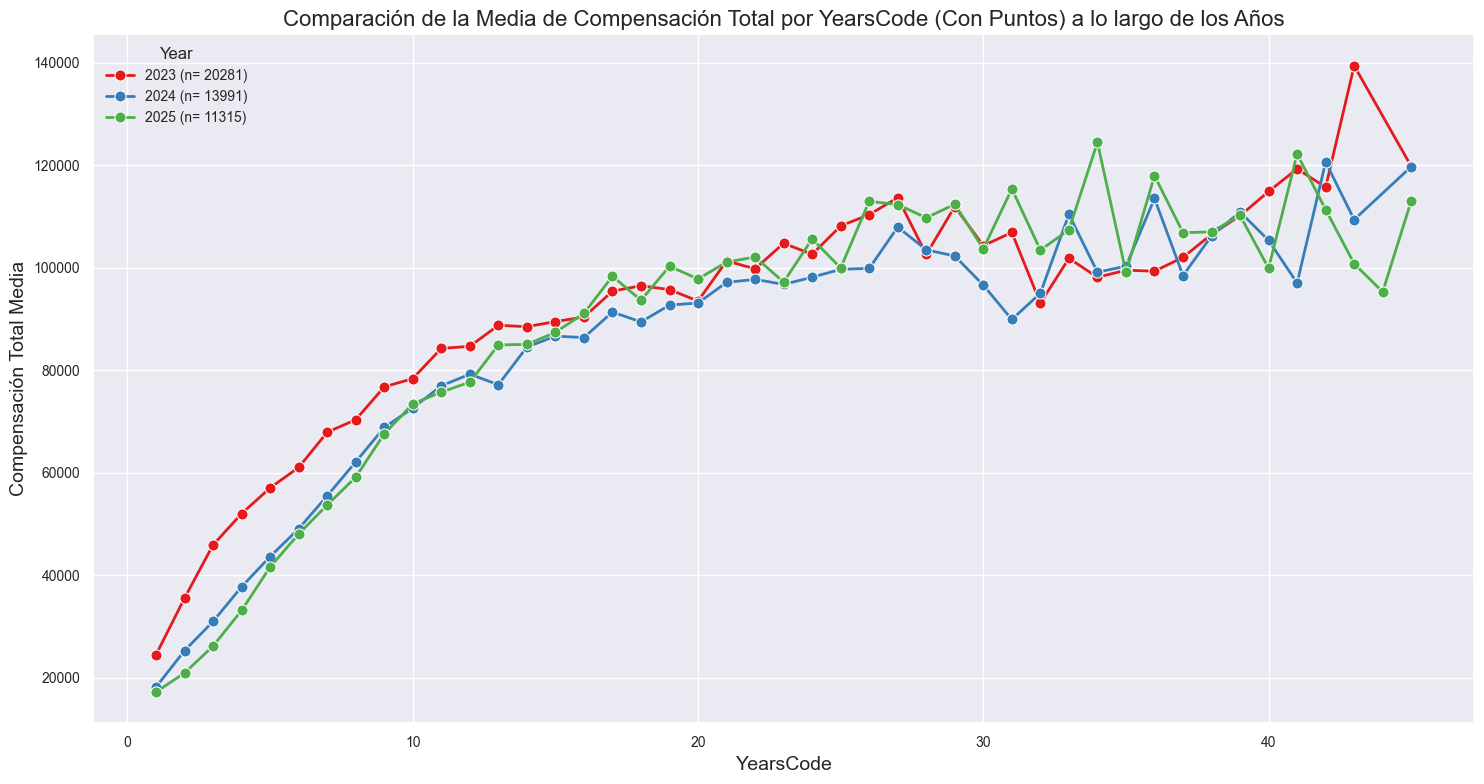

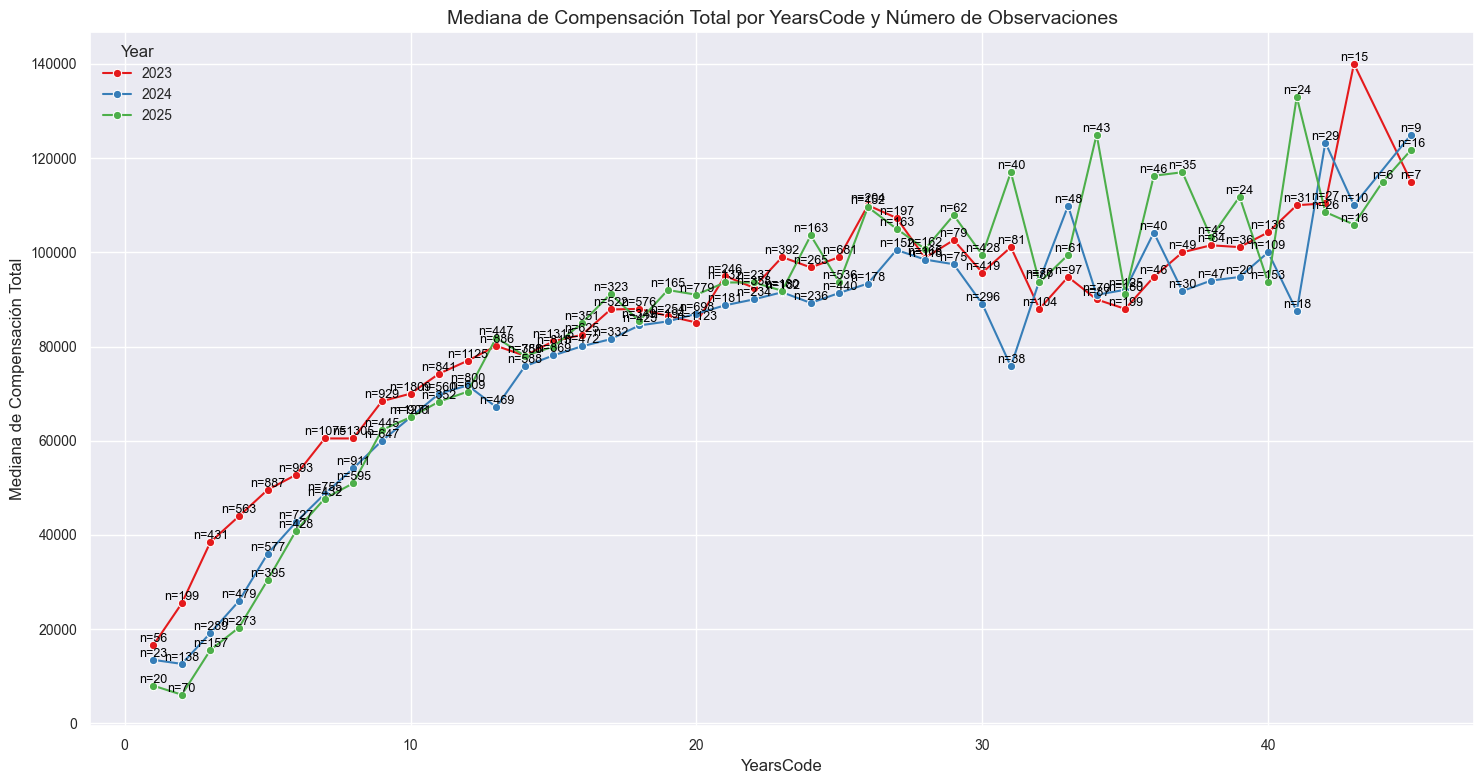

In [280]:
graficar_comparacion_lineal(df_filtrado_sin_outliers, 'YearsCode', palette="Set1")
graficar_mediana_y_n(df_filtrado_sin_outliers, 'YearsCode', palette="Set1")

**📊 Análisis de la Relación entre Años de Experiencia (`YearsCode`) y la Compensación Total Media (`CompTotal`)**

- Existe una **tendencia general clara y consistente** de aumento de la compensación a medida que aumentan los años de experiencia.
- Esta tendencia es **más marcada entre 0 y ~15 años de experiencia**, donde la compensación media crece rápidamente.
- A partir de aproximadamente **20 años de experiencia**, la curva se aplana y tiende a estabilizarse, con algunas pequeñas fluctuaciones.
- Para valores muy altos de `YearsCode` (30+), aparecen algunas **oscilaciones bruscas** que probablemente se deban a **poca cantidad de observaciones** en esos rangos (lo cual ya fue filtrado para valores menores a 5, pero aún así el n es bajo en esos puntos).


La hipótesis **se valida** al analizar ambas variables relacionadas con la experiencia laboral:

- Tanto los **años de experiencia en programación (`YearsCode`)** como los **años de experiencia laboral total (`WorkExp`)** muestran una tendencia clara y consistente:
  > A mayor experiencia, mayor es la compensación total media (`CompTotal`).

- En ambos casos, la compensación crece principalmente durante los primeros 15 a 20 años de experiencia, estabilizándose y mostrando mayor dispersión en los valores extremos de experiencia más alta.

- Esta consistencia en la tendencia, observada en los datos de 2023, 2024 y 2025, refuerza que la experiencia es un factor clave para la compensación, sin importar si se mide específicamente en programación o experiencia laboral general.

---

**💡 Nota adicional**

Aunque se filtraron los grupos con menos de 5 observaciones para evitar sesgos, se decidió conservar los valores extremos con baja representatividad para **no invisibilizar perfiles con trayectorias atípicas**, lo que puede generar algo de ruido en los extremos pero aporta una visión más completa del panorama.

### 2. RemoteWork vs CompTotal

In [281]:
for anio in ANIOS:
  separator(anio)
  valores_mas_comunes_con_print(df_filtrado_sin_outliers[anio], 'RemoteWork')


2023

Los 10 valores más comunes en 'RemoteWork':
RemoteWork
Remote                                  9340
Hybrid (some remote, some in-person)    8572
In-person                               2369
Name: count, dtype: int64

2024

Los 10 valores más comunes en 'RemoteWork':
RemoteWork
Hybrid (some remote, some in-person)    6046
Remote                                  5886
In-person                               2057
No especificado                            2
Name: count, dtype: int64

2025

Los 10 valores más comunes en 'RemoteWork':
RemoteWork
Remote                                                                          3637
Hybrid (some remote, leans heavy to in-person)                                  2011
Hybrid (some in-person, leans heavy to flexibility)                             1863
Your choice (very flexible, you can come in when you want or just as needed)    1340
No especificado                                                                 1236
In-person             

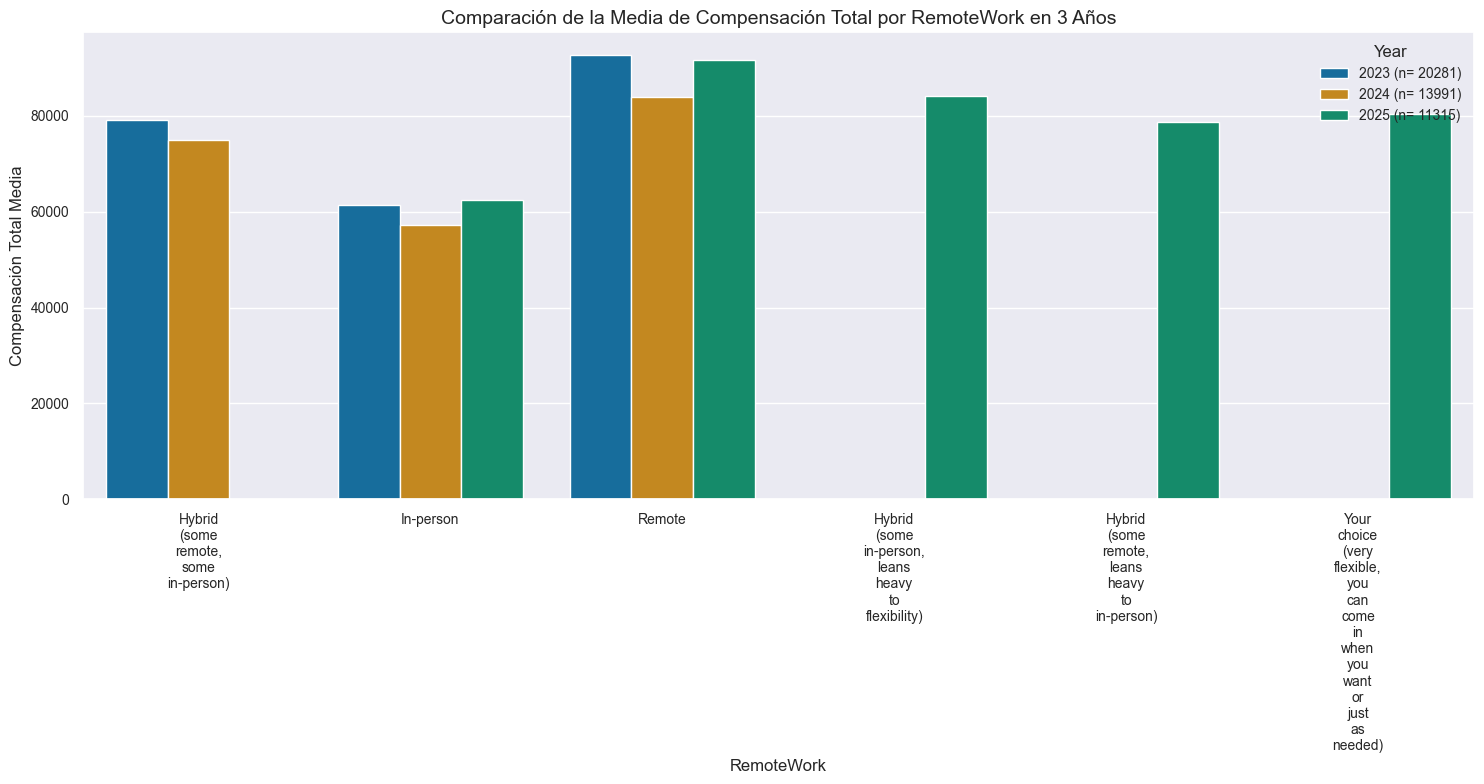

In [282]:
# Mostrar gráfico exluyendo la columna 'no especificado'
graficar_comparacion(df_filtrado_sin_outliers, 'RemoteWork', excluir_columna='No especificado')


**Análisis de la compensación según modalidad de trabajo remoto (RemoteWork)**

- La compensación promedio varía notablemente entre las modalidades de trabajo remoto.
- Las modalidades agrupadas en *Remote*, *Hybrid* e *In-person* muestran diferencias claras:
  - *Remote* y *Hybrid* tienden a tener una compensación promedio más alta que *In-person*.
- Esto podría indicar que trabajar de forma remota o híbrida está asociado con mejores niveles de compensación promedio en comparación con trabajo presencial, aunque es importante considerar otros factores y el tamaño de cada grupo.

### 3. Country vs CompTotal

Analizaremos la media de compensación total en paises con al menos 50 respuestas

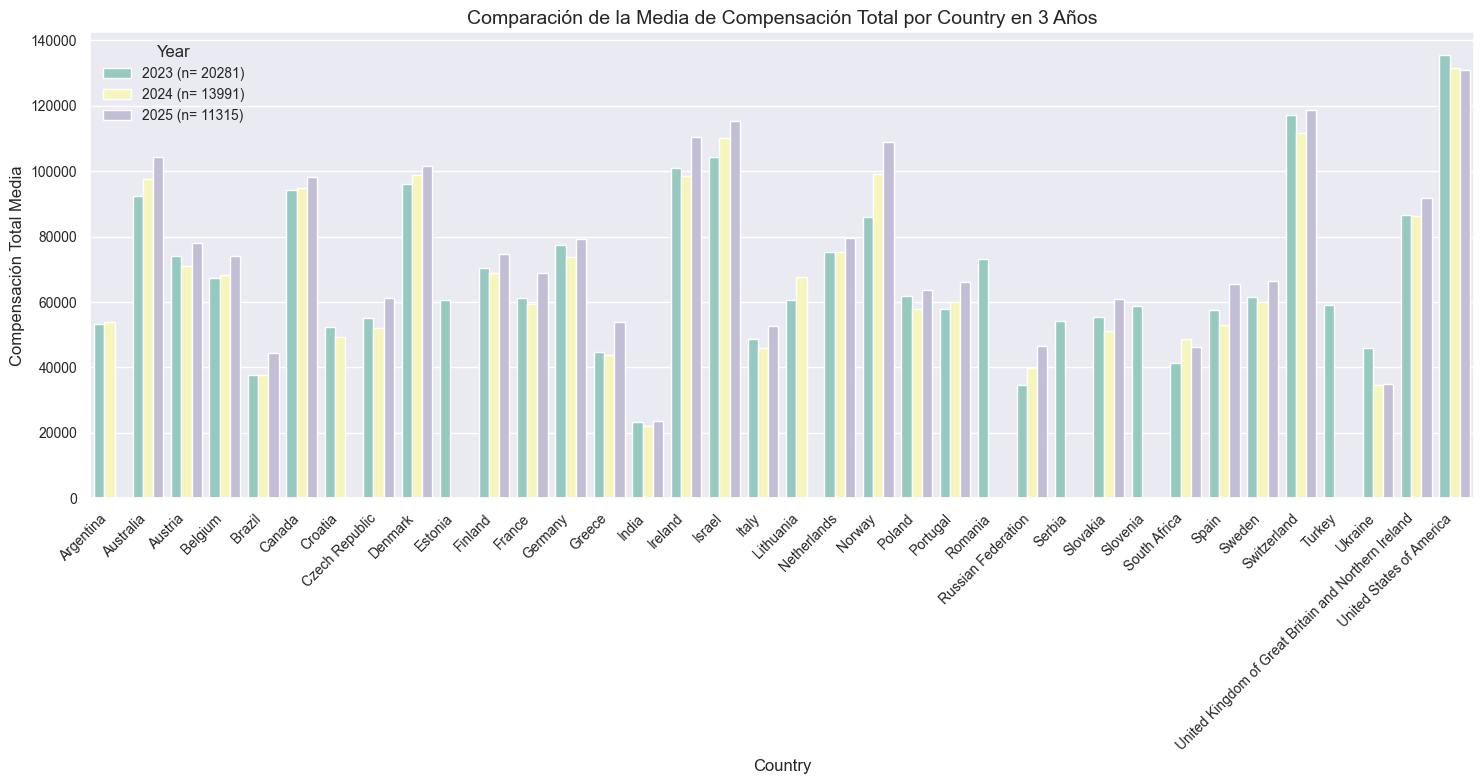

In [283]:
graficar_comparacion(df_filtrado_sin_outliers, 'Country', palette="Set3", rotation=45, wrap_x=False, min_n=50)

In [284]:
# Calcular el top 5 de países con mejor y peor compensación promedio (mínimo 50 observaciones)
df_combined = pd.concat([df.assign(Year=year) for year, df in df_filtrado_sin_outliers.items()], ignore_index=True)

top_5_paises_mas_altos = (df_combined.groupby('Country')['CompTotal']
                          .agg(['mean', 'count'])
                          .query('count >= 50')  # Filtro de mínimo 50 observaciones
                          .sort_values('mean', ascending=False)
                          .head(5)
                          .round(2))

top_5_paises_mas_bajos = (df_combined.groupby('Country')['CompTotal']
                          .agg(['mean', 'count'])
                          .query('count >= 50')  # Filtro de mínimo 50 observaciones
                          .sort_values('mean', ascending=True)
                          .head(5)
                          .round(2))

separator("TOP 5 PAÍSES COMPENSACIÓN PROMEDIO (2023-2025)\n(Mínimo 50 Observaciones)")
print("\nPaises con mejores compensaciones")
print(f"{'País':<35} {'Media (USD)':<15} {'N. Obs.':<10}")
print("-" * 60)

for pais, (media, count) in top_5_paises_mas_altos.iterrows():
  print(f"{pais:<35} ${media:>12,.2f}  {int(count):>8}")

print("=" * 60)
print("\nPaises con peores compensaciones")
print(f"{'País':<35} {'Media (USD)':<15} {'N. Obs.':<10}")
print("-" * 60)

for pais, (media, count) in top_5_paises_mas_bajos.iterrows():
  print(f"{pais:<35} ${media:>12,.2f}  {int(count):>8}")




TOP 5 PAÍSES COMPENSACIÓN PROMEDIO (2023-2025)
(Mínimo 50 Observaciones)

Paises con mejores compensaciones
País                                Media (USD)     N. Obs.   
------------------------------------------------------------
United States of America            $  133,409.85      9831
Switzerland                         $  115,750.98       781
Israel                              $  108,216.45       470
Ireland                             $  103,219.94       290
Denmark                             $   98,366.64       481

Paises con peores compensaciones
País                                Media (USD)     N. Obs.   
------------------------------------------------------------
India                               $   23,019.79      2869
Venezuela, Bolivarian Republic of... $   23,853.26        81
Iran, Islamic Republic of...        $   24,811.20        52
Ecuador                             $   34,274.92        63
Ukraine                             $   36,328.53      1469


**Análisis de Hipótesis: Variación de Compensación por País**
1. **Variación Extrema entre Países:**
   - **Máxima compensación:** United States of America (~\$135,000)
   - **Mínima compensación:** India (~\$23,000)
   - **Rango de variación:** ~\$113,000 (diferencia de más del 500%)

2. **Grupos Claramente Diferenciados:**
   - Alto salario (>\$100,000): USA, Switzerland, Israel, Australia
   - Salario medio (\$60,000-\$100,000): Dinamarca, Noruega, Austria, Alemania, Países Bajos
   - Salario bajo (<\$50,000): India, Brasil, Federación Rusa, Grecia

3. **Consistencia Temporal:**
   - La variación se mantiene estable entre 2023-2025
   - Los países mantienen sus posiciones relativas año tras año

**Conclusión:**
La compensación varía **significativamente** entre países, con diferencias de hasta 6x entre el país mejor pagado (USA) y el peor pagado (India). Esta variación está fuertemente correlacionada con el nivel de desarrollo económico y costo de vida de cada país.

### 4. Age vs CompTotal

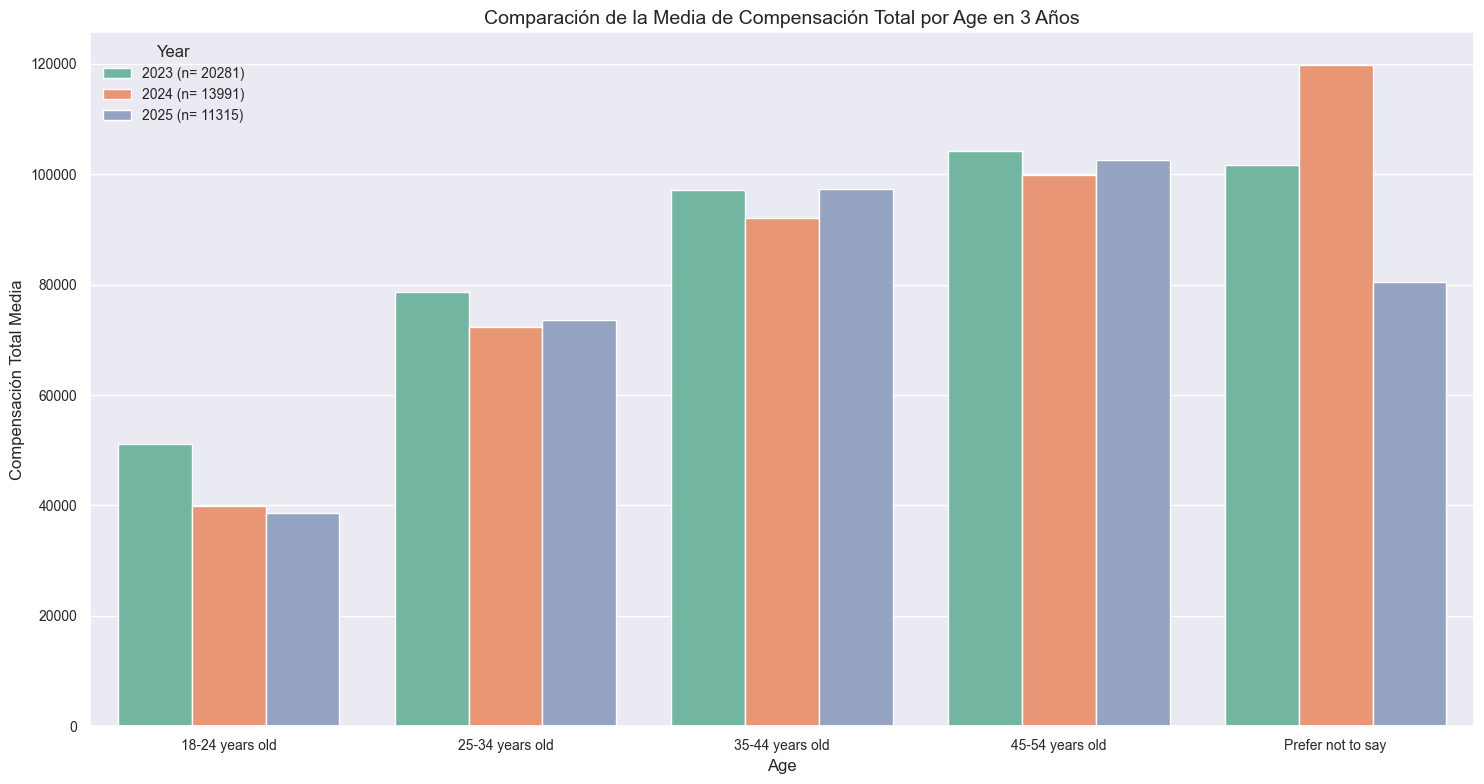

In [285]:
graficar_comparacion(df_filtrado_sin_outliers, 'Age', palette="Set2")

**Análisis de la compensación según edad (Age)**

- La compensación total media aumenta con la edad hasta el grupo de 45-54 años, mostrando una tendencia clara y positiva.
- El grupo de 18-24 años tiene la compensación promedio más baja, lo que es esperado por menor experiencia y antigüedad.
- Este comportamiento respalda la hipótesis de que la compensación está correlacionada positivamente con la edad.

### 5. Tecnologías vs CompTotal

#### Funciones reutilizables

In [326]:
def preparar_datos_tecnologias(df_filtrado_sin_outliers, variable_tecnologia,
                               top_n=15, min_observaciones=100,
                               tecnologias_excluir=None):
  """
  Prepara datos de variables tecnológicas con valores múltiples separados por ';'.

  Args:
      df_filtrado_sin_outliers: Diccionario con DataFrames por año
      variable_tecnologia: Nombre de la columna tecnológica
      top_n: Número de tecnologías top a analizar
      min_observaciones: Mínimo de observaciones requeridas (default 10,000)
      tecnologias_excluir: Lista de tecnologías a excluir (ej: ['Bash/Shell', 'HTML/CSS'])

  Returns:
      DataFrame procesado, orden por mediana, estadísticas agregadas
  """
  # Combinar todos los años
  df_combined = pd.concat([df.assign(Year=year) for year, df in df_filtrado_sin_outliers.items()],
                          ignore_index=True)

  # Explotar valores múltiples separados por ';'
  df_exploded = df_combined[df_combined[variable_tecnologia].notna()].copy()
  df_exploded[variable_tecnologia] = df_exploded[variable_tecnologia].str.split(';')
  df_exploded = df_exploded.explode(variable_tecnologia)
  df_exploded[variable_tecnologia] = df_exploded[variable_tecnologia].str.strip()
  df_exploded = df_exploded[df_exploded[variable_tecnologia] != '']

  # NUEVO: Excluir tecnologías específicas
  if tecnologias_excluir:
    df_exploded = df_exploded[~df_exploded[variable_tecnologia].isin(tecnologias_excluir)]

  # Filtrar por frecuencia mínima
  conteo_tecnologias = df_exploded[variable_tecnologia].value_counts()
  tecnologias_validas = conteo_tecnologias[conteo_tecnologias >= min_observaciones].index
  df_filtered = df_exploded[df_exploded[variable_tecnologia].isin(tecnologias_validas)].copy()

  # Calcular estadísticas por tecnología (P90 en lugar de Moda)
  stats = df_filtered.groupby(variable_tecnologia, observed=True)['CompTotal'].agg([
    ('Mediana', 'median'),
    ('Media', 'mean'),
    ('P90', lambda x: x.quantile(0.90)),
    ('Q1', lambda x: x.quantile(0.25)),
    ('Q3', lambda x: x.quantile(0.75)),
    ('Count', 'count')
  ]).reset_index()

  # Ordenar por mediana y tomar top N
  stats = stats.nlargest(top_n, 'Mediana')
  orden = stats[variable_tecnologia].tolist()

  # Filtrar DataFrame por top N tecnologías
  df_plot = df_filtered[df_filtered[variable_tecnologia].isin(orden)].copy()

  return df_plot, orden, stats


def crear_barplot_tecnologias_metricas(df_filtrado_sin_outliers, variable_tecnologia,
                                       top_n=15, min_observaciones=100,
                                       tecnologias_excluir=None,
                                       figsize=(26, 12)):
  """
  Crea barplot horizontal con mediana, media y percentil 90.

  Args:
      df_filtrado_sin_outliers: Diccionario con DataFrames por año
      variable_tecnologia: Nombre de la columna tecnológica
      top_n: Número de tecnologías a mostrar
      min_observaciones: Mínimo de observaciones requeridas
      tecnologias_excluir: Lista de tecnologías a excluir
      figsize: Tamaño de la figura
  """
  # Preparar datos (ahora pasa tecnologias_excluir)
  df_plot, orden, stats = preparar_datos_tecnologias(
    df_filtrado_sin_outliers, variable_tecnologia, top_n, min_observaciones, tecnologias_excluir
  )

  # Crear figura con dos subplots
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': [3, 1]})

  # Subplot 1: Barplot con mediana, media y P90
  stats_melted = stats.melt(id_vars=[variable_tecnologia, 'Count'],
                            value_vars=['Mediana', 'Media', 'P90'],
                            var_name='Métrica', value_name='Compensación')

  sns.barplot(data=stats_melted, y=variable_tecnologia, x='Compensación',
              hue='Métrica', order=orden, ax=ax1,
              palette={'Mediana': '#2E86AB', 'Media': '#A23B72', 'P90': '#F18F01'},
              edgecolor='black', linewidth=0.8)

  ax1.set_title(f'Top {top_n} {variable_tecnologia.replace("HaveWorkedWith", "").replace("Professional use", "")}\n'
                f'Compensación: Mediana, Media y Percentil 90',
                fontsize=18, fontweight='bold', pad=15)
  ax1.set_xlabel('Compensación Total Anual (USD)', fontsize=14, fontweight='bold')
  ax1.set_ylabel('Tecnología', fontsize=14, fontweight='bold')
  ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x / 1000:.0f}K'))
  ax1.grid(True, alpha=0.3, axis='x', linestyle='--')

  # Añadir línea de mediana global
  mediana_global = df_plot['CompTotal'].median()
  ax1.axvline(mediana_global, color='red', linestyle='--', linewidth=2.5,
              alpha=0.7, label=f'Mediana Global: ${mediana_global:,.0f}')

  ax1.legend(title='Métricas', fontsize=11, title_fontsize=12,
             loc='lower right', framealpha=0.95)
  ax1.tick_params(axis='both', labelsize=11)

  # Subplot 2: Número de observaciones
  sns.barplot(data=stats, y=variable_tecnologia, x='Count',
              order=orden, ax=ax2, color='#6C757D',
              edgecolor='black', linewidth=0.8)

  ax2.set_title(f'Número de\nObservaciones\n(Min: {min_observaciones:,})',
                fontsize=14, fontweight='bold', pad=15)
  ax2.set_xlabel('Cantidad', fontsize=12, fontweight='bold')
  ax2.set_ylabel('')
  ax2.set_yticklabels([])
  ax2.grid(True, alpha=0.3, axis='x', linestyle='--')
  ax2.tick_params(axis='x', labelsize=10)

  # Añadir valores en las barras
  for container in ax2.containers:
    ax2.bar_label(container, fmt='%d', label_type='edge',
                  fontsize=9, padding=3)

  plt.tight_layout()
  plt.show()
  plt.close()


def crear_ridgeplot_tecnologias(df_filtrado_sin_outliers, variable_tecnologia,
                                top_n=12, min_observaciones=100,
                                tecnologias_excluir=None,
                                figsize=(24, 16)):
  """
  Crea ridgeplot (distribuciones apiladas) para visualizar la distribución
  completa de compensación por tecnología.

  Args:
      df_filtrado_sin_outliers: Diccionario con DataFrames por año
      variable_tecnologia: Nombre de la columna tecnológica
      top_n: Número de tecnologías a mostrar
      min_observaciones: Mínimo de observaciones requeridas
      tecnologias_excluir: Lista de tecnologías a excluir
      figsize: Tamaño de la figura
  """
  # Preparar datos
  df_plot, orden, stats = preparar_datos_tecnologias(
    df_filtrado_sin_outliers, variable_tecnologia, top_n, min_observaciones, tecnologias_excluir
  )

  # Crear figura
  fig, ax = plt.subplots(figsize=figsize)

  # Colores degradados
  colores = sns.color_palette("viridis", n_colors=len(orden))

  # Crear ridgeplot manual con violinplot
  y_pos = 0
  yticks = []
  yticklabels = []

  for idx, tecnologia in enumerate(reversed(orden)):
    data = df_plot[df_plot[variable_tecnologia] == tecnologia]['CompTotal']

    # Violin horizontal
    parts = ax.violinplot([data], positions=[y_pos],
                          vert=False, widths=0.8,
                          showmeans=True, showmedians=True,
                          showextrema=True)

    # Colorear violin
    for pc in parts['bodies']:
      pc.set_facecolor(colores[idx])
      pc.set_alpha(0.7)
      pc.set_edgecolor('black')
      pc.set_linewidth(1.2)

    # Colorear líneas estadísticas
    for partname in ('cbars', 'cmins', 'cmaxes', 'cmedians', 'cmeans'):
      if partname in parts:
        parts[partname].set_edgecolor('black')
        parts[partname].set_linewidth(2 if partname == 'cmedians' else 1.5)

    # Añadir mediana como texto
    mediana = data.median()
    ax.text(mediana, y_pos + 0.5, f'${mediana / 1000:.0f}K',
            fontsize=10, fontweight='bold', va='center',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
                      edgecolor='black', alpha=0.8))

    yticks.append(y_pos)
    yticklabels.append(tecnologia)
    y_pos += 1

  ax.set_yticks(yticks)
  ax.set_yticklabels(yticklabels, fontsize=12)
  ax.set_xlabel('Compensación Total Anual (USD)', fontsize=15, fontweight='bold')
  ax.set_ylabel('Tecnología', fontsize=15, fontweight='bold')
  ax.set_title(
    f'Distribución de Compensación por {variable_tecnologia.replace("HaveWorkedWith", "").replace("Professional use", "")}\n'
    f'Ridge Plot - Top {top_n} Tecnologías (Min {min_observaciones:,} obs)',
    fontsize=19, fontweight='bold', pad=20)
  ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x / 1000:.0f}K'))
  ax.grid(True, alpha=0.3, axis='x', linestyle='--')
  ax.tick_params(axis='both', labelsize=11)

  plt.tight_layout()
  plt.show()
  plt.close()


def imprimir_top_tecnologias(df_filtrado_sin_outliers, variable_tecnologia,
                             top_n=10, min_observaciones=100, tecnologias_excluir=None):
  """
  Imprime análisis interpretativo enfocado en validar la hipótesis.

  Args:
      df_filtrado_sin_outliers: Diccionario con DataFrames por año
      variable_tecnologia: Nombre de la columna tecnológica
      top_n: Número de tecnologías a mostrar
      min_observaciones: Mínimo de observaciones requeridas
  """
  # Preparar datos
  df_plot, _, stats = preparar_datos_tecnologias(
    df_filtrado_sin_outliers, variable_tecnologia, top_n, min_observaciones, tecnologias_excluir=tecnologias_excluir
  )

  nombre_categoria = variable_tecnologia.replace('HaveWorkedWith', '').replace('Professional use', '')

  # Métricas clave
  mediana_global = df_plot['CompTotal'].median()
  tech_lider = stats.iloc[0]
  tech_menor = stats.iloc[-1]
  brecha_pct = ((tech_lider['Mediana'] - tech_menor['Mediana']) / tech_menor['Mediana']) * 100
  techs_premium = stats[stats['Mediana'] > mediana_global].shape[0]

  print("=" * 90)
  print(f"📊 TOP {top_n} {nombre_categoria.upper()} POR COMPENSACIÓN".center(90))
  print("=" * 90)

  # VALIDACIÓN DE HIPÓTESIS
  print("\n🎯 VALIDACIÓN DE HIPÓTESIS")
  print(f"   ✅ {nombre_categoria} SÍ impacta la compensación:")
  print(f"      • Mejor pagada:  {tech_lider[variable_tecnologia]:20} → ${tech_lider['Mediana']:>10,.0f}")
  print(f"      • Menor pagada:  {tech_menor[variable_tecnologia]:20} → ${tech_menor['Mediana']:>10,.0f}")
  print(f"      • Brecha salarial: {brecha_pct:>5.1f}%")
  print(f"      • Premium ({techs_premium}/{top_n}): Superan mediana global (${mediana_global:,.0f})")

  # RANKING SIMPLIFICADO
  print(f"\n\n📈 RANKING Y ESTADÍSTICAS (Min {min_observaciones:,} observaciones)")
  print("─" * 90)

  for idx, row in stats.iterrows():
    dif_pct = ((row['Mediana'] - mediana_global) / mediana_global) * 100

    # Emoji según categoría
    if dif_pct > 20:
      emoji = "💎"
    elif dif_pct > 0:
      emoji = "⭐"
    else:
      emoji = "📊"

    print(f"\n{emoji} #{idx + 1:2} {row[variable_tecnologia]:25} "
          f"\nMediana: ${row['Mediana']:>10,.0f} ({dif_pct:+5.1f}%)")
    print(f"Media: ${row['Media']:>10,.0f}  |  Top 10%: ${row['P90']:>10,.0f}  |  "
          f"\nIQR: ${row['Q1']:>10,.0f}-${row['Q3']:>10,.0f}  |  N: {row['Count']:>7,}")

  # INSIGHTS CLAVE
  tech_elite = stats.loc[stats['P90'].idxmax()]
  tech_demanda = stats.loc[stats['Count'].idxmax()]

  print("\n\n" + "=" * 90)
  print("💡 INSIGHTS CLAVE".center(90))
  print("=" * 90)
  print(f"\n   🔸 Mayor potencial élite:  {tech_elite[variable_tecnologia]} (Top 10% gana ${tech_elite['P90']:,.0f})")
  print(f"   🔸 Mayor demanda laboral:  {tech_demanda[variable_tecnologia]} ({tech_demanda['Count']:,} profesionales)")
  print(f"   🔸 Brecha máxima:          {brecha_pct:.0f}% entre tecnología líder y última del ranking")

  print("\n" + "=" * 90)
  print(f"✅ CONCLUSIÓN: Especialización en {nombre_categoria.lower()} afecta significativamente la compensación")
  print("=" * 90 + "\n")


#### Lenguajes de programación (LanguageHaveWorkedWith) vs Compensación Total (CompTotal)

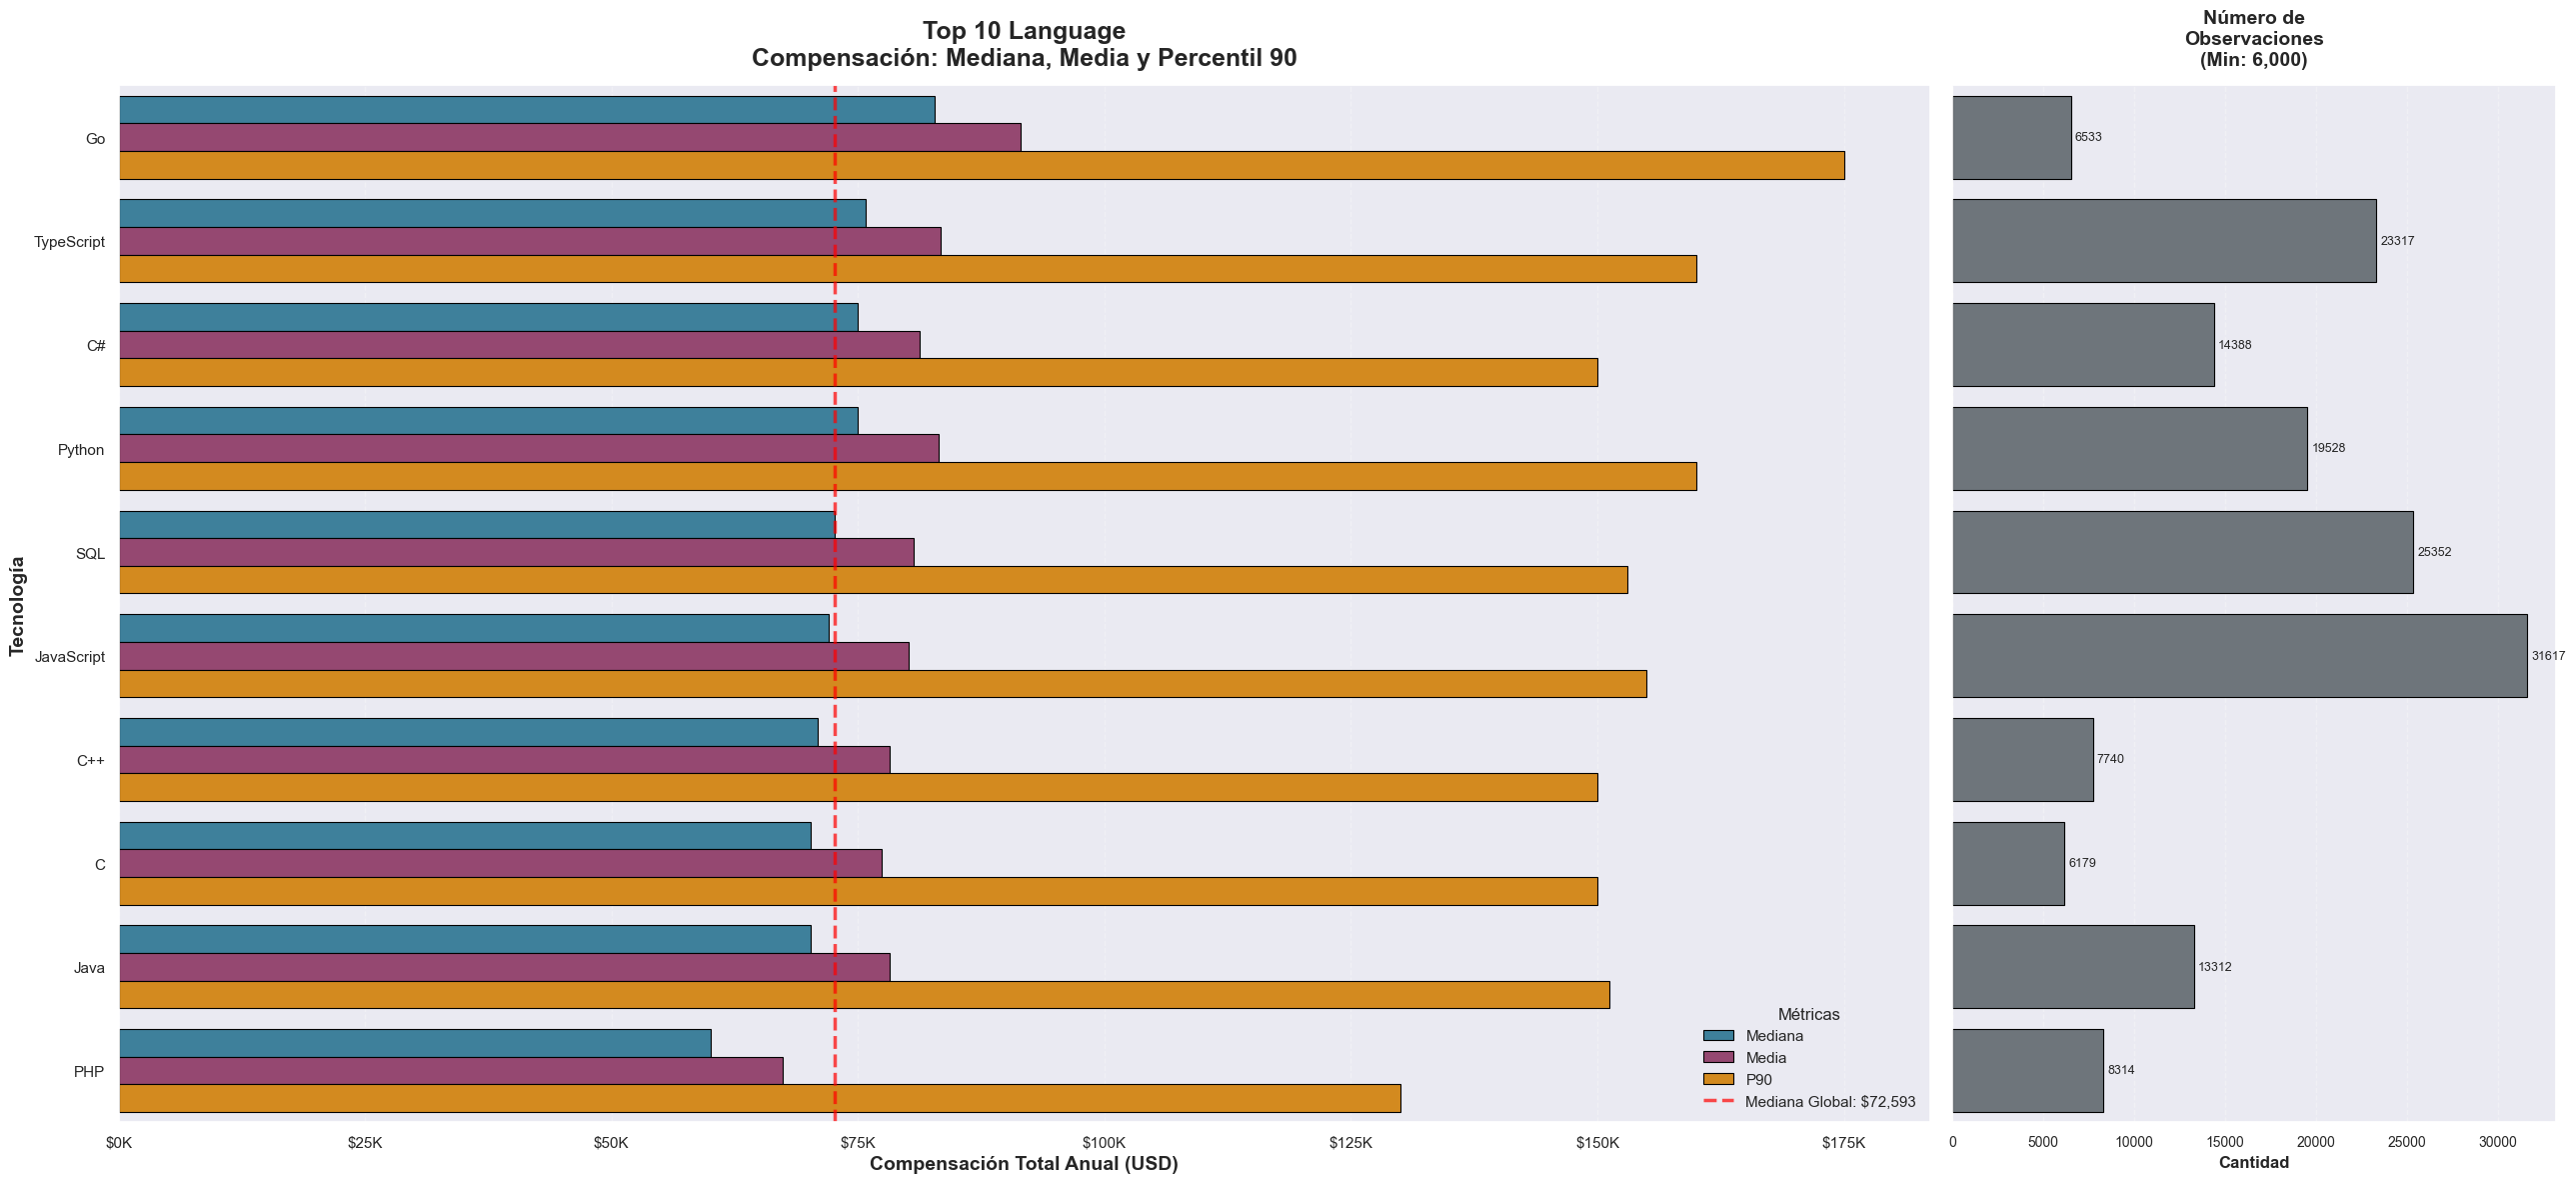

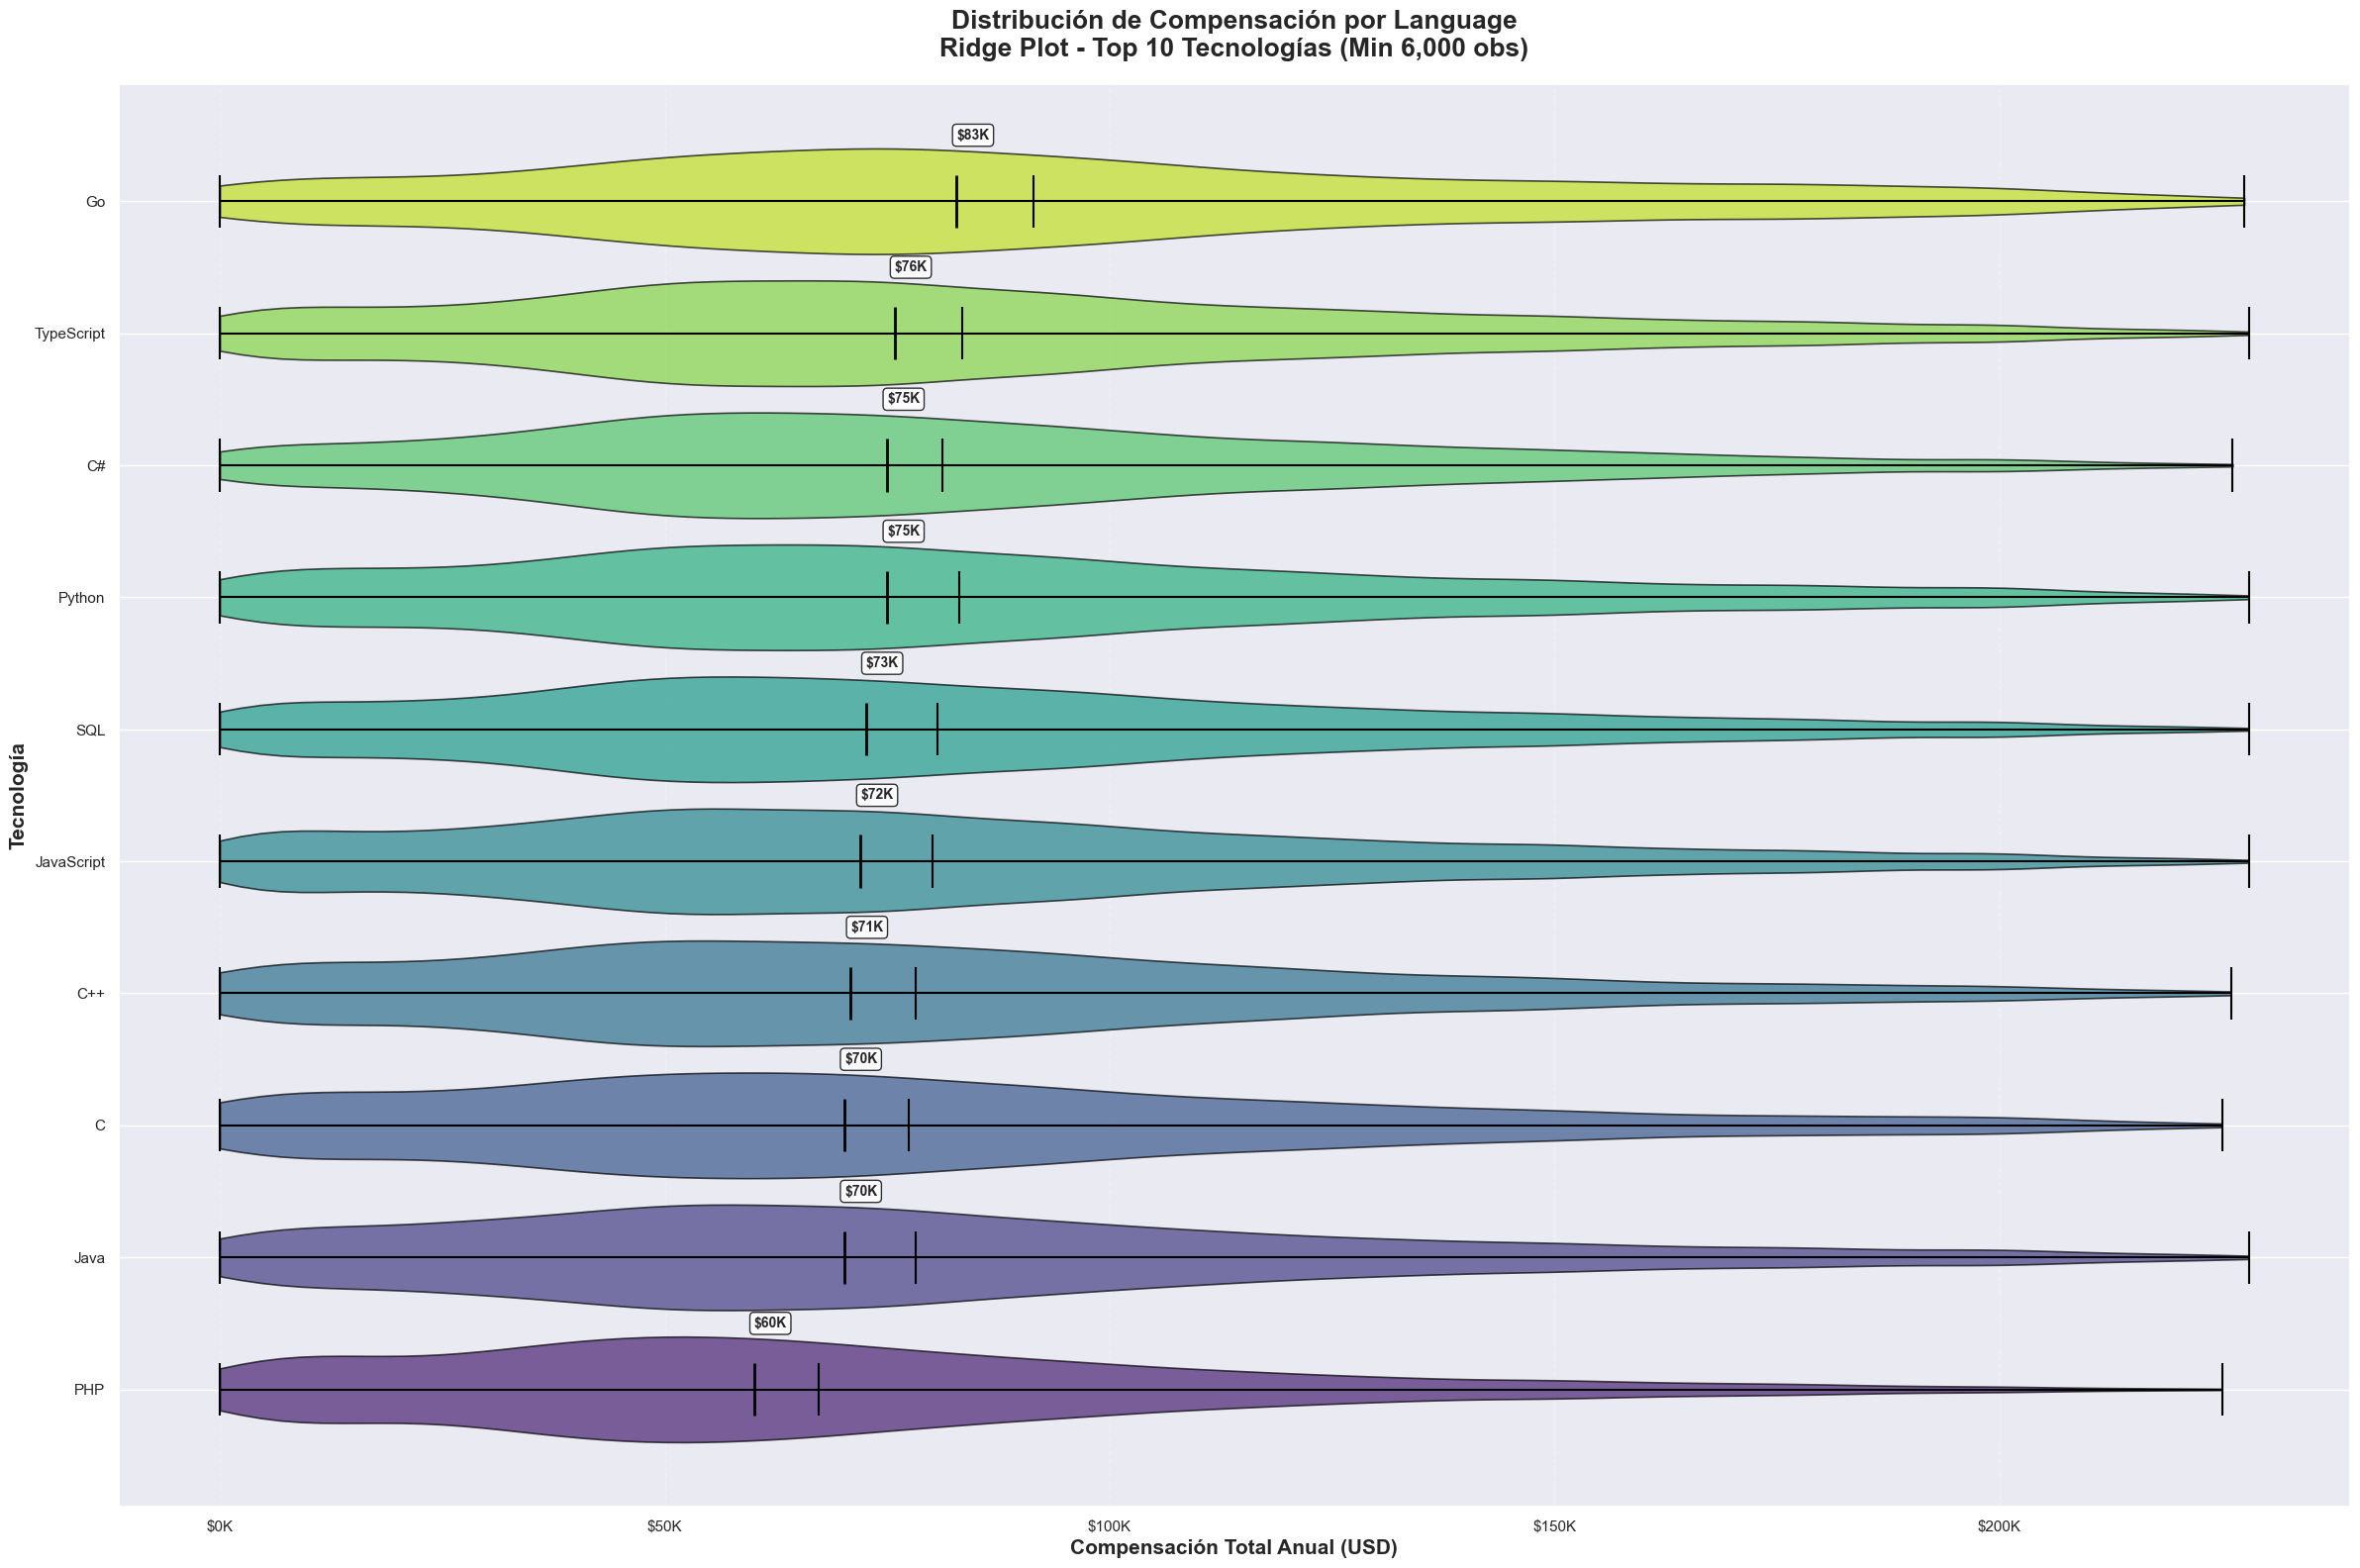

                            📊 TOP 10 LANGUAGE POR COMPENSACIÓN                            

🎯 VALIDACIÓN DE HIPÓTESIS
   ✅ Language SÍ impacta la compensación:
      • Mejor pagada:  Go                   → $    82,800
      • Menor pagada:  PHP                  → $    60,027
      • Brecha salarial:  37.9%
      • Premium (5/10): Superan mediana global ($72,593)


📈 RANKING Y ESTADÍSTICAS (Min 6,000 observaciones)
──────────────────────────────────────────────────────────────────────────────────────────

⭐ # 4 Go                        
Mediana: $    82,800 (+14.1%)
Media: $    91,476  |  Top 10%: $   175,000  |  
IQR: $    52,333-$   126,000  |  N:   6,533

⭐ #10 TypeScript                
Mediana: $    75,810 ( +4.4%)
Media: $    83,381  |  Top 10%: $   160,000  |  
IQR: $    46,800-$   115,000  |  N:  23,317

⭐ # 2 C#                        
Mediana: $    75,000 ( +3.3%)
Media: $    81,244  |  Top 10%: $   150,000  |  
IQR: $    47,296-$   110,000  |  N:  14,388

⭐ # 8 Python       

In [327]:
# ============================================================================
# ANÁLISIS DE LENGUAJES DE PROGRAMACIÓN Y COMPENSACIÓN
# ============================================================================
variable_tecnologia = 'LanguageHaveWorkedWith'
min_observaciones = 6_000
top_n = 10
tecnologias_a_excluir = ['Bash/Shell (all shells)', 'PowerShell', 'HTML/CSS']
# 1. Gráfico de barras con métricas estadísticas (Mediana, Media, Moda)
crear_barplot_tecnologias_metricas(
  df_filtrado_sin_outliers,
  variable_tecnologia=variable_tecnologia,
  top_n=top_n,
  min_observaciones=min_observaciones,
  tecnologias_excluir=tecnologias_a_excluir
)

# 2. Ridge Plot - Distribuciones completas por lenguaje
crear_ridgeplot_tecnologias(
  df_filtrado_sin_outliers,
  variable_tecnologia=variable_tecnologia,
  top_n=top_n,
  min_observaciones=min_observaciones,
  tecnologias_excluir=tecnologias_a_excluir
)

# 3. Resumen estadístico impreso
imprimir_top_tecnologias(
  df_filtrado_sin_outliers,
  variable_tecnologia=variable_tecnologia,
  top_n=top_n,
  min_observaciones=min_observaciones,
  tecnologias_excluir=tecnologias_a_excluir
)

#### Frameworks web (WebframeHaveWorkedWith) vs Compensación Total (CompTotal)

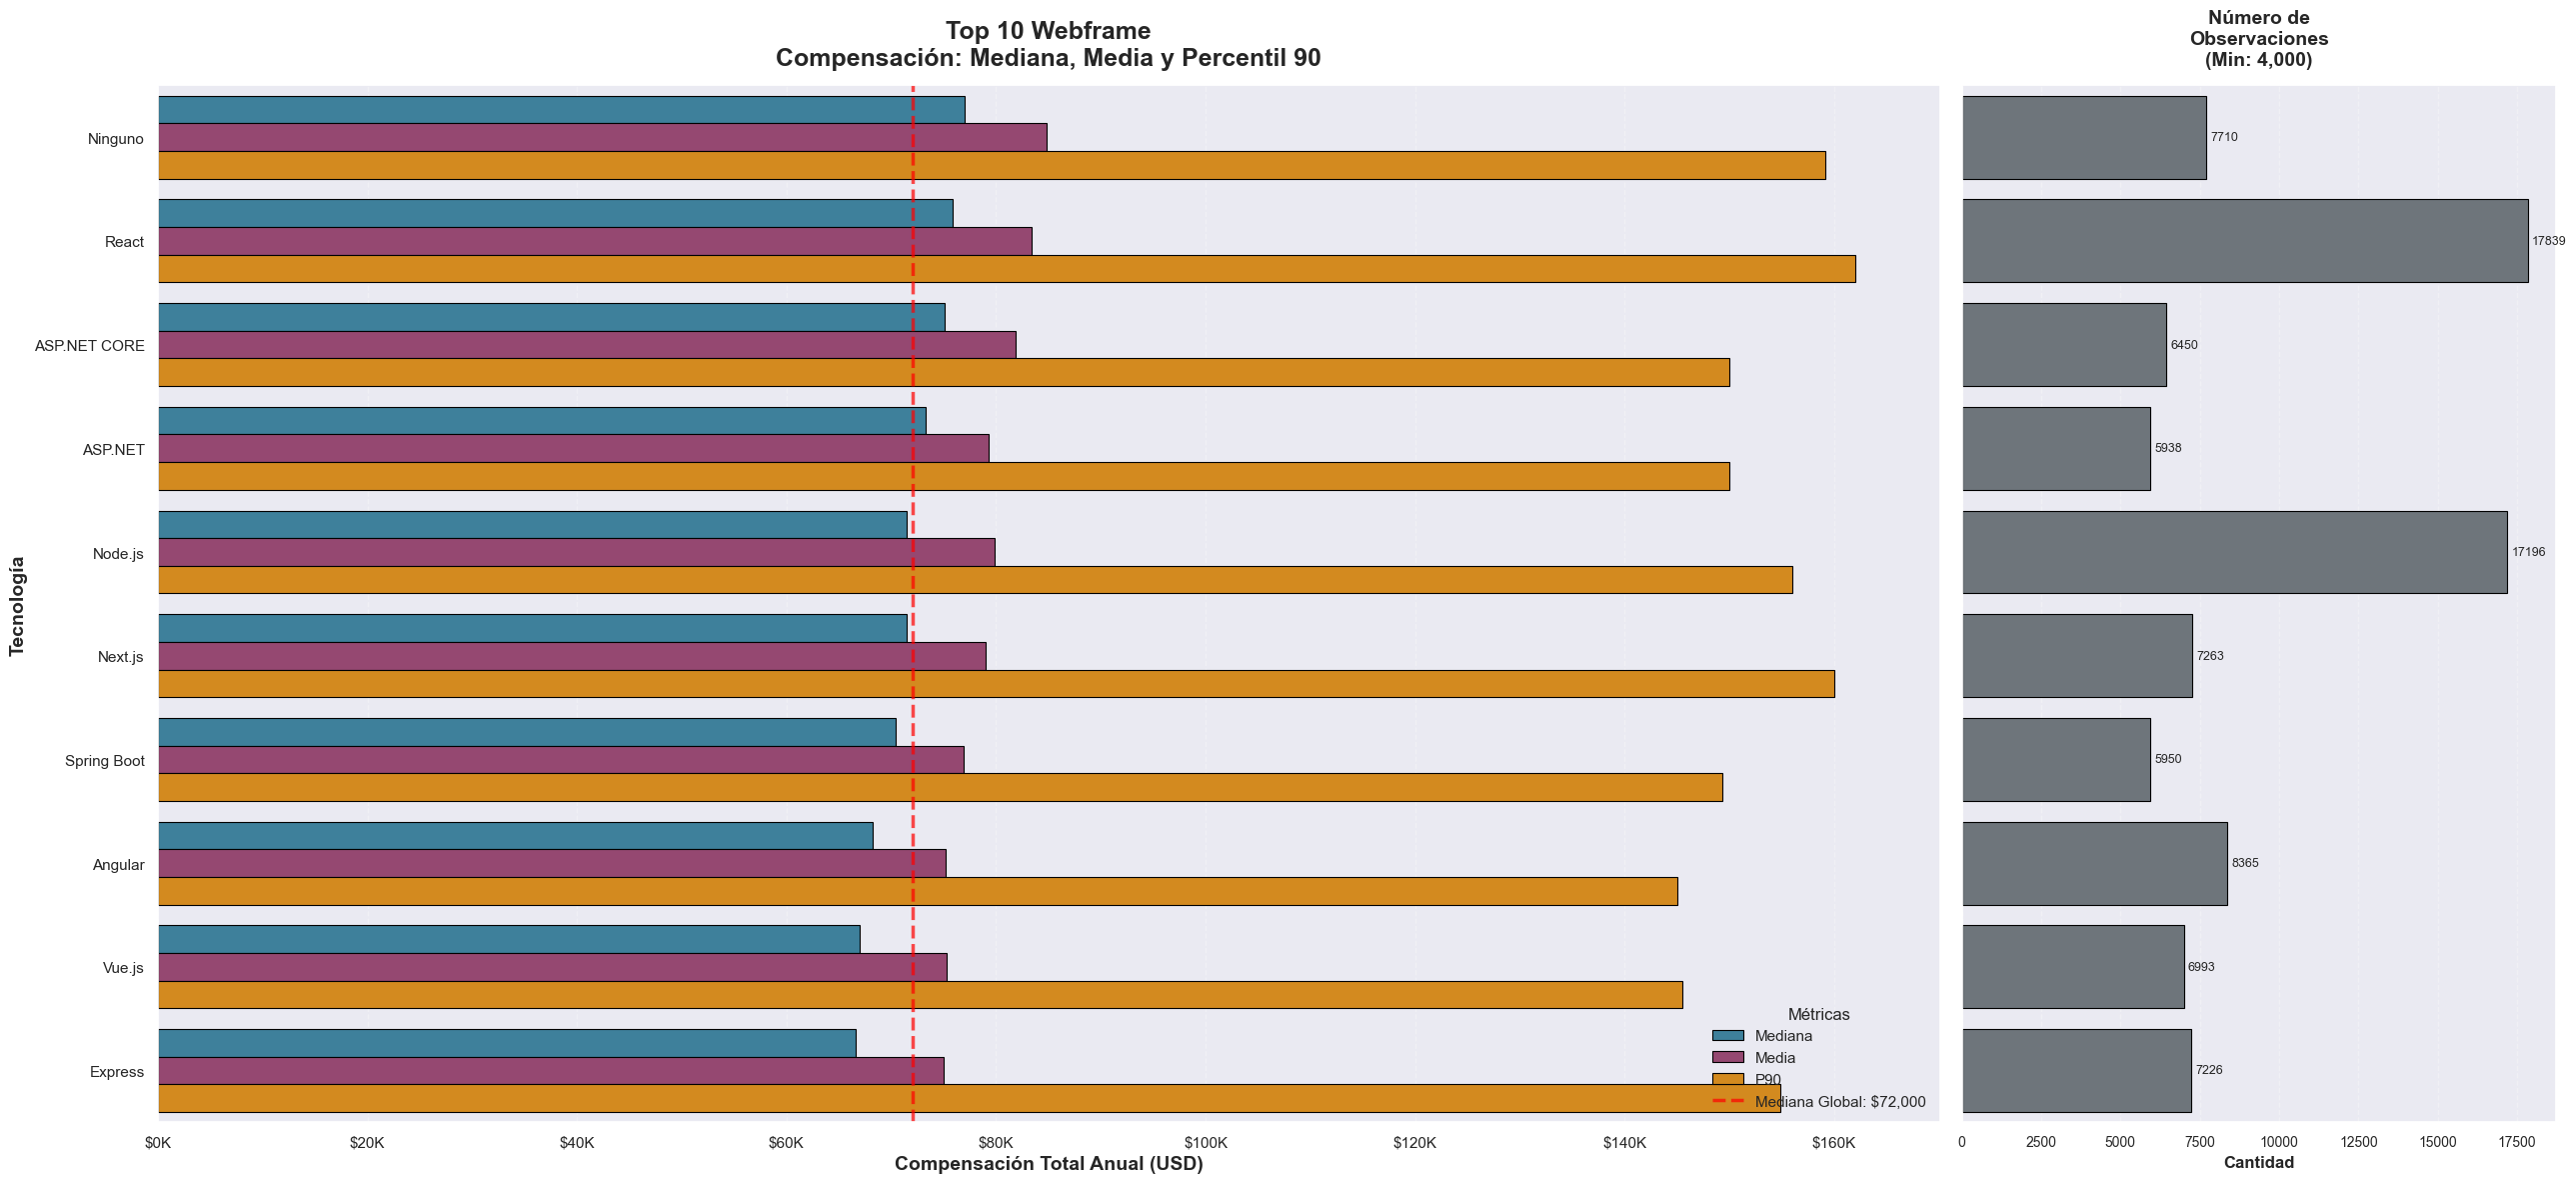

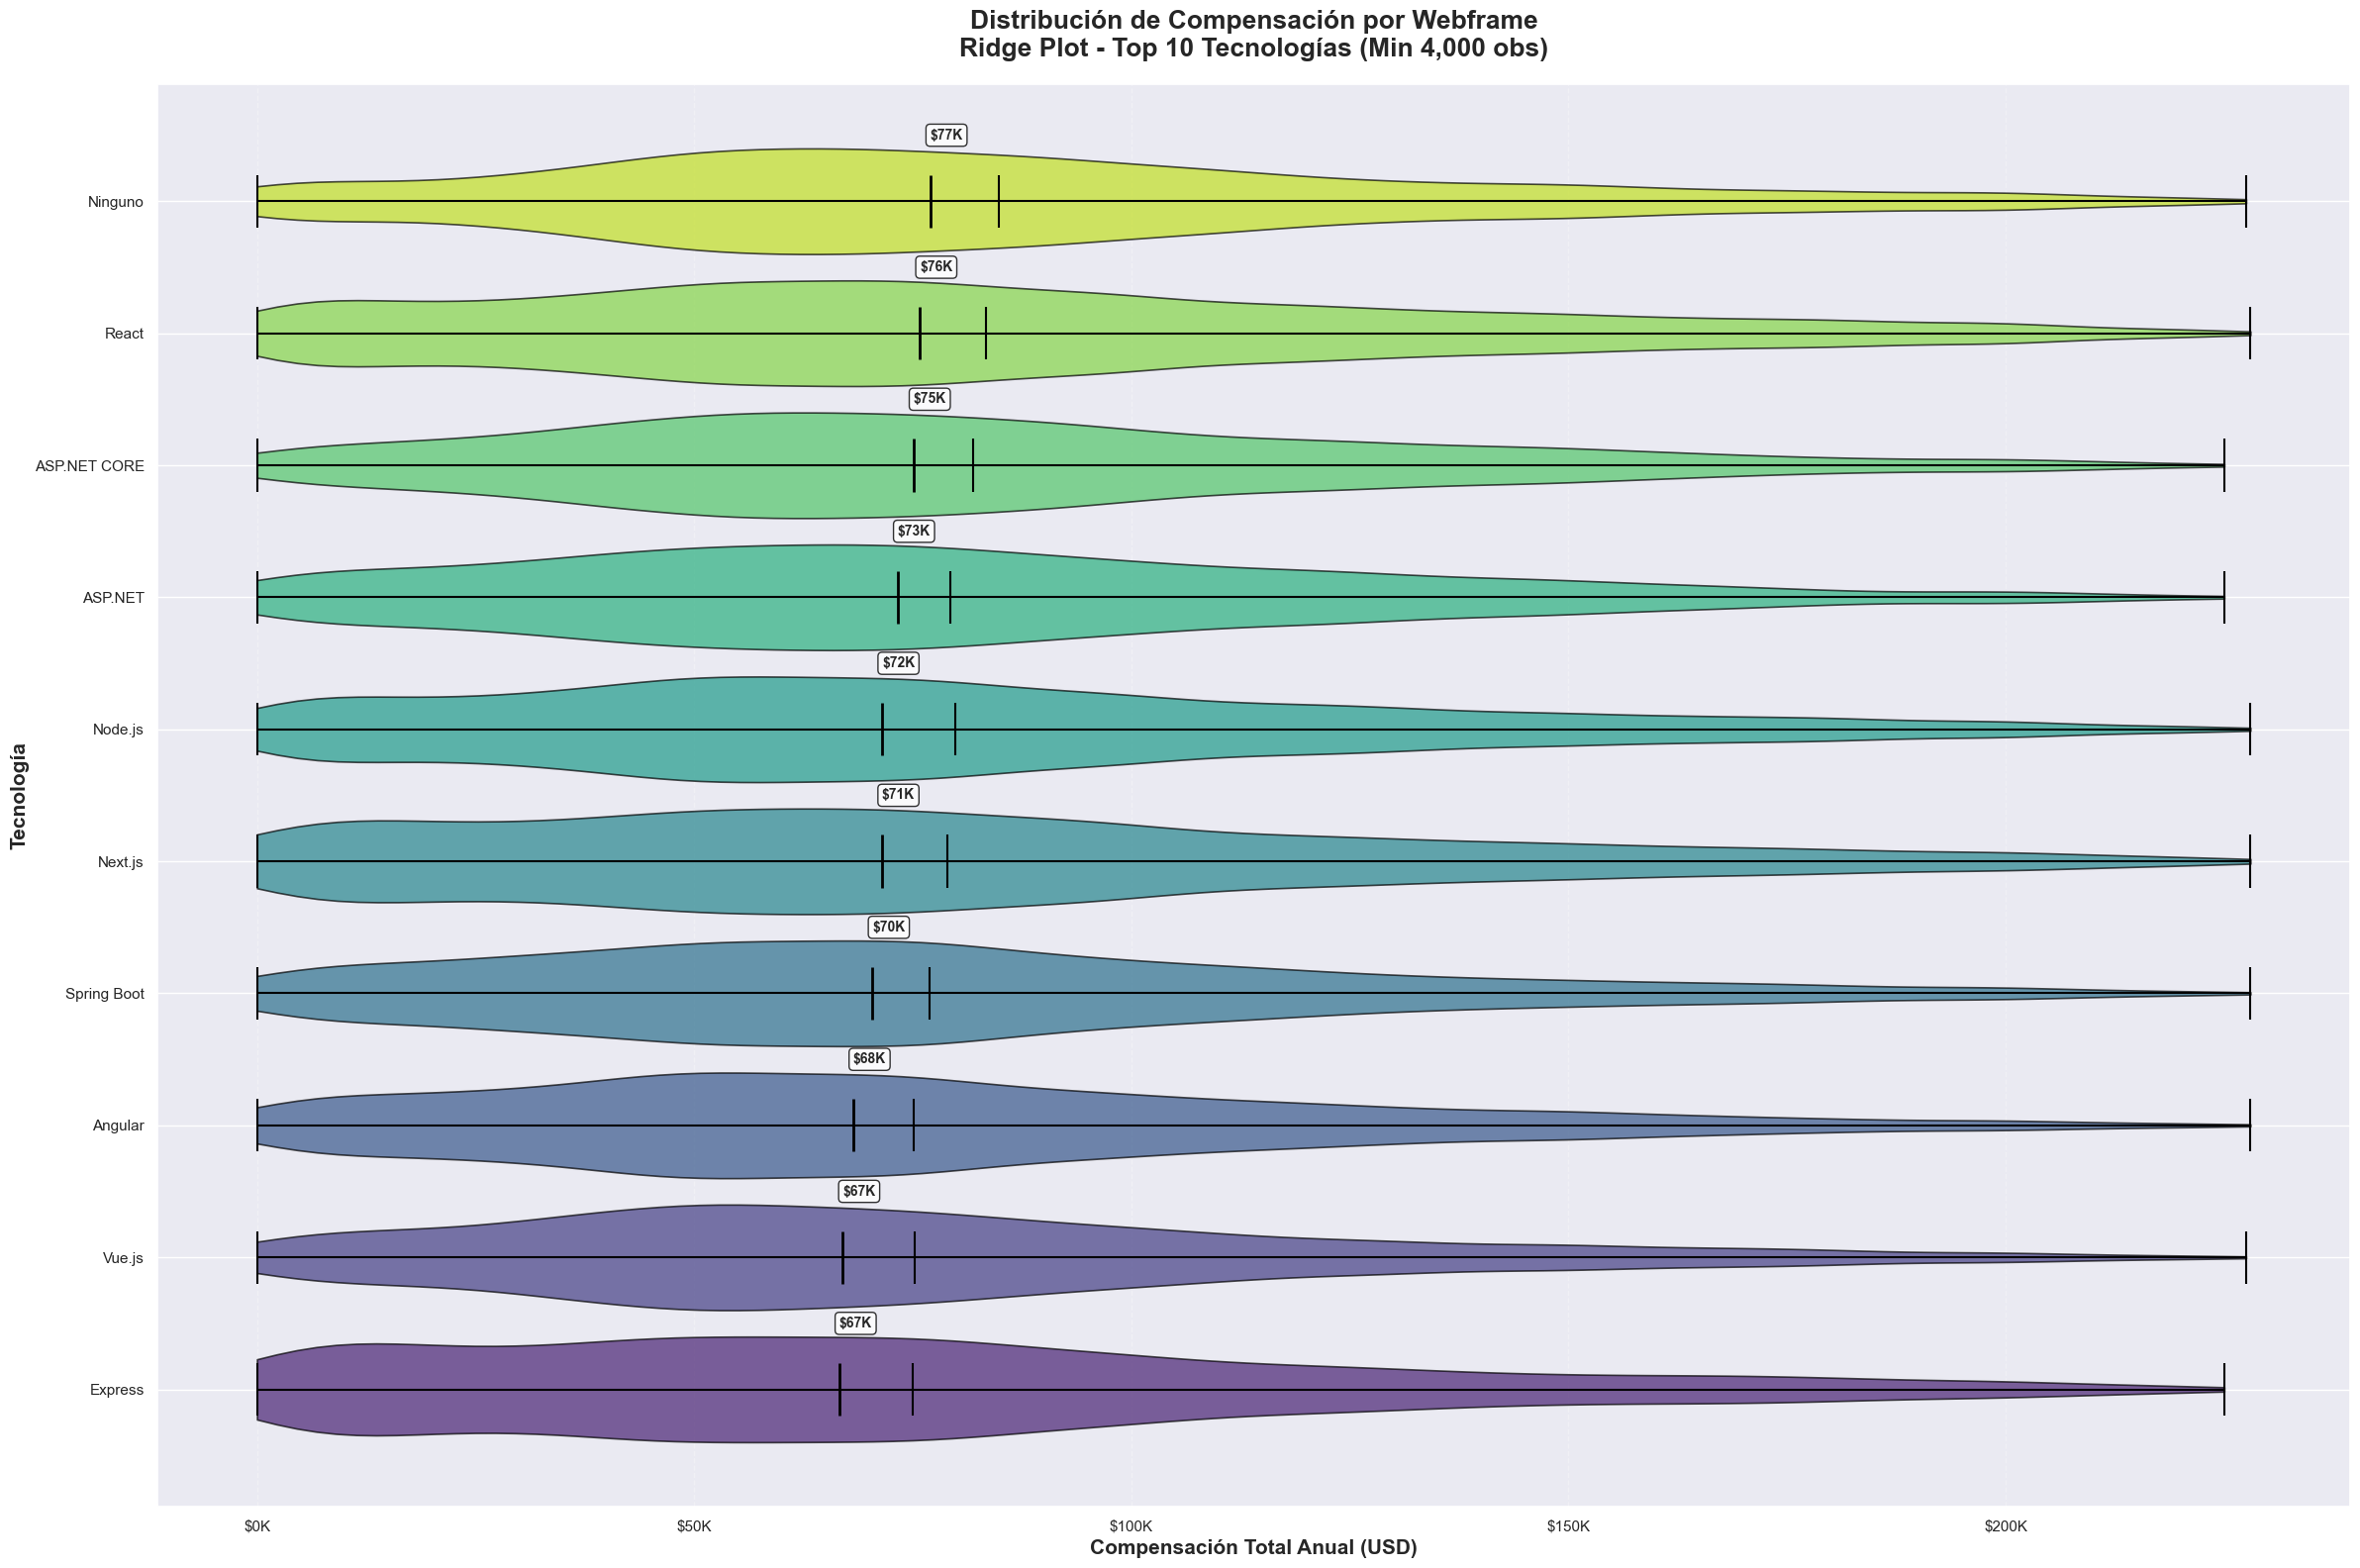

                            📊 TOP 10 WEBFRAME POR COMPENSACIÓN                            

🎯 VALIDACIÓN DE HIPÓTESIS
   ✅ Webframe SÍ impacta la compensación:
      • Mejor pagada:  Ninguno              → $    76,993
      • Menor pagada:  Express              → $    66,600
      • Brecha salarial:  15.6%
      • Premium (4/10): Superan mediana global ($72,000)


📈 RANKING Y ESTADÍSTICAS (Min 4,000 observaciones)
──────────────────────────────────────────────────────────────────────────────────────────

⭐ # 6 Ninguno                   
Mediana: $    76,993 ( +6.9%)
Media: $    84,865  |  Top 10%: $   159,102  |  
IQR: $    49,496-$   113,012  |  N:   7,710

⭐ # 8 React                     
Mediana: $    75,822 ( +5.3%)
Media: $    83,380  |  Top 10%: $   162,000  |  
IQR: $    43,996-$   117,000  |  N:  17,839

⭐ # 2 ASP.NET CORE              
Mediana: $    75,079 ( +4.3%)
Media: $    81,889  |  Top 10%: $   150,000  |  
IQR: $    47,652-$   110,000  |  N:   6,450

⭐ # 1 ASP.NET      

In [335]:
# ============================================================================
# ANÁLISIS DE FRAMEWORK/LIBRERIAS DE PROGRAMACIÓN Y COMPENSACIÓN
# ============================================================================
variable_tecnologia = 'WebframeHaveWorkedWith'
min_observaciones = 4_000
top_n = 10
tecnologias_a_excluir = []
# 1. Gráfico de barras con métricas estadísticas (Mediana, Media, Moda)
crear_barplot_tecnologias_metricas(
  df_filtrado_sin_outliers,
  variable_tecnologia=variable_tecnologia,
  top_n=top_n,
  min_observaciones=min_observaciones,
  tecnologias_excluir=tecnologias_a_excluir
)

# 2. Ridge Plot - Distribuciones completas por lenguaje
crear_ridgeplot_tecnologias(
  df_filtrado_sin_outliers,
  variable_tecnologia=variable_tecnologia,
  top_n=top_n,
  min_observaciones=min_observaciones,
  tecnologias_excluir=tecnologias_a_excluir
)

# 3. Resumen estadístico impreso
imprimir_top_tecnologias(
  df_filtrado_sin_outliers,
  variable_tecnologia=variable_tecnologia,
  top_n=top_n,
  min_observaciones=min_observaciones,
  tecnologias_excluir=tecnologias_a_excluir
)

#### Bases de datos (DatabaseHaveWorkedWith) vs Compensación Total (CompTotal)

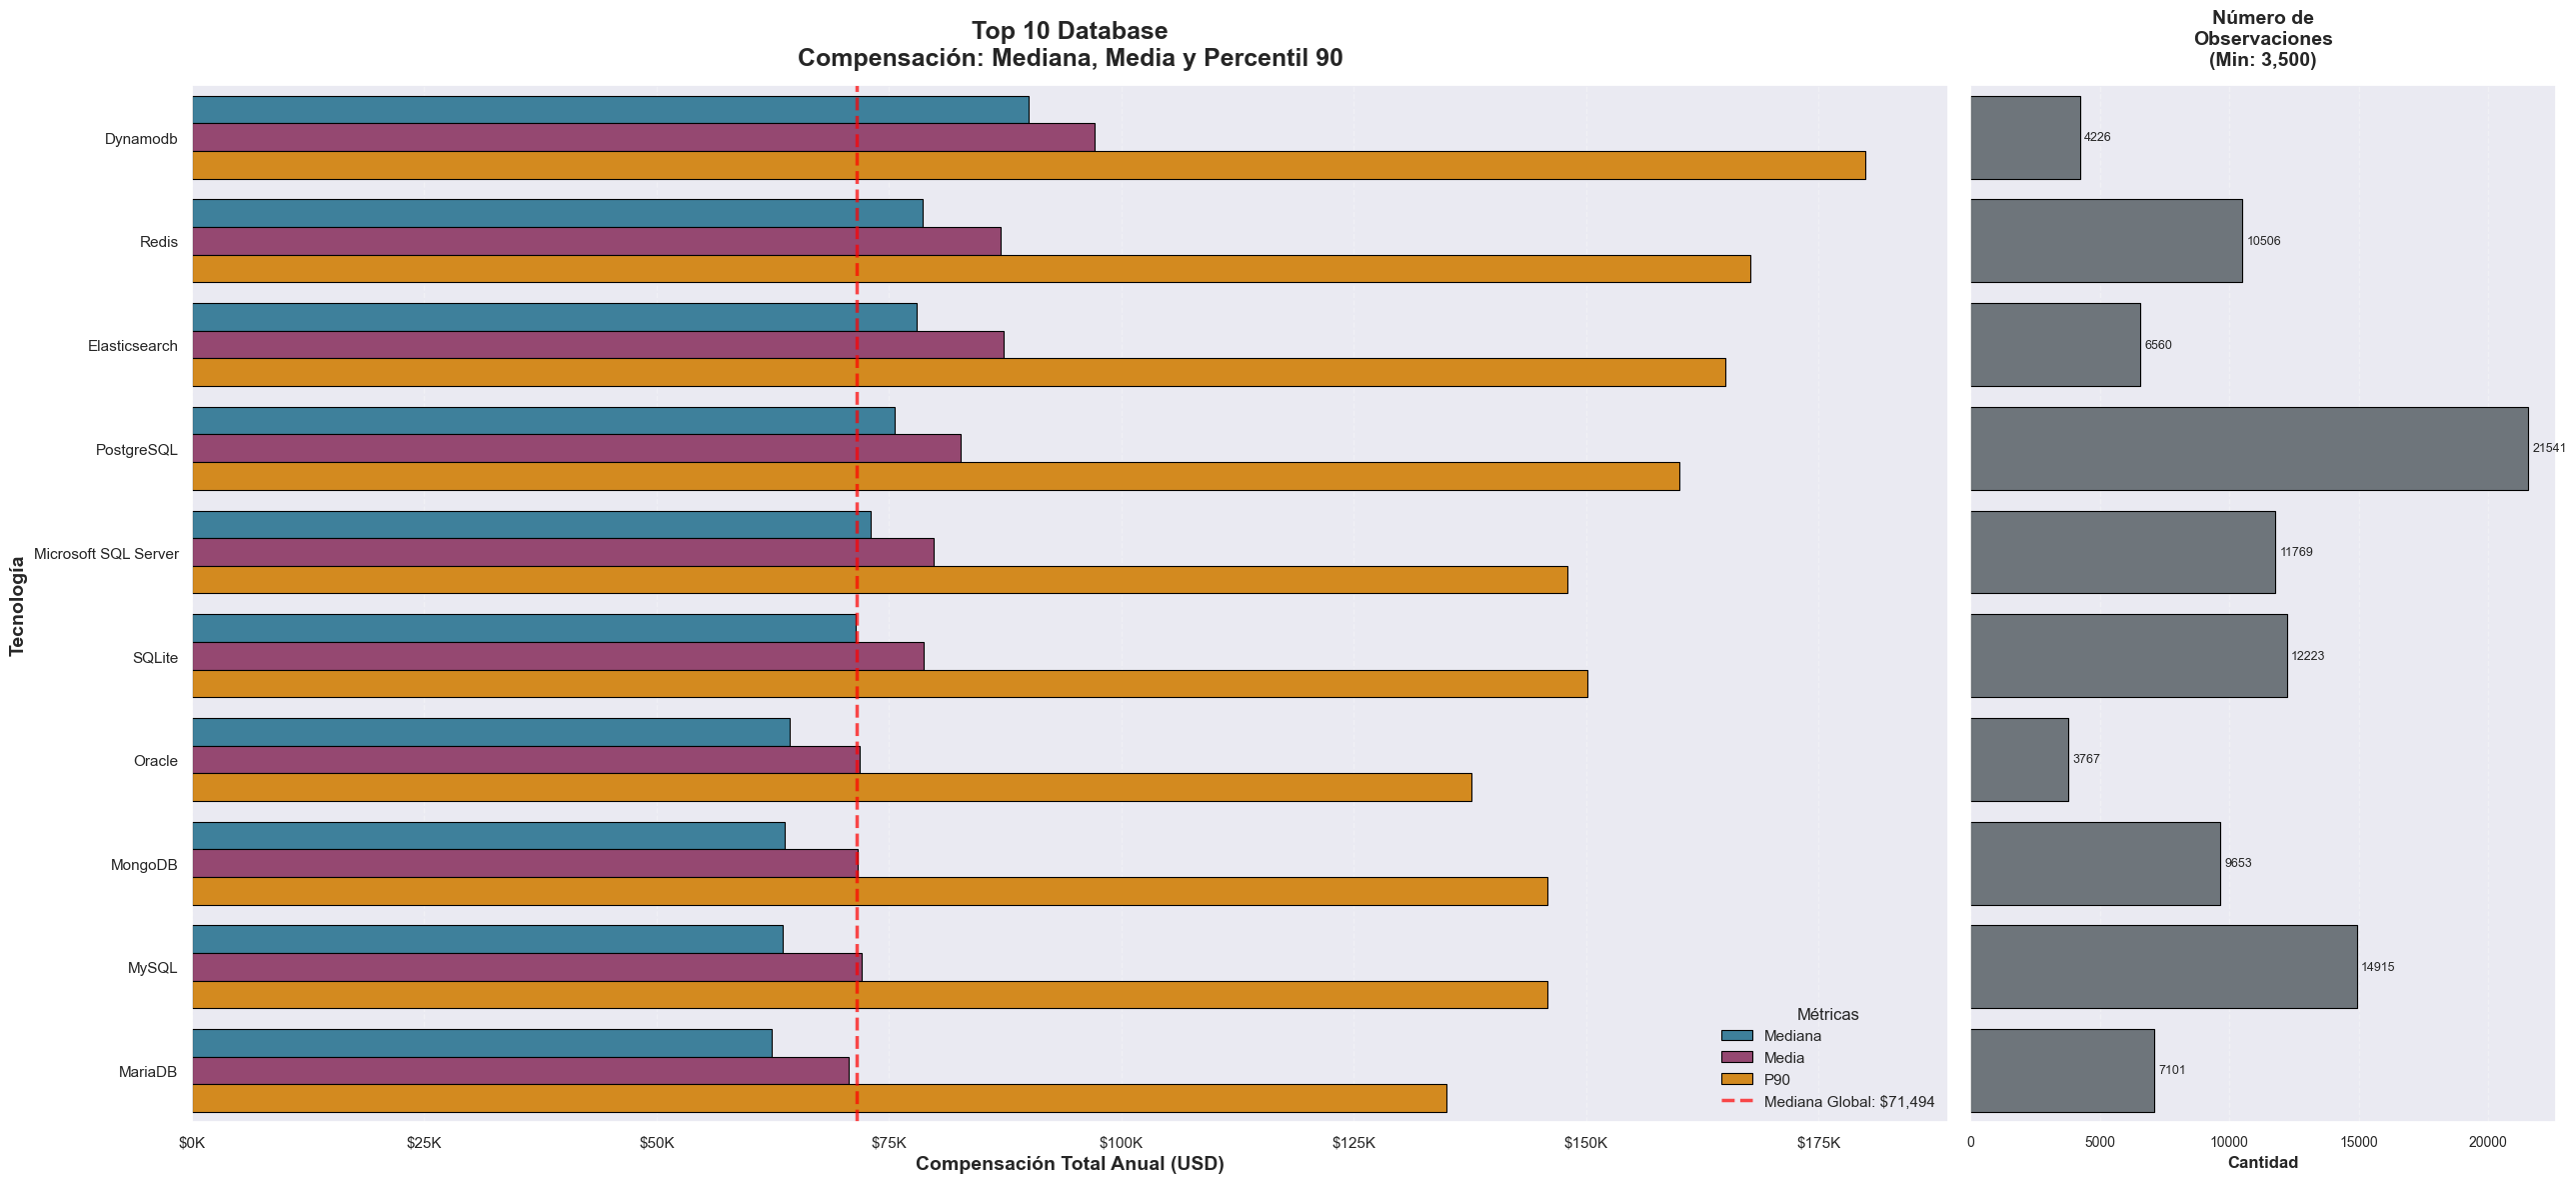

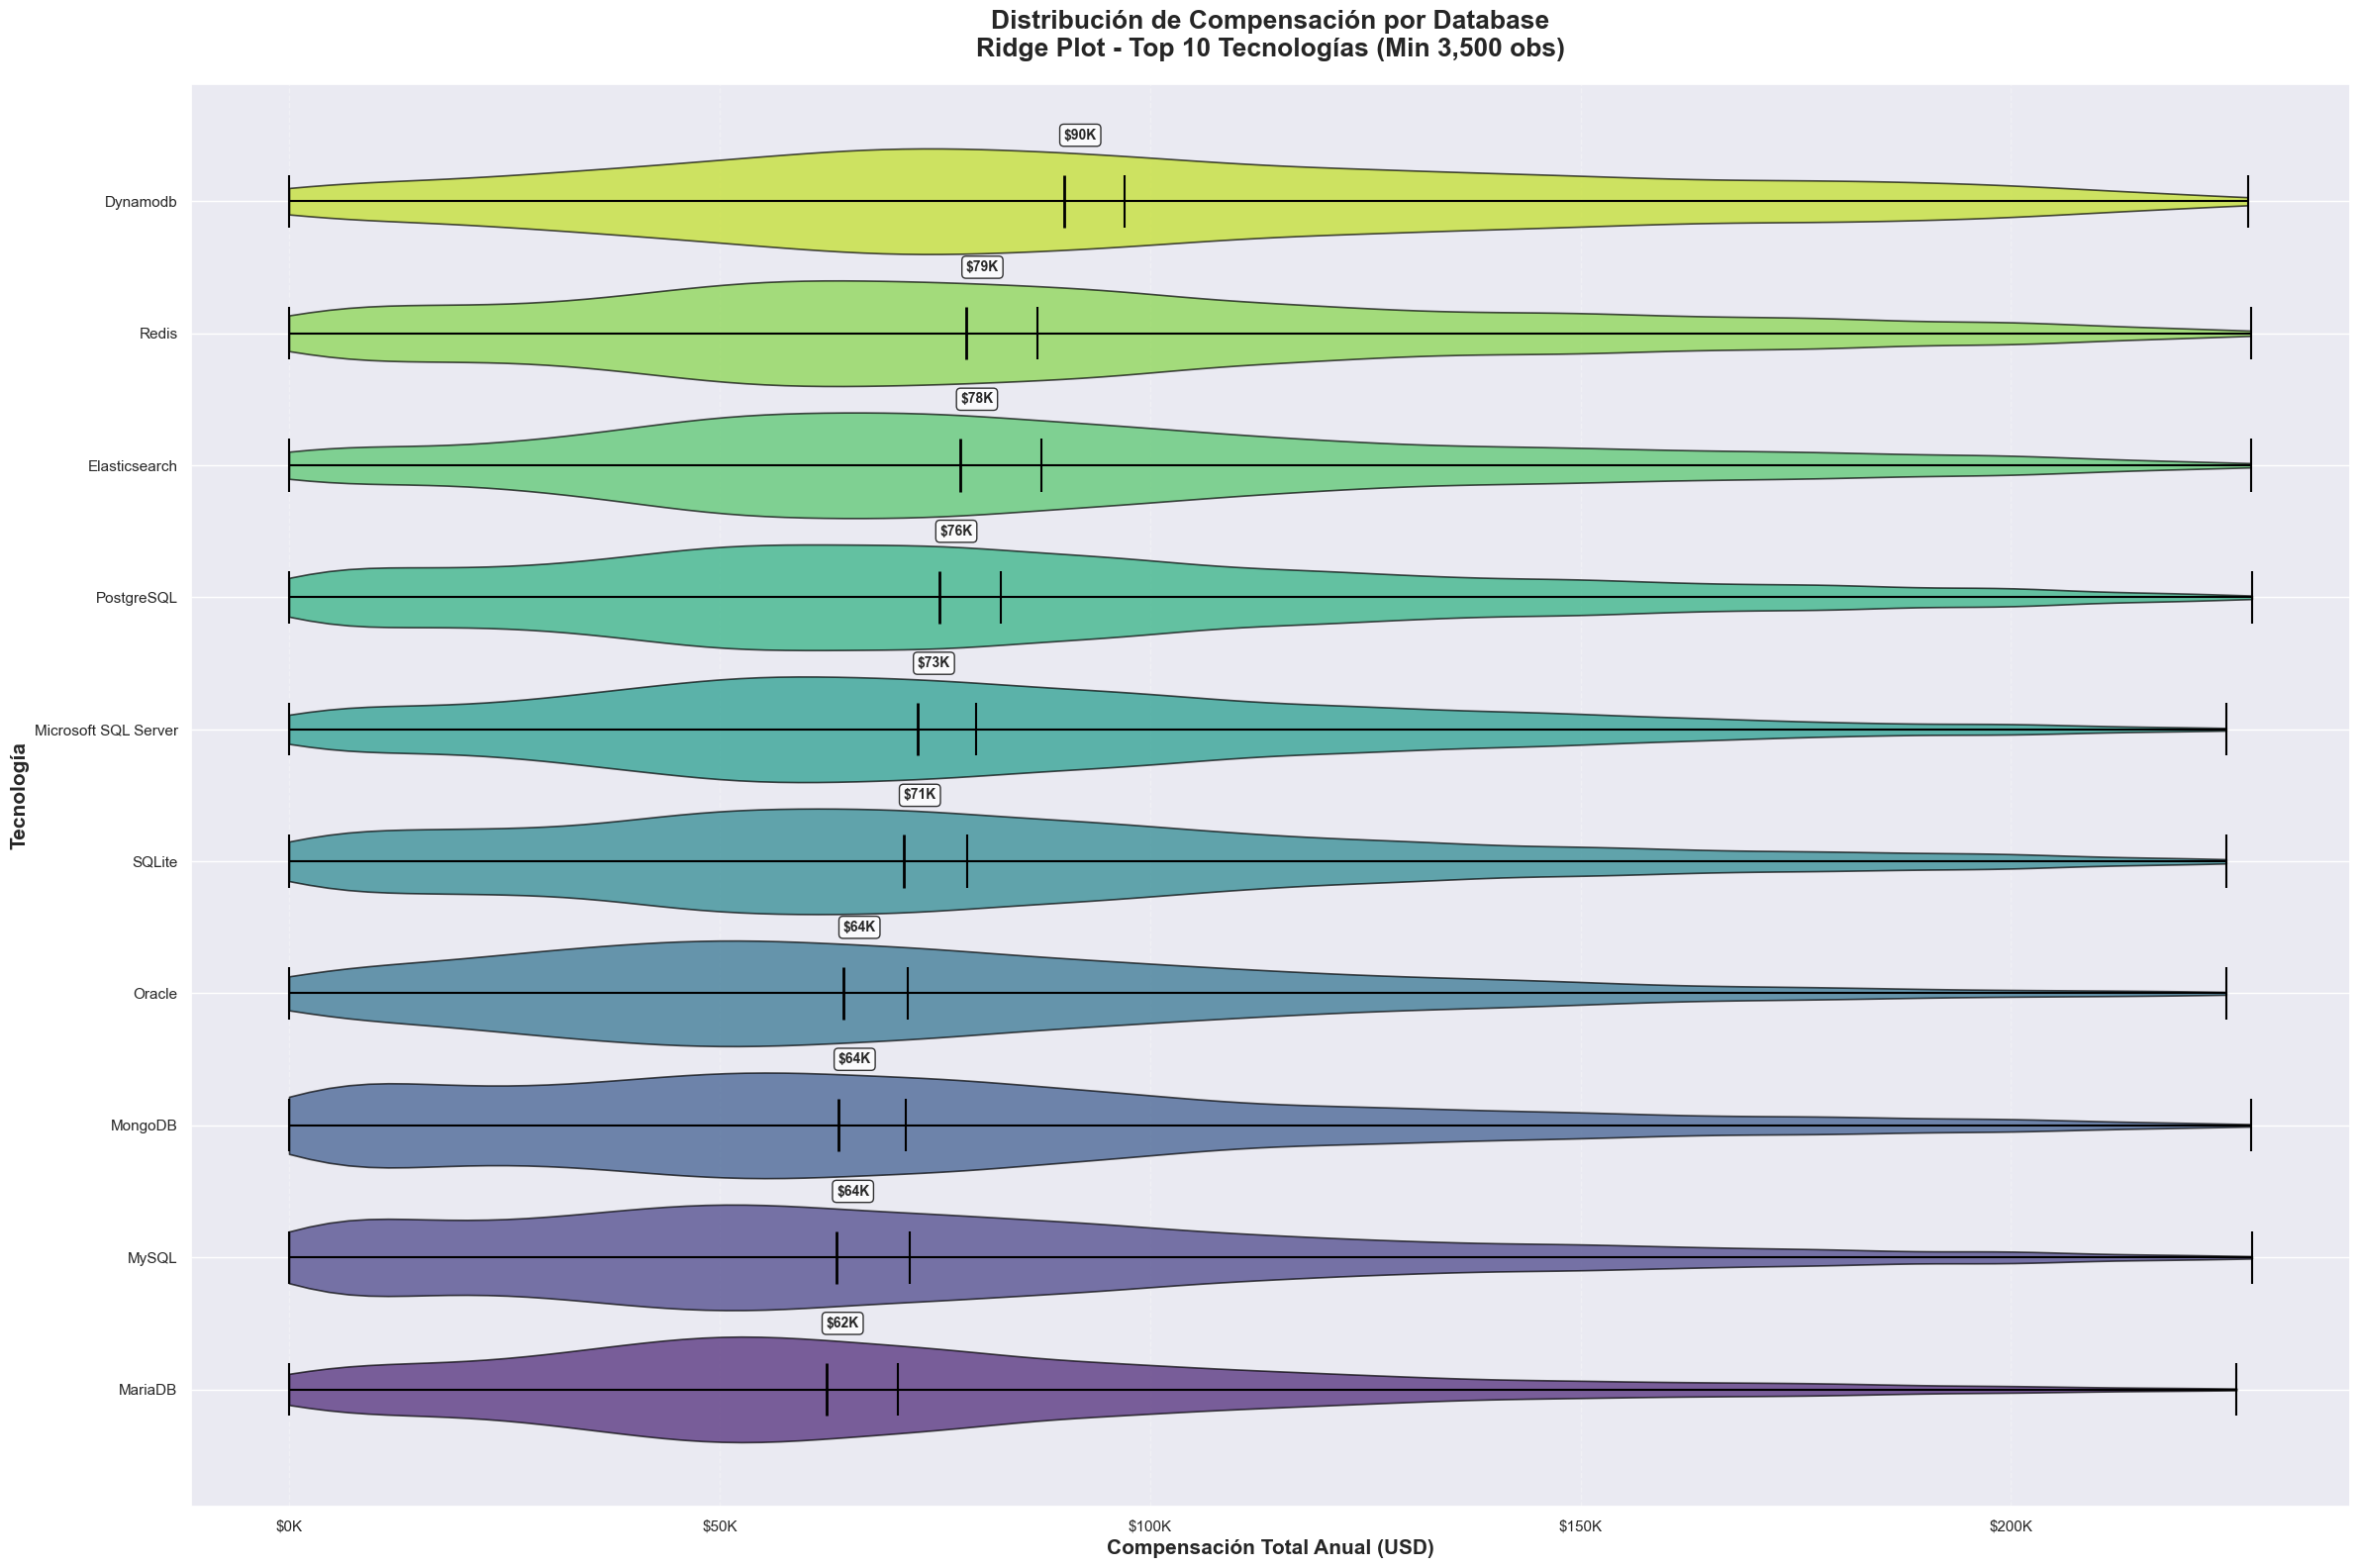

                            📊 TOP 10 DATABASE POR COMPENSACIÓN                            

🎯 VALIDACIÓN DE HIPÓTESIS
   ✅ Database SÍ impacta la compensación:
      • Mejor pagada:  Dynamodb             → $    90,000
      • Menor pagada:  MariaDB              → $    62,400
      • Brecha salarial:  44.2%
      • Premium (5/10): Superan mediana global ($71,494)


📈 RANKING Y ESTADÍSTICAS (Min 3,500 observaciones)
──────────────────────────────────────────────────────────────────────────────────────────

💎 # 1 Dynamodb                  
Mediana: $    90,000 (+25.9%)
Media: $    97,074  |  Top 10%: $   180,000  |  
IQR: $    56,866-$   135,000  |  N:   4,226

⭐ # 9 Redis                     
Mediana: $    78,634 (+10.0%)
Media: $    86,970  |  Top 10%: $   167,676  |  
IQR: $    48,396-$   120,000  |  N:  10,506

⭐ # 2 Elasticsearch             
Mediana: $    78,000 ( +9.1%)
Media: $    87,378  |  Top 10%: $   165,000  |  
IQR: $    50,846-$   118,800  |  N:   6,560

⭐ # 8 PostgreSQL   

In [338]:
# ============================================================================
# ANÁLISIS DE BASE DE DATOS Y COMPENSACIÓN
# ============================================================================
variable_tecnologia = 'DatabaseHaveWorkedWith'
min_observaciones = 3_500
top_n = 10
tecnologias_a_excluir = ['Ninguno']
# 1. Gráfico de barras con métricas estadísticas (Mediana, Media, Moda)
crear_barplot_tecnologias_metricas(
  df_filtrado_sin_outliers,
  variable_tecnologia=variable_tecnologia,
  top_n=top_n,
  min_observaciones=min_observaciones,
  tecnologias_excluir=tecnologias_a_excluir
)

# 2. Ridge Plot - Distribuciones completas por lenguaje
crear_ridgeplot_tecnologias(
  df_filtrado_sin_outliers,
  variable_tecnologia=variable_tecnologia,
  top_n=top_n,
  min_observaciones=min_observaciones,
  tecnologias_excluir=tecnologias_a_excluir
)

# 3. Resumen estadístico impreso
imprimir_top_tecnologias(
  df_filtrado_sin_outliers,
  variable_tecnologia=variable_tecnologia,
  top_n=top_n,
  min_observaciones=min_observaciones,
  tecnologias_excluir=tecnologias_a_excluir
)

#### Plataformas (PlatformHaveWorkedWith) vs Compensación Total (CompTotal)

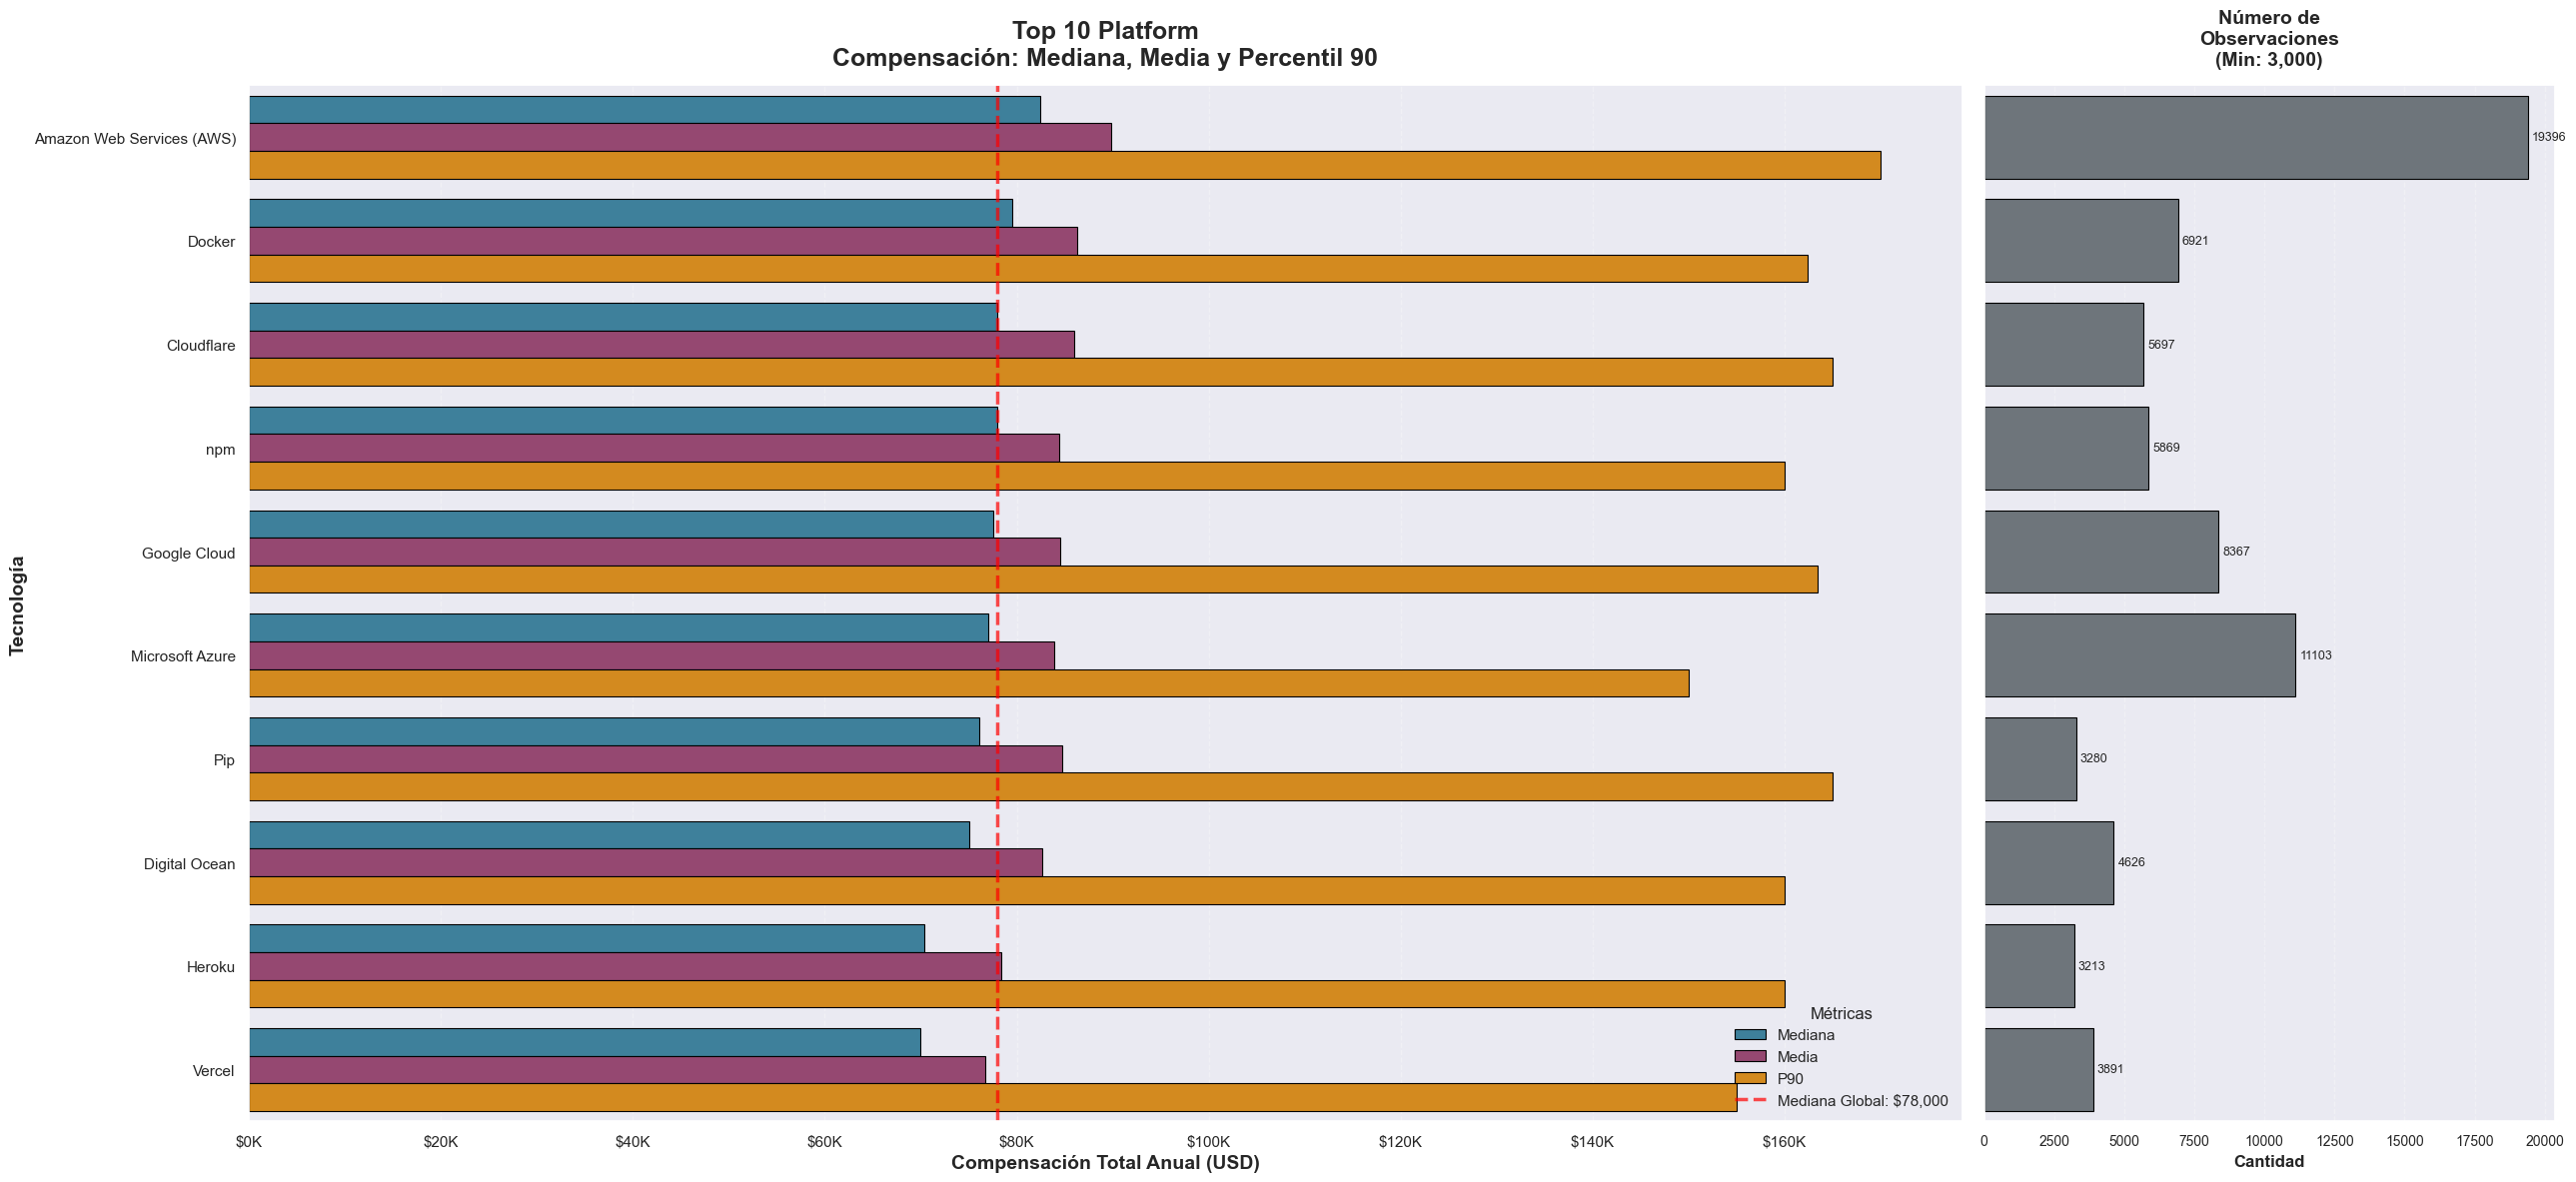

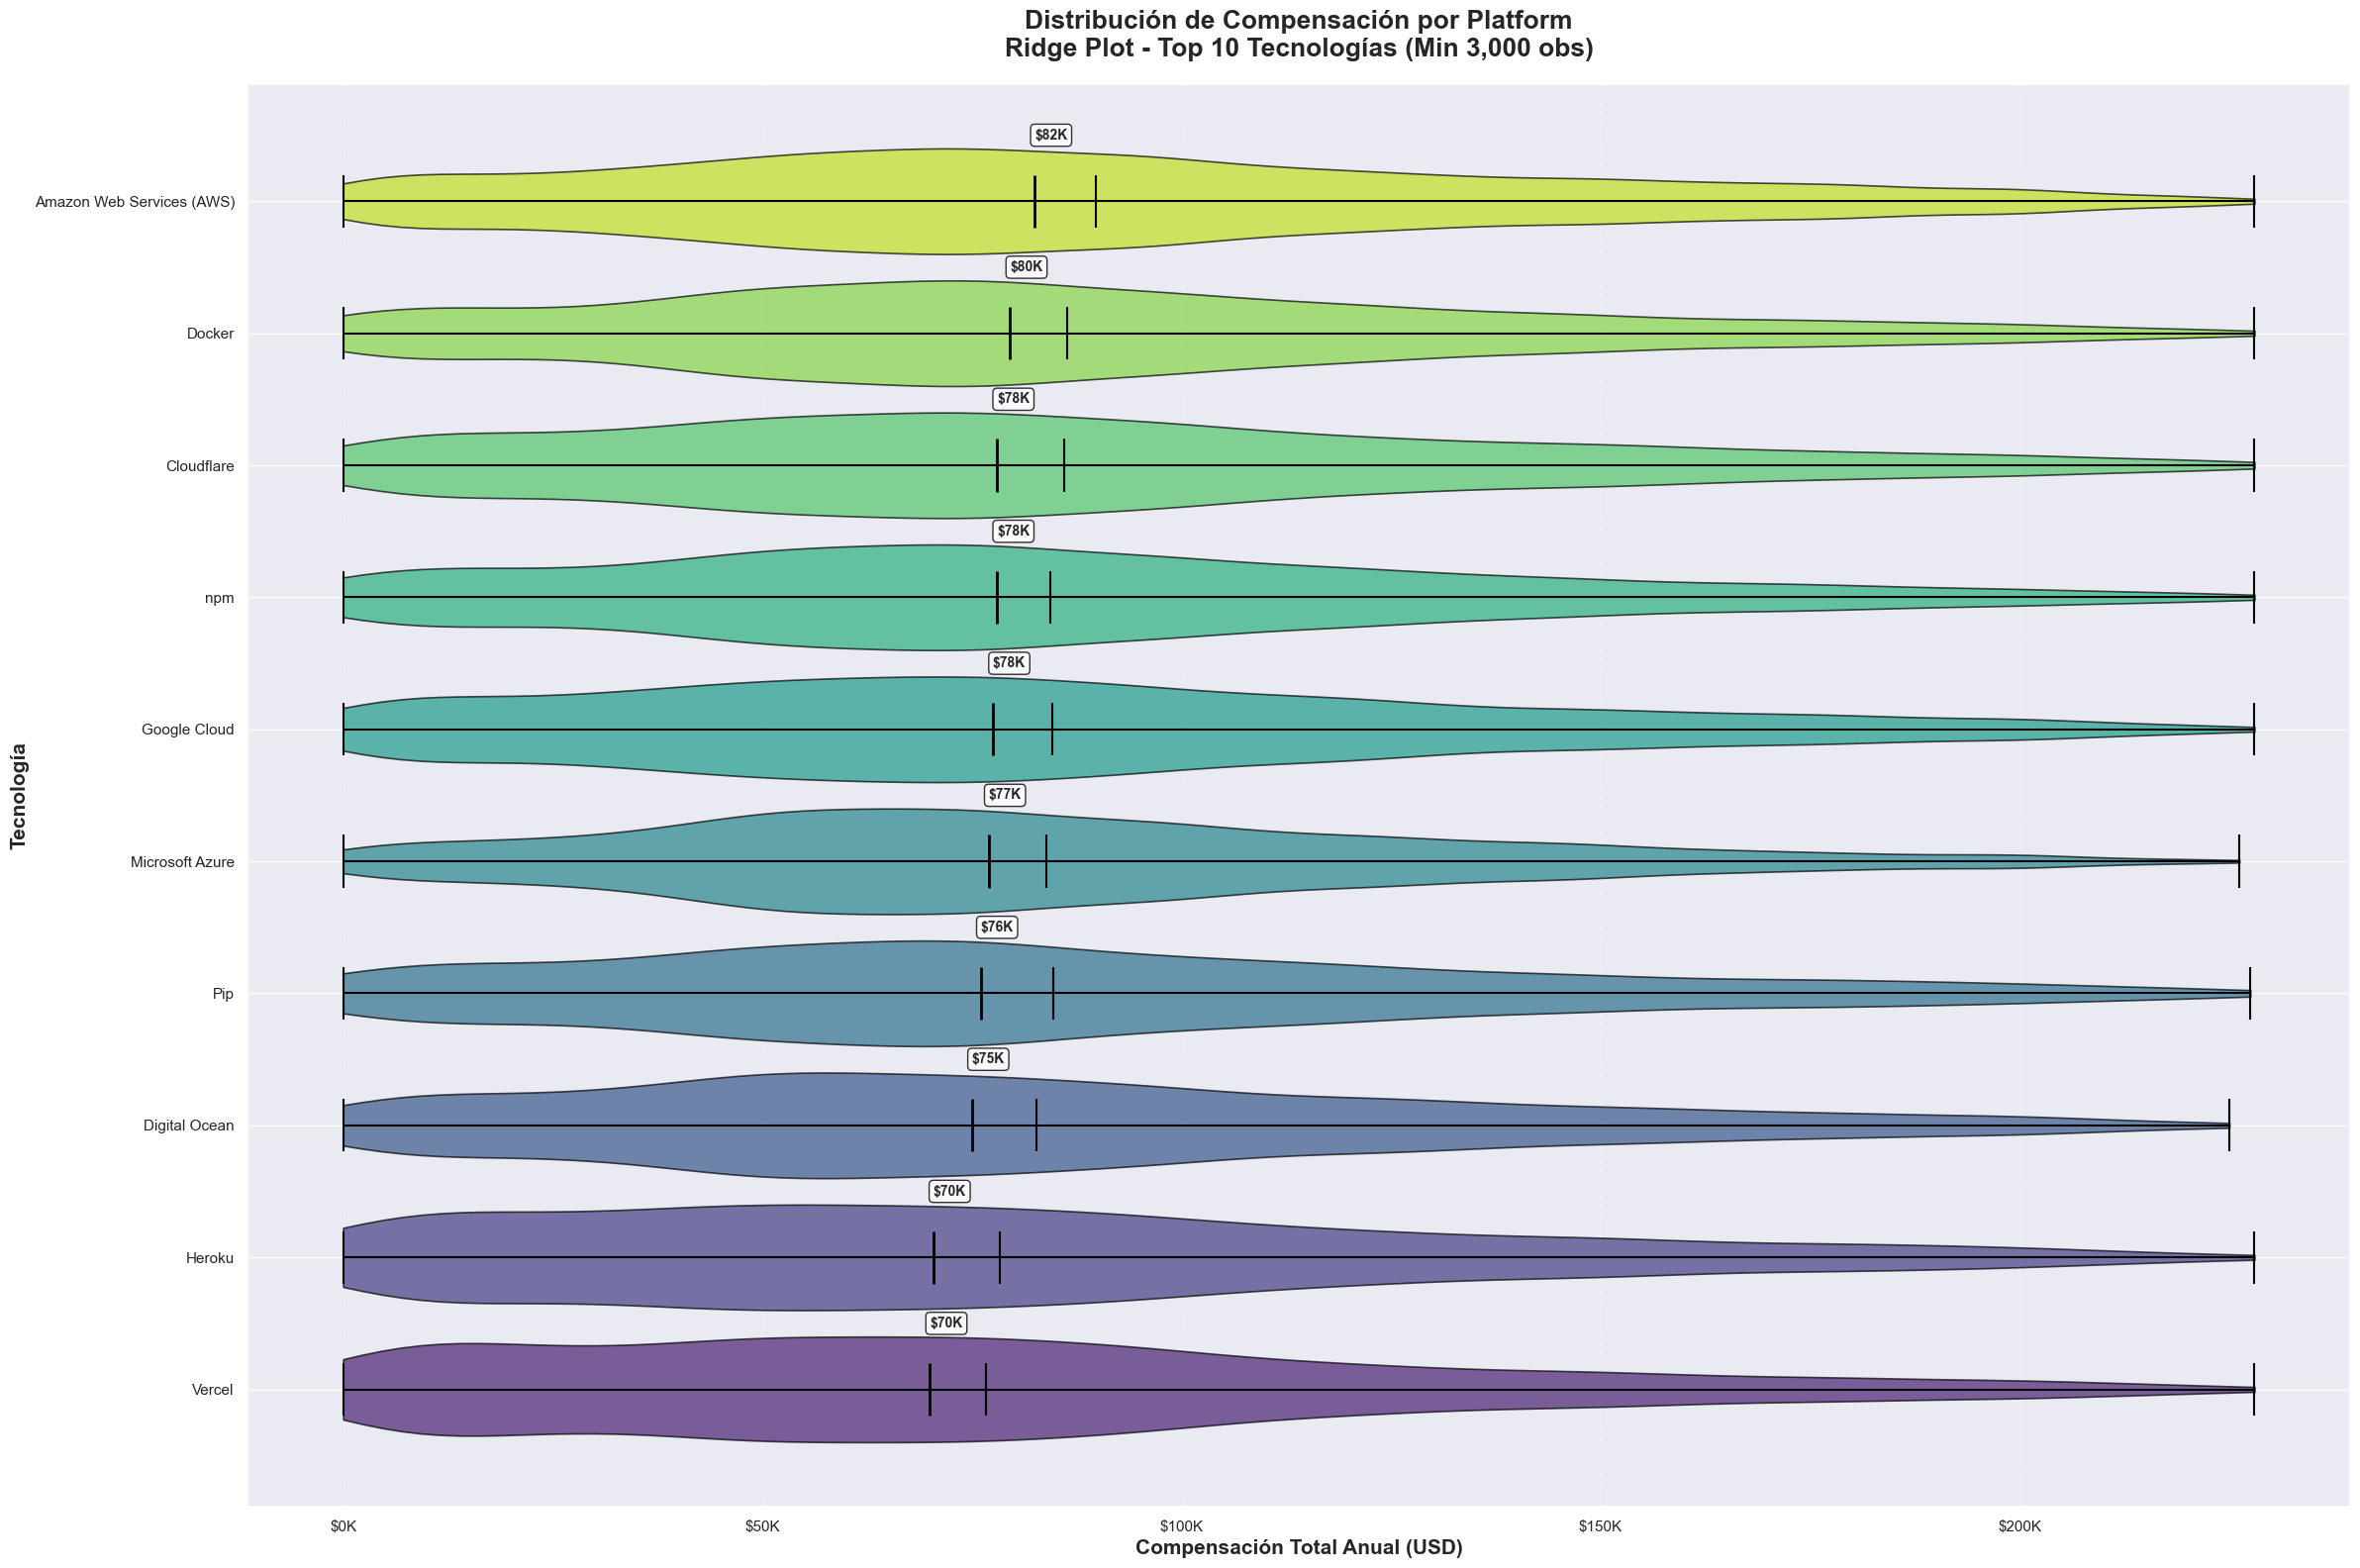

                            📊 TOP 10 PLATFORM POR COMPENSACIÓN                            

🎯 VALIDACIÓN DE HIPÓTESIS
   ✅ Platform SÍ impacta la compensación:
      • Mejor pagada:  Amazon Web Services (AWS) → $    82,493
      • Menor pagada:  Vercel               → $    70,000
      • Brecha salarial:  17.8%
      • Premium (2/10): Superan mediana global ($78,000)


📈 RANKING Y ESTADÍSTICAS (Min 3,000 observaciones)
──────────────────────────────────────────────────────────────────────────────────────────

⭐ # 1 Amazon Web Services (AWS) 
Mediana: $    82,493 ( +5.8%)
Media: $    89,825  |  Top 10%: $   170,000  |  
IQR: $    50,160-$   125,000  |  N:  19,396

⭐ # 4 Docker                    
Mediana: $    79,560 ( +2.0%)
Media: $    86,322  |  Top 10%: $   162,400  |  
IQR: $    49,140-$   117,000  |  N:   6,921

📊 # 2 Cloudflare                
Mediana: $    78,000 ( +0.0%)
Media: $    85,980  |  Top 10%: $   164,991  |  
IQR: $    46,569-$   120,000  |  N:   5,697

📊 #12 npm     

In [346]:
# ============================================================================
# ANÁLISIS DE PLATAFORMAS UTILIZADAS Y COMPENSACIÓN
# ============================================================================
variable_tecnologia = 'PlatformHaveWorkedWith'
min_observaciones = 3_000
top_n = 10
tecnologias_a_excluir = []
# 1. Gráfico de barras con métricas estadísticas (Mediana, Media, Moda)
crear_barplot_tecnologias_metricas(
  df_filtrado_sin_outliers,
  variable_tecnologia=variable_tecnologia,
  top_n=top_n,
  min_observaciones=min_observaciones,
  tecnologias_excluir=tecnologias_a_excluir
)

# 2. Ridge Plot - Distribuciones completas por lenguaje
crear_ridgeplot_tecnologias(
  df_filtrado_sin_outliers,
  variable_tecnologia=variable_tecnologia,
  top_n=top_n,
  min_observaciones=min_observaciones,
  tecnologias_excluir=tecnologias_a_excluir
)

# 3. Resumen estadístico impreso
imprimir_top_tecnologias(
  df_filtrado_sin_outliers,
  variable_tecnologia=variable_tecnologia,
  top_n=top_n,
  min_observaciones=min_observaciones,
  tecnologias_excluir=tecnologias_a_excluir
)

#### Sistemas operativos (OpSysProfessional use) vs Compensación Total (CompTotal)

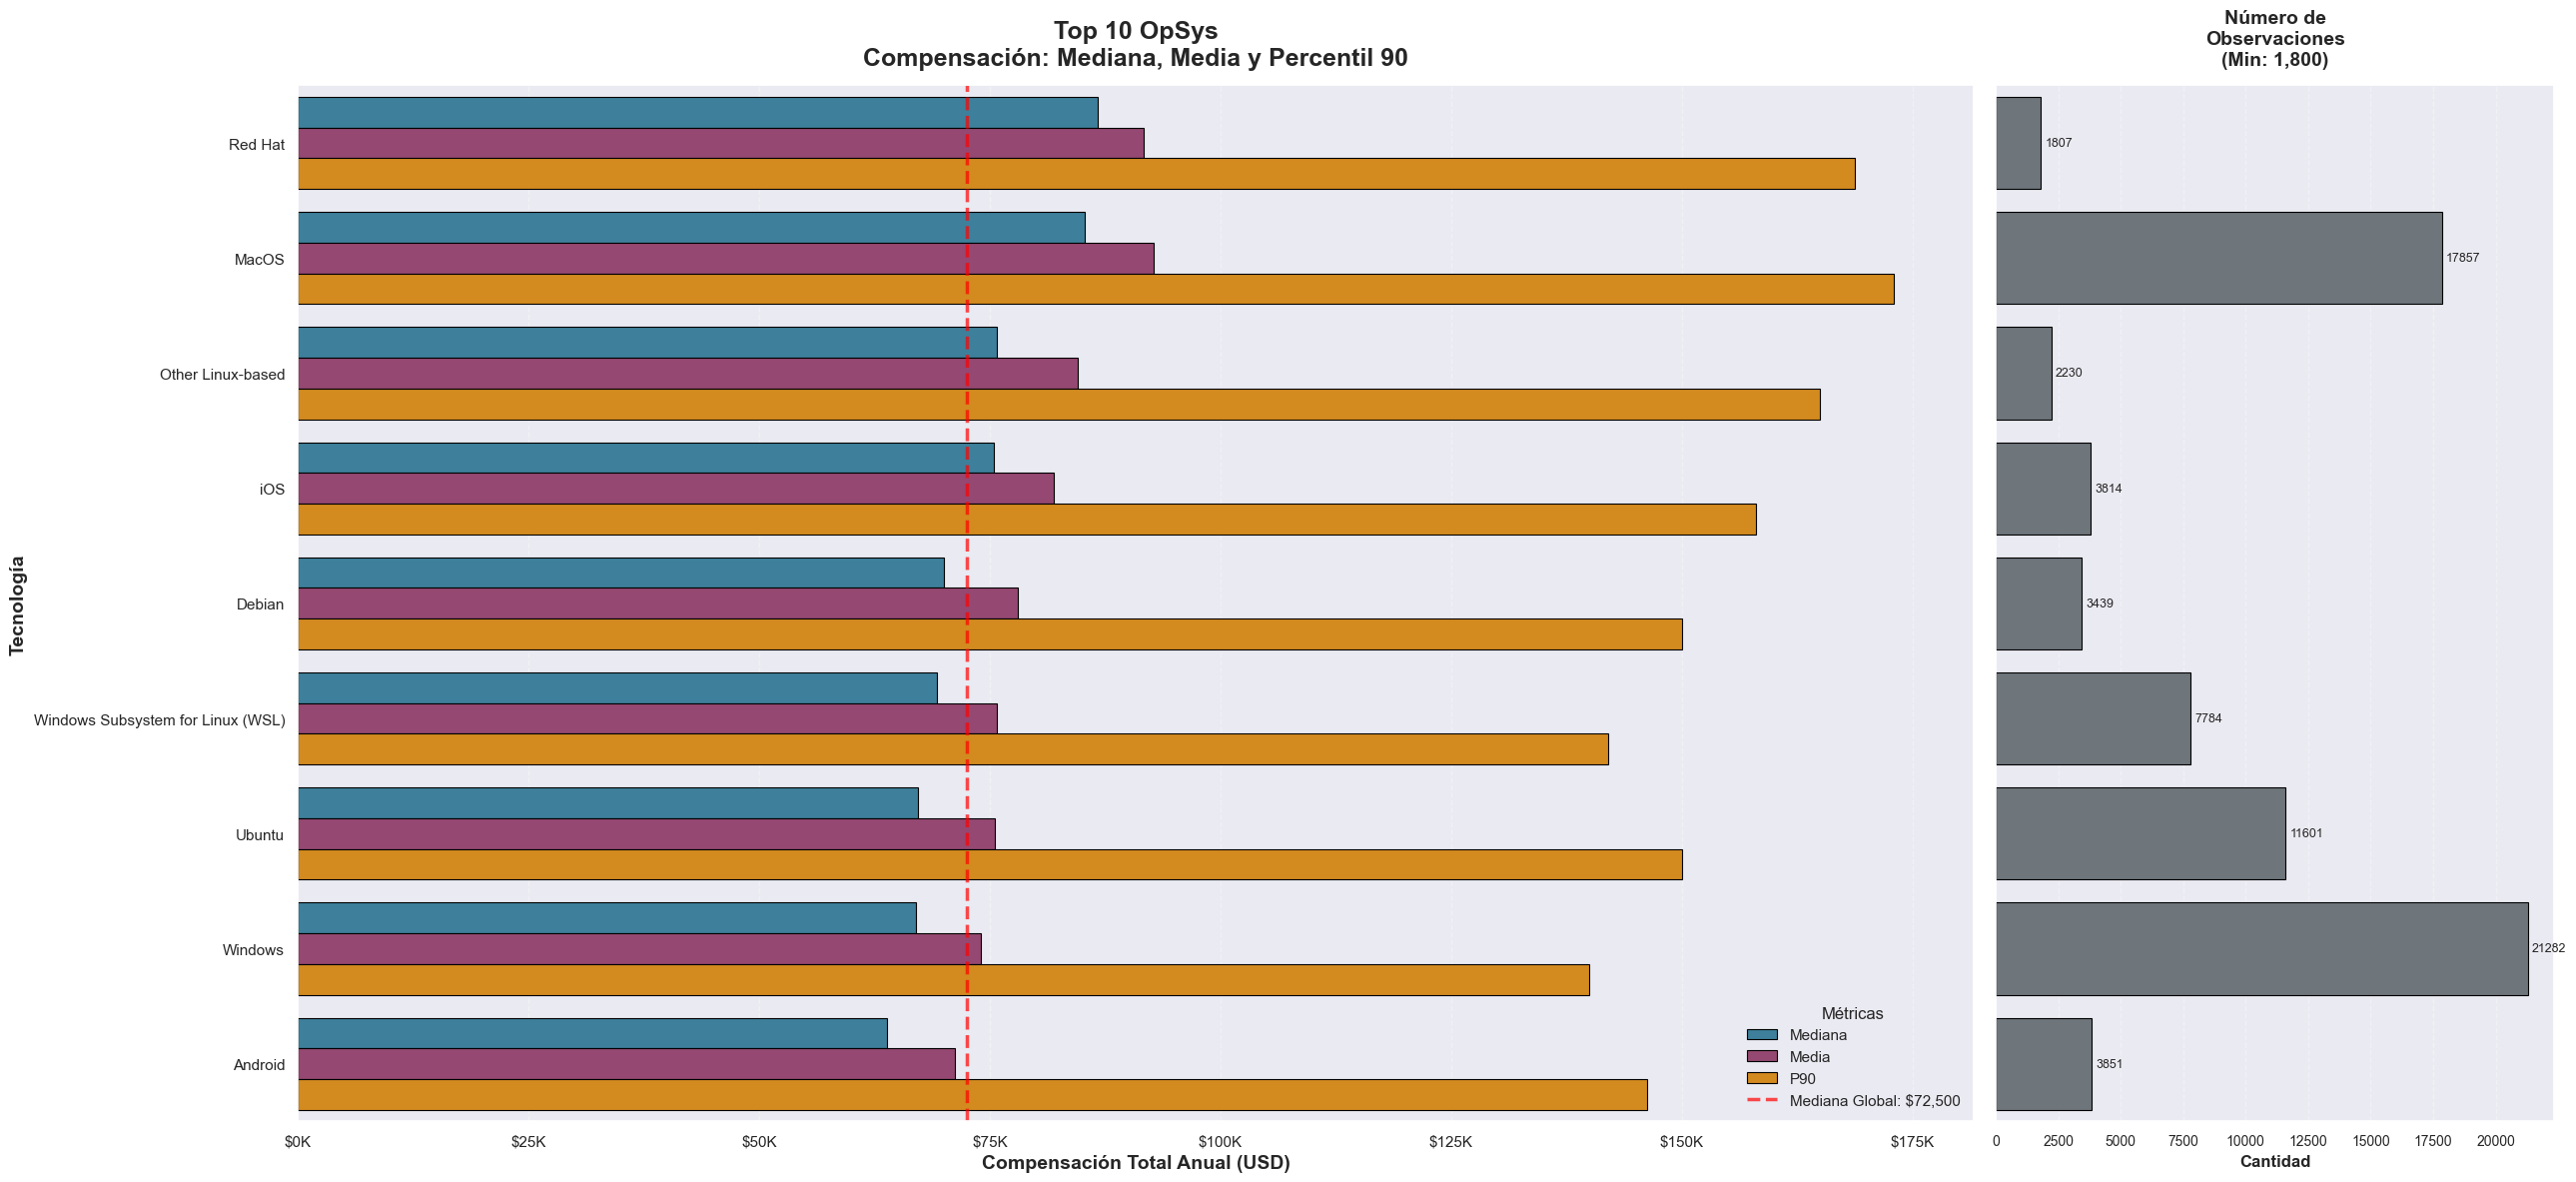

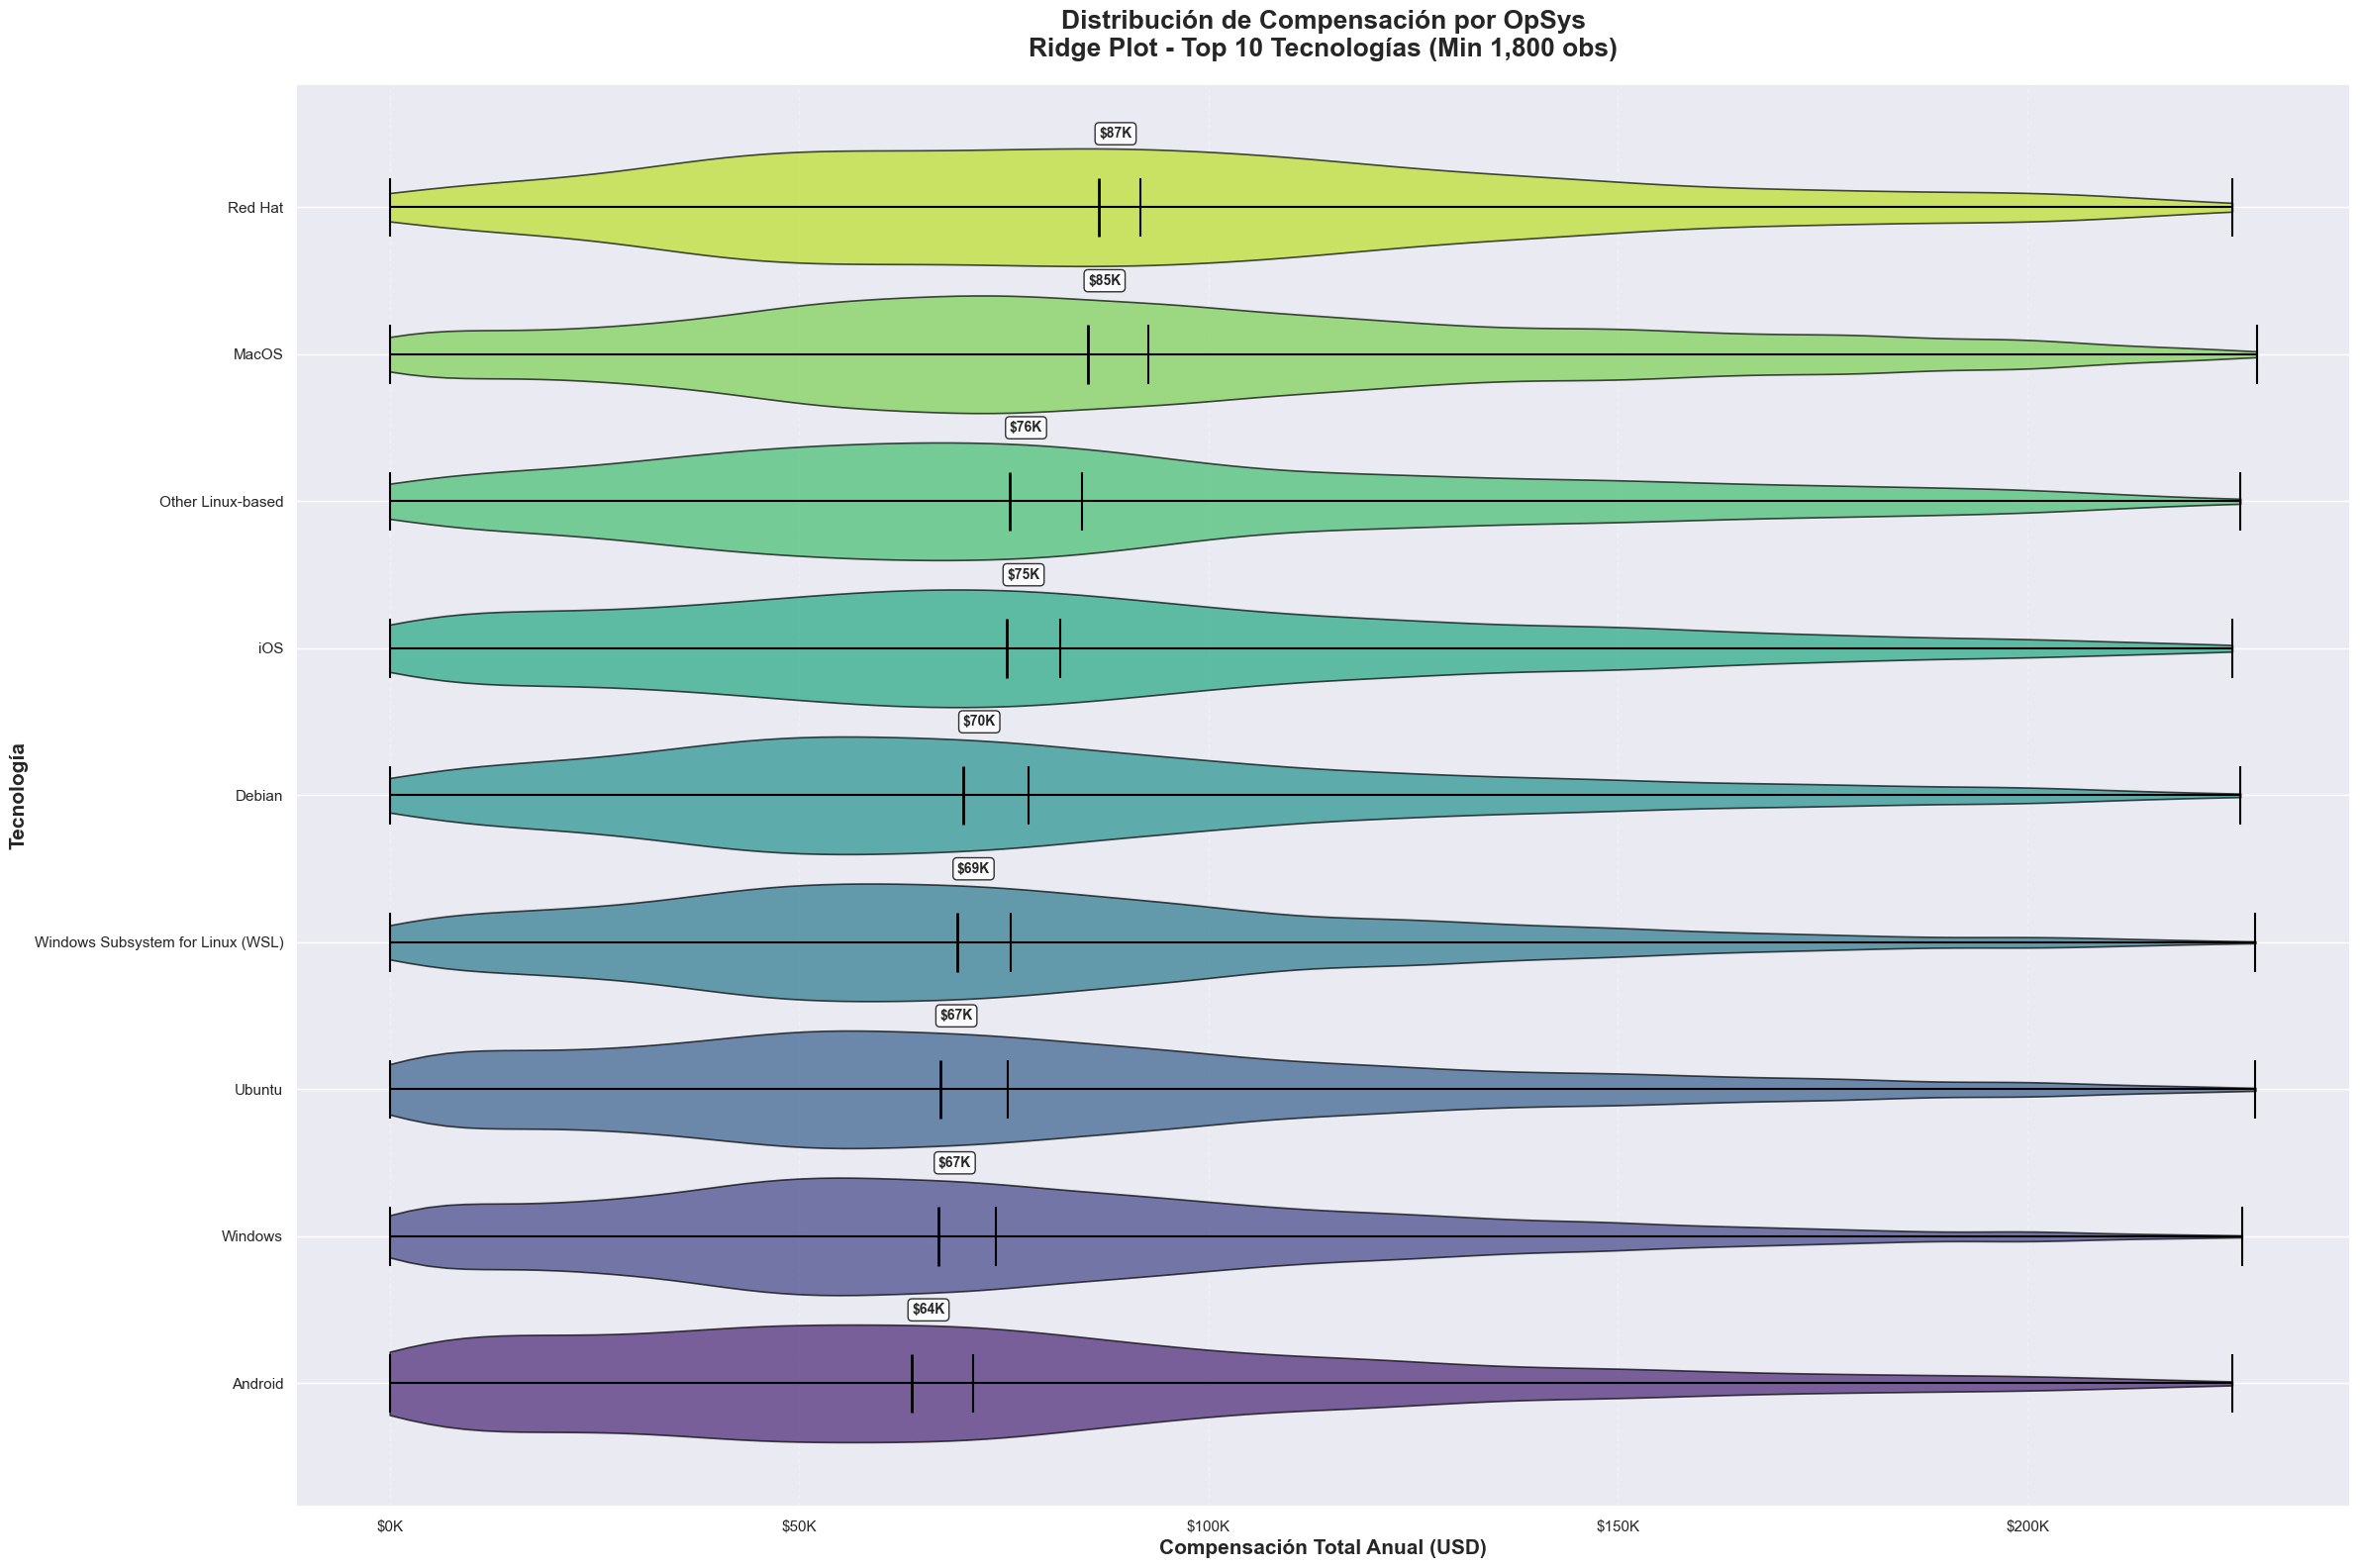

                             📊 TOP 10 OPSYS POR COMPENSACIÓN                              

🎯 VALIDACIÓN DE HIPÓTESIS
   ✅ OpSys SÍ impacta la compensación:
      • Mejor pagada:  Red Hat              → $    86,640
      • Menor pagada:  Android              → $    63,794
      • Brecha salarial:  35.8%
      • Premium (4/10): Superan mediana global ($72,500)


📈 RANKING Y ESTADÍSTICAS (Min 1,800 observaciones)
──────────────────────────────────────────────────────────────────────────────────────────

⭐ # 5 Red Hat                   
Mediana: $    86,640 (+19.5%)
Media: $    91,628  |  Top 10%: $   168,750  |  
IQR: $    51,984-$   123,205  |  N:   1,807

⭐ # 3 MacOS                     
Mediana: $    85,300 (+17.7%)
Media: $    92,693  |  Top 10%: $   173,000  |  
IQR: $    54,150-$   128,700  |  N:  17,857

⭐ # 4 Other Linux-based         
Mediana: $    75,705 ( +4.4%)
Media: $    84,515  |  Top 10%: $   165,000  |  
IQR: $    45,096-$   120,000  |  N:   2,230

⭐ # 9 iOS             

In [358]:
# ============================================================================
# ANÁLISIS DE PLATAFORMAS UTILIZADAS Y COMPENSACIÓN
# ============================================================================
variable_tecnologia = 'OpSysProfessional use'
min_observaciones = 1_800
top_n = 10
tecnologias_a_excluir = ['Ninguno']
# 1. Gráfico de barras con métricas estadísticas (Mediana, Media, Moda)
crear_barplot_tecnologias_metricas(
  df_filtrado_sin_outliers,
  variable_tecnologia=variable_tecnologia,
  top_n=top_n,
  min_observaciones=min_observaciones,
  tecnologias_excluir=tecnologias_a_excluir
)

# 2. Ridge Plot - Distribuciones completas por lenguaje
crear_ridgeplot_tecnologias(
  df_filtrado_sin_outliers,
  variable_tecnologia=variable_tecnologia,
  top_n=top_n,
  min_observaciones=min_observaciones,
  tecnologias_excluir=tecnologias_a_excluir
)

# 3. Resumen estadístico impreso
imprimir_top_tecnologias(
  df_filtrado_sin_outliers,
  variable_tecnologia=variable_tecnologia,
  top_n=top_n,
  min_observaciones=min_observaciones,
  tecnologias_excluir=tecnologias_a_excluir
)

## Conclusiones

### Resultados de las hipótesis

1. **Experiencia (YearsCode / WorkExp) → CompTotal:** **Validada.** Se observa una tendencia clara: a mayor experiencia, mayor compensación media, con mayor dispersión en los extremos.

2. **Modalidad remota (RemoteWork) → CompTotal:** **Parcialmente validada.** Los grupos *Remote* y *Hybrid* presentan compensaciones medias superiores a *In-person*, aunque pueden existir factores de confusión (rol, país, seniority).

3. **País (Country) → CompTotal:** **Validada.** Existen diferencias significativas entre países (p. ej. USA, Suiza e Israel en rangos altos vs India, Brasil en rangos bajos); la variación se mantiene entre 2023–2025.

4. **Edad (Age) → CompTotal:** **Validada.** La compensación media aumenta con la edad hasta rangos intermedios (pico aproximado 45–54), coherente con la experiencia acumulada.

5. **Tecnologías → CompTotal:** **Aproximadamente validada.** Ciertas tecnologías (lenguajes, frameworks, DBs, plataformas) muestran medianas de compensación más altas; sin embargo, la relación varía según tamaño muestral y solapamiento de stacks.

### Limitaciones del análisis

* Los datos pueden tener errores porque son respuestas personales.
* Las conversiones de moneda pueden no ser exactas.
* Algunos valores extremos influyen en los promedios.
* Faltan variables importantes (como tipo de empresa o costo de vida).
* Algunos países o tecnologías tienen pocos datos.
* Los resultados muestran relaciones, no causas directas.

### Proximos pasos

* Aplicar modelos de machine learning para predecir salarios con más precisión.
* Ajustar los valores según el costo de vida de cada país.
* Agregar más información sobre puesto, empresa y experiencia.
* Hacer pruebas estadísticas simples para confirmar diferencias.
* Automatizar el análisis y crear un panel visual con los resultados.
* Analizar más a fondo qué tecnologías se relacionan con mejores sueldos.

### Referencias

- [Stack Overflow Annual Developer Survey](https://survey.stackoverflow.co/)
- [Stack Overflow Developer Survey 2023](https://survey.stackoverflow.co/2023)
- [Stack Overflow Developer Survey 2024](https://survey.stackoverflow.co/2024)
- [Stack Overflow Developer Survey 2025](https://survey.stackoverflow.co/2025)
- [Tasas de cambio históricas](https://www.xe.com/currencytables/)
- [Documentación de pandas](https://pandas.pydata.org/docs/)
- [Documentación de seaborn](https://seaborn.pydata.org/)
- [Documentación de matplotlib](https://matplotlib.org/stable/contents.html)

### Créditos

- [LinkedIn - Franco Maidana](www.linkedin.com/in/maidana-franco07)
- [Github - Franco Maidana](www.github.com/Maidana0)
- [Repositorio - Análisis de encuestas de desarrolladores](https://github.com/Maidana0/encuestas-stack-overflow)